# Trabajo Práctico 1 : Reservas de Hotel

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

- RUIZ, Karen Belén

## Checkpoint 4

Preparación de librerías

In [65]:
%pip install joblib
%pip install visualkeras
%pip install pydot
%pip install graphviz
%pip install keras-visualizer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [313]:
import pandas as pd
import numpy as np
import tensorflow as tf

import joblib
from keras_visualizer import visualizer
import visualkeras

import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing  import  LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Seteo de semillas para mejor reproducción de resultados

In [67]:
np.random.seed(1)
tf.random.set_seed(1)

### Prepocesamiento de datos

Todos los modelos que probaremos utilizarán el dataset con el procesamiento que haremos en este apartado. Basándonos en lo extraído del checkpoint 1

Preprocesamos el dataset de train

In [68]:
hotels = pd.read_csv("../datasets/new_hotel_train.csv")
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43392 entries, 0 to 43391
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           43392 non-null  object 
 1   lead_time                       43392 non-null  int64  
 2   arrival_date_year               43392 non-null  int64  
 3   arrival_date_month              43392 non-null  object 
 4   arrival_date_week_number        43392 non-null  int64  
 5   arrival_date_day_of_month       43392 non-null  int64  
 6   stays_in_weekend_nights         43392 non-null  int64  
 7   stays_in_week_nights            43392 non-null  int64  
 8   adults                          43392 non-null  int64  
 9   children                        43392 non-null  float64
 10  babies                          43392 non-null  int64  
 11  meal                            43392 non-null  object 
 12  country                         

Es necesario hacer encoding a las variables categóricas. Utilizamos one-hot encoding para generar variables dummies

Eliminamos la columna de id, ya que sino generaría 1 variable dummy por entrada y no aporta información. Sin embargo,  no eliminamos valores para saber que estos siguen siendo las mismas entradas

In [69]:
hotelsTree = hotels.copy().drop(["id"], axis="columns")

In [70]:
categorics = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "customer_type", "deposit_type"]

hotelsTree = pd.get_dummies(hotelsTree, columns=categorics, drop_first=True)
hotelsTree = hotelsTree.sort_index(axis=1, ascending=False)
hotelsTree.head(3)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_June,arrival_date_month_July,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr
0,1,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,5,9.000000,1,115.5
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,31,242.547438,2,42.0
2,0,2,5,0,0,0,0,0,0,0,...,0,0,0,0,1,0,12,154.000000,2,75.0


In [71]:
hotelsTree.shape

(43392, 210)

Nos quedamos con el dataset sin el target y el target por separado para hacer el split. Elegimos una proporción 70-30 

In [72]:
hotels_x = hotelsTree.drop(['is_canceled'], axis='columns', inplace=False)
hotels_y = hotelsTree['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotels_x,
                                                    hotels_y,
                                                    test_size=0.18,
                                                    random_state=0)

Inspeccionamos los resultados

In [73]:
x_train.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_June,arrival_date_month_July,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr
10181,0,2,4,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,236.0,1,120.0
2486,0,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,298.0,1,42.0


In [74]:
x_test.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_June,arrival_date_month_July,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr
13394,0,0,4,0,0,0,0,0,0,0,...,0,0,0,1,0,0,15,44.750143,2,78.0
38024,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,18,19.000000,1,75.0


In [75]:
y_train.head(2)

10181    1
2486     0
Name: is_canceled, dtype: int64

In [76]:
y_test.head(2)

13394    0
38024    0
Name: is_canceled, dtype: int64

Preprocesamos el dataset de test, para esto hacemos el mismo tratamiento de datos faltantes que hicimos en el checkpoint 1:

In [77]:
hotelsTest = pd.read_csv("../datasets/hotels_test.csv")

Eliminamos la columna company

In [78]:
hotelsTestFiltered = hotelsTest.copy().drop(columns=["company"])

Los nulos que quedan son

In [79]:
nullsFiltered = hotelsTestFiltered.get(["agent", "country"]).isnull()

nullsStats = pd.DataFrame({"Cantidad de Nulos": nullsFiltered.sum(), "Porcentaje de nulos": round(nullsFiltered.mean() * 100, 2)})
nullsStats

,Cantidad de Nulos,Porcentaje de nulos
agent,3363,12.67
country,95,0.36


Hacemos label encoding para luego imputar estos datos nulos

In [80]:
varsToEncode = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel","reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "id"]
labelEncoders = {}

for varToEncode in varsToEncode:
    encoder = LabelEncoder()
    hotelsTestFiltered[varToEncode] = encoder.fit_transform(hotelsTestFiltered[varToEncode])
    labelEncoders[varToEncode] = encoder

In [81]:
imputer = IterativeImputer(estimator=BayesianRidge(), missing_values=np.nan, max_iter=10, verbose=0, random_state=0)

originalDtypes = hotelsTestFiltered.dtypes
imputedAndFilteredTest = hotelsTestFiltered.copy()

imputedAndFilteredTest = pd.DataFrame(imputer.fit_transform(imputedAndFilteredTest), columns=imputedAndFilteredTest.columns)

In [82]:
imputedAndFilteredTest["agent"] = imputedAndFilteredTest["agent"].clip(lower=hotelsTestFiltered.agent.min(), upper=hotelsTestFiltered.agent.max())
imputedAndFilteredTest["country"] = imputedAndFilteredTest["country"].clip(lower=hotelsTestFiltered.country.min(), upper=hotelsTestFiltered.country.max())
imputedAndFilteredTest = imputedAndFilteredTest.astype(originalDtypes)

Decodeamos

In [83]:
for varToEncode in varsToEncode:
    encoder = labelEncoders.get(varToEncode)
    imputedAndFilteredTest[varToEncode] = encoder.inverse_transform(imputedAndFilteredTest[varToEncode])

In [84]:
imputedAndFilteredTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

Ahora, igual que a los datos de train más arriba, hacemos one-hot encoding a los datos de test

Guardamos las ids para posterior match entre resultado y id

In [85]:
hotelsTestIds = imputedAndFilteredTest["id"]

In [86]:
imputedAndFilteredTestEncoded = imputedAndFilteredTest.copy()
imputedAndFilteredTestEncoded.drop(["id"], axis="columns", inplace=True)
imputedAndFilteredTestEncoded = pd.get_dummies(imputedAndFilteredTestEncoded, columns=categorics, drop_first=True)

imputedAndFilteredTestEncoded.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_Non Refund,deposit_type_Refundable
0,277,2016,46,7,1,2,2,0.0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,286,2016,20,11,0,4,2,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,2016,35,23,0,1,3,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [87]:
imputedAndFilteredTestEncoded.shape

(26535, 201)

Comparamos el shape con el dataset de train, ya que el modelo "entenderá" la estructura con la que fue entrenado

In [88]:
hotelsTree.shape

(43392, 210)

Observamos que hay una discrepancia, así que obtenemos las columnas que están presentes de manera única en cada dataset

In [89]:
hotelsTreeWithoutTarget = hotelsTree.copy()
hotelsTreeWithoutTarget.drop(["is_canceled"], axis="columns", inplace=True)
hotelsTreeColumns = set(hotelsTreeWithoutTarget.columns)
imputedAndFilteredTestEncodedColumns = set(imputedAndFilteredTestEncoded.columns)

columnsOnlyInHotelsTree = np.array(list(hotelsTreeColumns - imputedAndFilteredTestEncodedColumns)).tolist()

columnsOnlyInImputedAndFiltered = np.array(list(imputedAndFilteredTestEncodedColumns - hotelsTreeColumns)).tolist()

print("Columnas presentes solamente en hotelsTree:", columnsOnlyInHotelsTree)
print("Columnas presentes solamente en imputedAndFilteredTestEncoded:", columnsOnlyInImputedAndFiltered)

Columnas presentes solamente en hotelsTree: ['country_NAM', 'country_TGO', 'country_SYR', 'country_BEN', 'country_KEN', 'country_MDG', 'country_HND', 'country_ARM', 'country_SYC', 'country_PAN', 'country_ETH', 'country_UMI', 'country_MYT', 'country_COM', 'country_FRO', 'country_SDN', 'country_CIV', 'country_FJI', 'country_VGB', 'country_MNE', 'country_MUS', 'country_AZE', 'country_ZMB']
Columnas presentes solamente en imputedAndFilteredTestEncoded: ['country_NIC', 'country_TMP', 'country_DMA', 'country_MLI', 'country_BFA', 'reserved_room_type_L', 'country_DJI', 'country_ATF', 'country_SLV', 'country_KHM', 'country_ASM', 'country_SMR', 'country_UZB', 'country_STP', 'country_GHA']


Eliminamos las columnas presentes sólo en los datos de test que no fueron vistos durante el entrenamiento

In [90]:
imputedAndFilteredTestEncoded.drop(columnsOnlyInImputedAndFiltered, axis="columns", inplace=True)
imputedAndFilteredTestEncoded.shape

(26535, 186)

Agregamos las columnas faltantes a los datos de test que sí están en los datos de train, ponemos sus valores en 0

In [91]:
for column in columnsOnlyInHotelsTree:
    imputedAndFilteredTestEncoded[column] = 0

imputedAndFilteredTestEncoded = imputedAndFilteredTestEncoded.sort_index(axis=1, ascending=False)
imputedAndFilteredTestEncoded.shape

(26535, 209)

In [92]:
imputedAndFilteredTestEncoded.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_June,arrival_date_month_July,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr
0,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,36.162958,2,100.0
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,30.000000,2,101.0


In [93]:
hotelsTreeWithoutTarget.shape

(43392, 209)

### Redes Neuronales

#### Normalización

Tenemos ya el dataset de train y el final listos, con el de train spliteado una porción de test del ~1/6

Hacemos una normalización de los datos con un escalador Standard para alinear mejor los datos con el funcionamiento de una red neuronal

In [94]:
standardScaler = StandardScaler()

x_train_scaled = standardScaler.fit_transform(x_train)
x_test_scaled = standardScaler.transform(x_test)

In [95]:
testDataScaled = standardScaler.transform(imputedAndFilteredTestEncoded)

#### Perceptrón simple

Haremos una perceptrón con la capa de entrada y 1 neurona que producirá el output

Establecemos la cantidad de neuronas de las capas en base a la forma del dataset. La cantidad de columnas para la de entrada y 1 como salida para el 0 o 1 de la predicción de cancelación de reserva

In [82]:
inputVariablesAmount = x_train_scaled.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 209
Output layer amount: 1


Utilizamos la función de loss a minimizar binary_crossentropy, ya que estamos haciendo una predicción binaria, junto con la implementación de descenso por gradiente estocástico Adam, teniendo en cuenta la métrica f1 score

InputLayer Tensorflow Keras Docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer

BinaryCrossentropy Tensorflow Keras Docs: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

Adam Tensorflow Keras Docs: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [83]:
perceptron = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

perceptron.compile(loss=binaryCrossentropy,
              optimizer="adam",
              metrics=[f1Scorer])

perceptron.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 210       
                                                                 
Total params: 210 (840.00 Byte)
Trainable params: 210 (840.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Convertimos los targets de enteros a floats y ejecutamos el entrenamiento con una porción de validación del 20%

In [84]:
runNumber = 37
y_train_float = tf.cast(y_train, tf.float32)

epochs = 50
batchSize = 32
validationProportion = 0.2

perceptronTrainingHistory = perceptron.fit(x_train_scaled,
                                                 y_train_float,
                                                 epochs = epochs,
                                                 batch_size = batchSize,
                                                 validation_split = validationProportion,
                                                 use_multiprocessing = True,
                                                 workers = 30,
                                                 verbose = 1)

Epoch 1/50


890/890 [==============================] - 1s 1ms/step - loss: 0.5666 - f1_score: 0.6665 - val_loss: 0.4811 - val_f1_score: 0.6663
Epoch 2/50
890/890 [==============================] - 1s 882us/step - loss: 0.4616 - f1_score: 0.6666 - val_loss: 0.4525 - val_f1_score: 0.6663
Epoch 3/50
890/890 [==============================] - 1s 891us/step - loss: 0.4463 - f1_score: 0.6666 - val_loss: 0.4455 - val_f1_score: 0.6663
Epoch 4/50
890/890 [==============================] - 1s 875us/step - loss: 0.4409 - f1_score: 0.6666 - val_loss: 0.4420 - val_f1_score: 0.6663
Epoch 5/50
890/890 [==============================] - 1s 877us/step - loss: 0.4376 - f1_score: 0.6666 - val_loss: 0.4426 - val_f1_score: 0.6664
Epoch 6/50
890/890 [==============================] - 1s 902us/step - loss: 0.4360 - f1_score: 0.6667 - val_loss: 0.4401 - val_f1_score: 0.6664
Epoch 7/50
890/890 [==============================] - 1s 888us/step - loss: 0.4347 - f1_score: 0.6667 - val_loss: 0.4415 - val_f1_score: 0.6664
Epoch

Mostramos la evolución del f1 score y del valor de la función de loss con el paso de las iteraciones

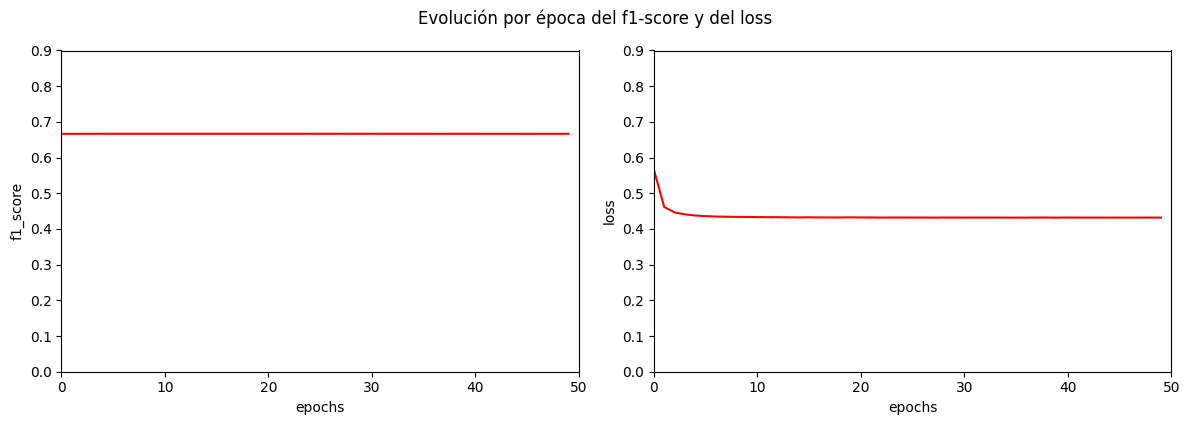

In [85]:
epochsRange = range(epochs)
figure, subplots = plt.subplots(1, 2, figsize=(12, 4))
plt.ylim(0, 0.8)

subplots[0].plot(epochsRange, perceptronTrainingHistory.history['f1_score'], color='red', label='f1_score')
subplots[0].set_xlabel("epochs")
subplots[0].set_ylabel("f1_score")
subplots[0].set_ylim(0, 0.9)
subplots[0].set_xlim(0, epochs)

subplots[1].plot(epochsRange, perceptronTrainingHistory.history['loss'], color='red', label='loss')
subplots[1].set_xlabel("epochs")
subplots[1].set_ylabel("loss")
subplots[1].set_ylim(0, 0.9)
subplots[1].set_xlim(0, epochs)

plt.tight_layout()
figure.suptitle("Evolución por época del f1-score y del loss", y=1.05)
plt.show()

Visualizamos el perceptrón que consta de una capa de una neurona

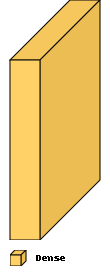

In [86]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Definimos una función para convertir las probabilidades predichas por el modelo, en particular como output de la función sigmoidea, en un output binario. Tomaremos que una probabilidad mayor al 50% será 1 y 0 de otra manera

In [87]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Ejecutamos la predicción de train con el dataset de train completo

In [88]:
y_pred = perceptron.predict(x_train_scaled)
y_pred = convertProbasToClasses(y_pred)

 925/1112 [=======================>......] - ETA: 0s

1112/1112 [==============================] - 1s 565us/step


Mostramos las métricas

In [89]:
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.7865152750063236
Recall: 0.7837822639599618
Precision: 0.7879473118887445
f1 score: 0.7858592692828147


Realizamos ahora las predicciones del split de test

In [336]:
y_pred = perceptron.predict(x_test_scaled)
y_pred = convertProbasToClasses(y_pred)

  1/245 [..............................] - ETA: 10s

245/245 [==============================] - 0s 767us/step


Imprimimos la matriz de confusión

F1-Score: 0.7810181632130979


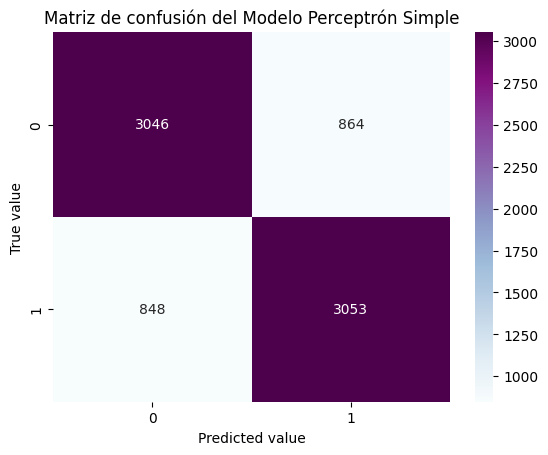

In [338]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_test,y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón Simple")
plt.show()

Mostramos las distintas métricas

In [92]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.7808219178082192
Recall: 0.7826198410663933
Precision: 0.7794230278274189
f1 score: 0.7810181632130979


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [93]:
y_pred = perceptron.predict(testDataScaled)
y_pred = convertProbasToClasses(y_pred)

 88/830 [==>...........................] - ETA: 0s 

830/830 [==============================] - 0s 571us/step


Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [94]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr,id,is_canceled
0,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,7,36.162958,2,100.0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,11,30.000000,2,101.0,aba9aac2-4495-4645-a60e-90328713c999,1


Para exportar a Kaggle hacemos lo siguiente

In [95]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [96]:
exportResult.head(2)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1


El `runNumber` es sólo un número que ponemos para no pisar los submits

In [97]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron.csv", index=False)

In [98]:
filename = f'./perceptron_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_model_37.joblib']

#### Perceptrón multicapa

Agregamos una capa fully-connected del mismo tamaño del input, está será la única hidden layer y luego estará la capa de output que es 1 neurona

In [ ]:
inputVariablesAmount = x_train_scaled.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 209
Output layer amount: 1


Para la hidden layer usamos la función de activación relu. Además disminuimos el learning rate del optimizer Adam. La hidden layer llevará la función de activación ReLU

DenseLayer Tensorflow Keras Docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

ReLU Tensorflow Keras Docs: https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu

In [ ]:
perceptron = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(inputVariablesAmount, activation="relu"),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adamOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

perceptron.compile(loss=binaryCrossentropy,
                        optimizer=adamOptimizer,
                        metrics=[f1Scorer])

perceptron.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 209)               43890     
                                                                 
 dense_5 (Dense)             (None, 1)                 210       
                                                                 
Total params: 44100 (172.27 KB)
Trainable params: 44100 (172.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Convertimos los targets de enteros a floats y ejecutamos el entrenamiento con una porción de validación del 20%

In [ ]:
runNumber = 38
y_train_float = tf.cast(y_train, tf.float32)

epochs = 500
batchSize = 32
validationProportion = 0.2

perceptronTrainingHistory = perceptron.fit(x_train_scaled,
                                                 y_train_float,
                                                 epochs=epochs,
                                                 batch_size=batchSize,
                                                 validation_split=validationProportion,
                                                 use_multiprocessing= True,
                                                 workers=30,
                                                 verbose=1)

Epoch 1/500
 45/890 [>.............................] - ETA: 0s - loss: 0.7837 - f1_score: 0.6777  

890/890 [==============================] - 2s 1ms/step - loss: 0.7124 - f1_score: 0.6665 - val_loss: 0.6631 - val_f1_score: 0.6664
Epoch 2/500
890/890 [==============================] - 1s 1ms/step - loss: 0.6263 - f1_score: 0.6665 - val_loss: 0.6022 - val_f1_score: 0.6664
Epoch 3/500
890/890 [==============================] - 1s 1ms/step - loss: 0.5763 - f1_score: 0.6665 - val_loss: 0.5631 - val_f1_score: 0.6664
Epoch 4/500
890/890 [==============================] - 1s 1ms/step - loss: 0.5427 - f1_score: 0.6665 - val_loss: 0.5352 - val_f1_score: 0.6664
Epoch 5/500
890/890 [==============================] - 1s 1ms/step - loss: 0.5182 - f1_score: 0.6665 - val_loss: 0.5143 - val_f1_score: 0.6663
Epoch 6/500
890/890 [==============================] - 1s 1ms/step - loss: 0.4995 - f1_score: 0.6665 - val_loss: 0.4980 - val_f1_score: 0.6663
Epoch 7/500
890/890 [==============================] - 1s 1ms/step - loss: 0.4849 - f1_score: 0.6665 - val_loss: 0.4851 - val_f1_score: 0.6663
Epoch 8/500

Mostramos la evolución del f1 score y del valor de la función de loss con el paso de las iteraciones

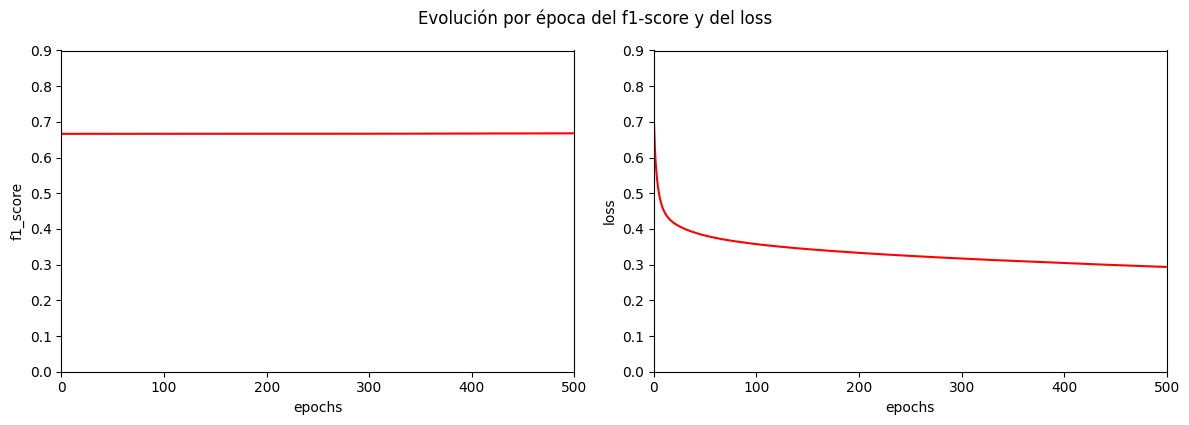

In [ ]:
epochsRange = range(epochs)
figure, subplots = plt.subplots(1, 2, figsize=(12, 4))
plt.ylim(0, 0.8)

subplots[0].plot(epochsRange, perceptronTrainingHistory.history['f1_score'], color='red', label='f1_score')
subplots[0].set_xlabel("epochs")
subplots[0].set_ylabel("f1_score")
subplots[0].set_ylim(0, 0.9)
subplots[0].set_xlim(0, epochs)

subplots[1].plot(epochsRange, perceptronTrainingHistory.history['loss'], color='red', label='loss')
subplots[1].set_xlabel("epochs")
subplots[1].set_ylabel("loss")
subplots[1].set_ylim(0, 0.9)
subplots[1].set_xlim(0, epochs)

plt.tight_layout()
figure.suptitle("Evolución por época del f1-score y del loss", y=1.05)
plt.show()

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

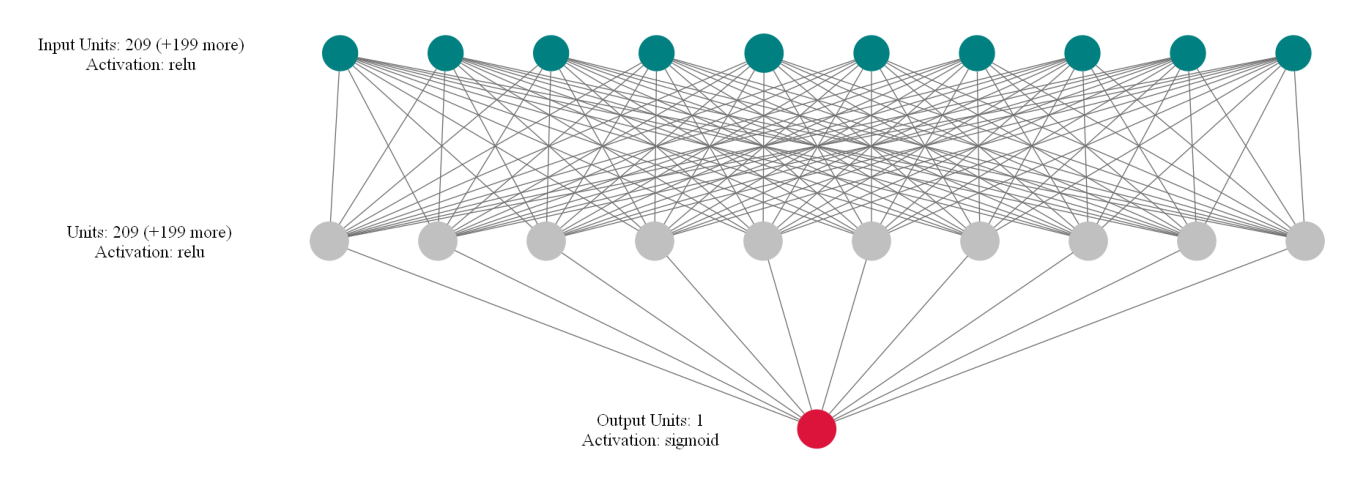

In [ ]:
perceptronImagePath = f"./imgs/{runNumber}_perceptron"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(perceptron, view=False, file_name=perceptronImagePath, file_format='png', settings=my_settings)

perceptronImage = plt.imread(f"{perceptronImagePath}.png")

plt.figure(figsize = (18,6))
plt.axis('off')
plt.imshow(perceptronImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

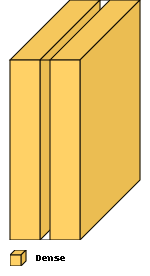

In [ ]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Ejecutamos la predicción de train con el dataset de train completo

In [ ]:
y_pred = perceptron.predict(x_train_scaled)
y_pred = convertProbasToClasses(y_pred)

 131/1112 [==>...........................] - ETA: 0s

1112/1112 [==============================] - 1s 669us/step


Mostramos las métricas

In [ ]:
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8603468143110087
Recall: 0.8679637856379688
Precision: 0.8548404962339389
f1 score: 0.8613521582633444


Realizamos ahora las predicciones del split de test

In [340]:
y_pred = perceptron.predict(x_test_scaled)
y_pred = convertProbasToClasses(y_pred)

  1/245 [..............................] - ETA: 10s

245/245 [==============================] - 0s 2ms/step


Imprimimos la matriz de confusión

F1-Score: 0.8278927981709641


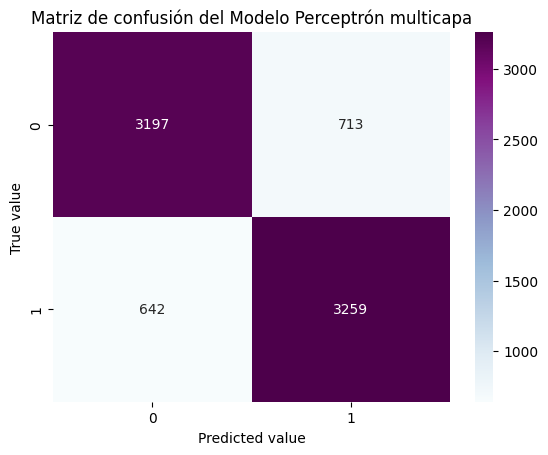

In [342]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_test,y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón multicapa")
plt.show()

Mostramos las distintas métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.82652669312508
Recall: 0.8354268136375288
Precision: 0.8204934541792548
f1 score: 0.8278927981709641


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [ ]:
y_pred = perceptron.predict(testDataScaled)
y_pred = convertProbasToClasses(y_pred)

148/830 [====>.........................] - ETA: 0s

830/830 [==============================] - 1s 681us/step


Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [ ]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr,id,is_canceled
0,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,7,36.162958,2,100.0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,11,30.000000,2,101.0,aba9aac2-4495-4645-a60e-90328713c999,0


Para exportar a Kaggle hacemos lo siguiente

In [ ]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [ ]:
exportResult.head(2)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0


El `runNumber` es sólo un número que ponemos para no pisar los submits

In [ ]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron.csv", index=False)

In [ ]:
filename = f'./perceptron_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_model_38.joblib']

#### Red Neuronal Multicapa con optimización de hiperparámetros

Crearemos una red neuronal multicapa a la que luego le haremos una optimización de hiperparámetros bayesiana

Establecemos la cantidad de variables de input y output

In [195]:
inputVariablesAmount = x_train_scaled.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 209
Output layer amount: 1


Volvemos a definir la función para pasar la probabilidad a una decisión binaria

In [196]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Utilizaremos una arquitectura de 1 capa de input, y 4 hidden layers. Cada hidden layer estará compuesta por una capa fully-connected con activación lineal, seguida de una capa de activación de tipo LeakyReLU y finalizando con una capa de dropout.

Se optimizarán de manera bayesiana (mismo método utilizado en el checkpoint 3 con la librería optuna) los rates de dropout para cada capa Dropout, la cantidad de neuronas de las capas fully-connected, los parámetros de regularización L2 para cada capa, el learning rate del optimizador Nadam y el batch size.

Se utilizará para cada iteración un early stopping con patience de 8 epochs, que vigilará el loss en validación y se quedará con los parámetros finales luego de las epochs de patience. El máximo de epochs serán 50.

El proceso de optimización de hiperparámetros se enfocará en medir el f1 score. De esta manera se tratará de maximizar el f1 score y minimizar el loss en validación al mismo tiempo

In [208]:
neuralNetworkTrainingHistoryArr = []
runNumber = 39

def objective(trial):
    dropOutRate_1 = trial.suggest_float("dropOutRate_1", 0.05, 0.30, log=True)
    dropOutRate_2 = trial.suggest_float("dropOutRate_2", 0.05, 0.30, log=True)
    dropOutRate_3 = trial.suggest_float("dropOutRate_3", 0.05, 0.30, log=True)
    dropOutRate_4 = trial.suggest_float("dropOutRate_4", 0.05, 0.30, log=True)

    neuronsLayer_1 = trial.suggest_int('neuronsLayer_1', 10, inputVariablesAmount)
    neuronsLayer_2 = trial.suggest_int('neuronsLayer_2', 10, inputVariablesAmount)
    neuronsLayer_3 = trial.suggest_int('neuronsLayer_3', 10, inputVariablesAmount)
    neuronsLayer_4 = trial.suggest_int('neuronsLayer_4', 10, inputVariablesAmount)

    kernelL2_1 = trial.suggest_float("kernelL2_1", 0, 0.00002)
    kernelL2_2 = trial.suggest_float("kernelL2_2", 0, 0.00002)
    kernelL2_3 = trial.suggest_float("kernelL2_3", 0, 0.00002)
    kernelL2_4 = trial.suggest_float("kernelL2_4", 0, 0.00002)

    neuralNetwork = Sequential([
        InputLayer(input_shape=(inputVariablesAmount,)),
        Dense(neuronsLayer_1, kernel_regularizer=L2(kernelL2_1)),
        LeakyReLU(alpha=0.05),
        Dropout(dropOutRate_1, seed=0),
        Dense(neuronsLayer_2, kernel_regularizer=L2(kernelL2_2)),
        LeakyReLU(alpha=0.05),
        Dropout(dropOutRate_2, seed=0),
        Dense(neuronsLayer_3, kernel_regularizer=L2(kernelL2_3)),
        LeakyReLU(alpha=0.05),
        Dropout(dropOutRate_3, seed=0),
        Dense(neuronsLayer_4, kernel_regularizer=L2(kernelL2_4)),
        LeakyReLU(alpha=0.05),
        Dropout(dropOutRate_4, seed=0),
        Dense(outputVariablesAmount, activation='sigmoid')
    ])

    f1Scorer =  tf.keras.metrics.F1Score()
    binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    learningRate = trial.suggest_float("learningRate", 1e-6, 0.11, log=True)
    nadamOptimizer = tf.keras.optimizers.Nadam(learning_rate=learningRate)

    neuralNetwork.compile(loss=binaryCrossentropy,
                            optimizer=nadamOptimizer,
                            metrics=[f1Scorer, "accuracy"])

    y_train_float = tf.cast(y_train, tf.float32)

    epochs = 50
    batchSize = trial.suggest_int("batchSize", 8, 40)
    validationProportion = 0.20

    earlyStopping = tf.keras.callbacks.EarlyStopping(
                              patience=8,
                              min_delta=0.00001,                               
                              monitor="val_loss",
                              restore_best_weights=False
                              )

    neuralNetworkTrainingHistoryArr.append(
        neuralNetwork.fit(x_train_scaled,
                    y_train_float,
                    epochs=epochs,
                    batch_size=batchSize,
                    validation_split=validationProportion,
                    callbacks=[earlyStopping],
                    use_multiprocessing= True,
                    workers=30,
                    verbose=0)
    )

    y_pred = neuralNetwork.predict(x_train_scaled)
    y_pred = convertProbasToClasses(y_pred)
    return f1_score(y_train, y_pred)

Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba

In [209]:
study = optuna.create_study(direction='maximize')

[I 2023-10-29 20:09:11,798] A new study created in memory with name: no-name-f31e605b-efff-4831-96cc-cba91971e7ce


Corremos 200 iteraciones del estudio

In [210]:
study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=5)

  0%|          | 0/200 [00:00<?, ?it/s]

  39/1112 [>.............................] - ETA: 6s

  46/1112 [>.............................] - ETA: 6s

Best trial: 2. Best value: 0.479105:   0%|          | 1/200 [03:10<10:30:37, 190.14s/it]

[I 2023-10-29 20:12:48,364] Trial 2 finished with value: 0.4791048571670763 and parameters: {'dropOutRate_1': 0.2662860605248561, 'dropOutRate_2': 0.05047806508350973, 'dropOutRate_3': 0.1737342010478331, 'dropOutRate_4': 0.08761392991776365, 'neuronsLayer_1': 90, 'neuronsLayer_2': 35, 'neuronsLayer_3': 198, 'neuronsLayer_4': 38, 'kernelL2_1': 1.3352938976022343e-05, 'kernelL2_2': 4.655318430216349e-06, 'kernelL2_3': 1.1699191990813377e-05, 'kernelL2_4': 7.826395497701049e-06, 'learningRate': 0.04104376267736006, 'batchSize': 30}. Best is trial 2 with value: 0.4791048571670763.
 359/1112 [========>.....................] - ETA: 4s

 366/1112 [========>.....................] - ETA: 4s

Best trial: 3. Best value: 0.783112:   1%|          | 2/200 [03:17<4:31:41, 82.33s/it]  

[I 2023-10-29 20:12:55,232] Trial 3 finished with value: 0.7831122104789746 and parameters: {'dropOutRate_1': 0.10584449458611796, 'dropOutRate_2': 0.09799584527717287, 'dropOutRate_3': 0.06706785824522589, 'dropOutRate_4': 0.20364365596623735, 'neuronsLayer_1': 48, 'neuronsLayer_2': 195, 'neuronsLayer_3': 113, 'neuronsLayer_4': 96, 'kernelL2_1': 1.0030920763053468e-05, 'kernelL2_2': 1.120696512537467e-06, 'kernelL2_3': 1.5660978109351987e-06, 'kernelL2_4': 1.3598825592005143e-05, 'learningRate': 0.010789996224273153, 'batchSize': 27}. Best is trial 3 with value: 0.7831122104789746.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 3. Best value: 0.783112:   2%|▏         | 3/200 [03:22<2:34:29, 47.05s/it]

[I 2023-10-29 20:13:00,302] Trial 0 finished with value: 0.6387814144794172 and parameters: {'dropOutRate_1': 0.18566878797976943, 'dropOutRate_2': 0.1808250388005213, 'dropOutRate_3': 0.07825187577453684, 'dropOutRate_4': 0.20219368407983598, 'neuronsLayer_1': 50, 'neuronsLayer_2': 71, 'neuronsLayer_3': 136, 'neuronsLayer_4': 75, 'kernelL2_1': 4.7308181024304675e-06, 'kernelL2_2': 7.149347630234225e-06, 'kernelL2_3': 1.7273513010779032e-05, 'kernelL2_4': 4.314778068118843e-06, 'learningRate': 0.09272886111907999, 'batchSize': 33}. Best is trial 3 with value: 0.7831122104789746.
1112/1112 [==============================] - 13s 11ms/step


Best trial: 3. Best value: 0.783112:   2%|▏         | 4/200 [03:50<2:10:10, 39.85s/it]

[I 2023-10-29 20:13:29,112] Trial 4 finished with value: 0.7083501240747417 and parameters: {'dropOutRate_1': 0.07703856665842301, 'dropOutRate_2': 0.18727992266396037, 'dropOutRate_3': 0.250491516338597, 'dropOutRate_4': 0.061665028078373804, 'neuronsLayer_1': 163, 'neuronsLayer_2': 19, 'neuronsLayer_3': 205, 'neuronsLayer_4': 44, 'kernelL2_1': 1.961285438843777e-05, 'kernelL2_2': 1.3559795966234352e-05, 'kernelL2_3': 1.8409261757688915e-05, 'kernelL2_4': 1.616779434944702e-05, 'learningRate': 0.028704052305268655, 'batchSize': 35}. Best is trial 3 with value: 0.7831122104789746.
1112/1112 [==============================] - 13s 11ms/step


Best trial: 3. Best value: 0.783112:   2%|▎         | 5/200 [08:36<6:57:01, 128.32s/it]

[I 2023-10-29 20:18:14,288] Trial 7 finished with value: 0.0032560489530118453 and parameters: {'dropOutRate_1': 0.2495996353159439, 'dropOutRate_2': 0.2033221288281999, 'dropOutRate_3': 0.0900164001651339, 'dropOutRate_4': 0.1508291779877685, 'neuronsLayer_1': 192, 'neuronsLayer_2': 185, 'neuronsLayer_3': 148, 'neuronsLayer_4': 61, 'kernelL2_1': 3.822771076197995e-08, 'kernelL2_2': 1.2976782459399285e-05, 'kernelL2_3': 1.2819425506821493e-05, 'kernelL2_4': 2.5572966147835464e-06, 'learningRate': 0.01409921358245212, 'batchSize': 21}. Best is trial 3 with value: 0.7831122104789746.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 1. Best value: 0.853942:   3%|▎         | 6/200 [14:46<11:21:29, 210.77s/it]

[I 2023-10-29 20:24:25,110] Trial 1 finished with value: 0.8539424314627667 and parameters: {'dropOutRate_1': 0.05284555841062402, 'dropOutRate_2': 0.21006403714059224, 'dropOutRate_3': 0.24698206359017483, 'dropOutRate_4': 0.19760067259282435, 'neuronsLayer_1': 128, 'neuronsLayer_2': 200, 'neuronsLayer_3': 192, 'neuronsLayer_4': 92, 'kernelL2_1': 4.296453717946289e-06, 'kernelL2_2': 1.3193710587077675e-05, 'kernelL2_3': 1.3962288746231238e-05, 'kernelL2_4': 9.541067544138127e-06, 'learningRate': 0.0022382330220976883, 'batchSize': 10}. Best is trial 1 with value: 0.8539424314627667.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 6. Best value: 0.871531:   4%|▎         | 7/200 [17:44<10:43:21, 200.01s/it]

[I 2023-10-29 20:27:22,956] Trial 6 finished with value: 0.8715305979554684 and parameters: {'dropOutRate_1': 0.229162138635202, 'dropOutRate_2': 0.10487414483870916, 'dropOutRate_3': 0.06429901261984157, 'dropOutRate_4': 0.07024517428758455, 'neuronsLayer_1': 126, 'neuronsLayer_2': 107, 'neuronsLayer_3': 26, 'neuronsLayer_4': 52, 'kernelL2_1': 4.912999784805832e-06, 'kernelL2_2': 5.8577583051079746e-06, 'kernelL2_3': 1.8468120269128546e-05, 'kernelL2_4': 9.43280272560841e-06, 'learningRate': 0.002176335543704537, 'batchSize': 27}. Best is trial 6 with value: 0.8715305979554684.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 6. Best value: 0.871531:   4%|▍         | 8/200 [27:14<16:56:14, 317.58s/it]

[I 2023-10-29 20:36:52,267] Trial 5 finished with value: 0.8666778937914 and parameters: {'dropOutRate_1': 0.06946036611726146, 'dropOutRate_2': 0.0828247680380269, 'dropOutRate_3': 0.13907845919862757, 'dropOutRate_4': 0.22410350246527777, 'neuronsLayer_1': 147, 'neuronsLayer_2': 130, 'neuronsLayer_3': 138, 'neuronsLayer_4': 63, 'kernelL2_1': 1.4901774775484524e-05, 'kernelL2_2': 1.0678771482479151e-05, 'kernelL2_3': 2.202562133136954e-06, 'kernelL2_4': 6.7392888797597225e-06, 'learningRate': 7.780308810532099e-05, 'batchSize': 32}. Best is trial 6 with value: 0.8715305979554684.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 11. Best value: 0.872333:   4%|▍         | 9/200 [28:42<13:02:57, 245.95s/it]

[I 2023-10-29 20:38:20,738] Trial 11 finished with value: 0.8723333701779594 and parameters: {'dropOutRate_1': 0.07335121760019855, 'dropOutRate_2': 0.09154423977557209, 'dropOutRate_3': 0.051569068269963846, 'dropOutRate_4': 0.06627831757864057, 'neuronsLayer_1': 75, 'neuronsLayer_2': 55, 'neuronsLayer_3': 201, 'neuronsLayer_4': 202, 'kernelL2_1': 1.3250321630901266e-05, 'kernelL2_2': 1.8319865392000886e-05, 'kernelL2_3': 1.1148280121467767e-05, 'kernelL2_4': 2.186299811430597e-06, 'learningRate': 0.0007440742789042051, 'batchSize': 32}. Best is trial 11 with value: 0.8723333701779594.
 100/1112 [=>............................] - ETA: 5s

Best trial: 11. Best value: 0.872333:   5%|▌         | 10/200 [29:51<10:05:28, 191.20s/it]

[I 2023-10-29 20:39:29,348] Trial 9 finished with value: 0.811731782265145 and parameters: {'dropOutRate_1': 0.23042894007499784, 'dropOutRate_2': 0.08764211684566896, 'dropOutRate_3': 0.14936253713819048, 'dropOutRate_4': 0.14648803418888018, 'neuronsLayer_1': 119, 'neuronsLayer_2': 115, 'neuronsLayer_3': 123, 'neuronsLayer_4': 140, 'kernelL2_1': 7.371092490616083e-06, 'kernelL2_2': 6.163381639408585e-06, 'kernelL2_3': 1.0330373261687346e-05, 'kernelL2_4': 1.2503853612918733e-05, 'learningRate': 9.847620120101535e-06, 'batchSize': 29}. Best is trial 11 with value: 0.8723333701779594.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 10. Best value: 0.873203:   6%|▌         | 11/200 [29:56<7:03:37, 134.48s/it] 

[I 2023-10-29 20:39:35,215] Trial 10 finished with value: 0.8732033426183844 and parameters: {'dropOutRate_1': 0.2512834675157059, 'dropOutRate_2': 0.06539677478465938, 'dropOutRate_3': 0.06505815609807299, 'dropOutRate_4': 0.1267313358747025, 'neuronsLayer_1': 86, 'neuronsLayer_2': 113, 'neuronsLayer_3': 94, 'neuronsLayer_4': 45, 'kernelL2_1': 2.0839061039737764e-07, 'kernelL2_2': 9.50268594123497e-06, 'kernelL2_3': 8.994067212994026e-06, 'kernelL2_4': 2.831183676473448e-06, 'learningRate': 0.00031656392586319363, 'batchSize': 18}. Best is trial 10 with value: 0.8732033426183844.
1112/1112 [==============================] - 6s 6ms/step


Best trial: 10. Best value: 0.873203:   6%|▌         | 12/200 [34:06<8:50:41, 169.37s/it]

[I 2023-10-29 20:43:44,375] Trial 13 finished with value: 0.8299954826080409 and parameters: {'dropOutRate_1': 0.2527553559995678, 'dropOutRate_2': 0.08760633536337828, 'dropOutRate_3': 0.09026841728327362, 'dropOutRate_4': 0.2419025218961478, 'neuronsLayer_1': 37, 'neuronsLayer_2': 106, 'neuronsLayer_3': 157, 'neuronsLayer_4': 108, 'kernelL2_1': 1.2942244843923388e-05, 'kernelL2_2': 1.4976833562191141e-05, 'kernelL2_3': 6.303699796023388e-07, 'kernelL2_4': 1.3733122386442188e-05, 'learningRate': 0.0056145505067364595, 'batchSize': 34}. Best is trial 10 with value: 0.8732033426183844.
1112/1112 [==============================] - 7s 7ms/step


Best trial: 10. Best value: 0.873203:   6%|▋         | 13/200 [35:47<7:43:45, 148.80s/it]

[I 2023-10-29 20:45:25,844] Trial 8 finished with value: 0.7567629527739568 and parameters: {'dropOutRate_1': 0.24883182999223963, 'dropOutRate_2': 0.05292338834332333, 'dropOutRate_3': 0.09071054210657663, 'dropOutRate_4': 0.05510742873756062, 'neuronsLayer_1': 153, 'neuronsLayer_2': 205, 'neuronsLayer_3': 22, 'neuronsLayer_4': 20, 'kernelL2_1': 4.759248696817873e-06, 'kernelL2_2': 5.373426514206664e-06, 'kernelL2_3': 3.0314417010975526e-06, 'kernelL2_4': 4.1237708960134506e-06, 'learningRate': 1.0659094116110883e-06, 'batchSize': 12}. Best is trial 10 with value: 0.8732033426183844.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 10. Best value: 0.873203:   7%|▋         | 14/200 [38:28<7:52:22, 152.38s/it]

[I 2023-10-29 20:48:06,499] Trial 14 finished with value: 0.6745140205427125 and parameters: {'dropOutRate_1': 0.12206202733809215, 'dropOutRate_2': 0.12826376966020453, 'dropOutRate_3': 0.05103640665185256, 'dropOutRate_4': 0.05131542856589372, 'neuronsLayer_1': 18, 'neuronsLayer_2': 55, 'neuronsLayer_3': 57, 'neuronsLayer_4': 203, 'kernelL2_1': 1.970236771417554e-05, 'kernelL2_2': 1.8960004994651222e-05, 'kernelL2_3': 7.904322969946767e-06, 'kernelL2_4': 5.426745352195892e-07, 'learningRate': 1.146777153486945e-06, 'batchSize': 39}. Best is trial 10 with value: 0.8732033426183844.
1112/1112 [==============================] - 5s 5ms/step


Best trial: 10. Best value: 0.873203:   8%|▊         | 15/200 [38:57<5:55:14, 115.22s/it]

[I 2023-10-29 20:48:35,587] Trial 15 finished with value: 0.8416906032006566 and parameters: {'dropOutRate_1': 0.14372923746057065, 'dropOutRate_2': 0.05953297061250392, 'dropOutRate_3': 0.0555347627914061, 'dropOutRate_4': 0.05034365918535062, 'neuronsLayer_1': 10, 'neuronsLayer_2': 67, 'neuronsLayer_3': 64, 'neuronsLayer_4': 201, 'kernelL2_1': 5.163996566395809e-07, 'kernelL2_2': 1.7539556714369648e-05, 'kernelL2_3': 6.8982318713037345e-06, 'kernelL2_4': 1.0086902643612939e-06, 'learningRate': 0.00022727812375314342, 'batchSize': 18}. Best is trial 10 with value: 0.8732033426183844.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 16. Best value: 0.877724:   8%|▊         | 16/200 [43:40<8:28:15, 165.74s/it]

[I 2023-10-29 20:53:18,653] Trial 16 finished with value: 0.8777244986922406 and parameters: {'dropOutRate_1': 0.14033742401669058, 'dropOutRate_2': 0.064669650876537, 'dropOutRate_3': 0.050483299375538165, 'dropOutRate_4': 0.09855316068623342, 'neuronsLayer_1': 83, 'neuronsLayer_2': 64, 'neuronsLayer_3': 65, 'neuronsLayer_4': 190, 'kernelL2_1': 9.636261702892152e-06, 'kernelL2_2': 1.9937306465607888e-05, 'kernelL2_3': 7.19799984727882e-06, 'kernelL2_4': 4.1507450607172305e-07, 'learningRate': 0.00031504034055755253, 'batchSize': 18}. Best is trial 16 with value: 0.8777244986922406.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 16. Best value: 0.877724:   8%|▊         | 17/200 [44:26<6:35:25, 129.65s/it]

[I 2023-10-29 20:54:04,359] Trial 17 finished with value: 0.8745956232159847 and parameters: {'dropOutRate_1': 0.1270628421356521, 'dropOutRate_2': 0.07133132623732767, 'dropOutRate_3': 0.054368177621005605, 'dropOutRate_4': 0.10037631555612805, 'neuronsLayer_1': 79, 'neuronsLayer_2': 61, 'neuronsLayer_3': 69, 'neuronsLayer_4': 207, 'kernelL2_1': 4.552158802644245e-08, 'kernelL2_2': 1.7035958278738833e-05, 'kernelL2_3': 8.787040997495504e-06, 'kernelL2_4': 7.345641469366023e-07, 'learningRate': 0.00037045291104547946, 'batchSize': 19}. Best is trial 16 with value: 0.8777244986922406.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 18. Best value: 0.887388:   9%|▉         | 18/200 [51:31<11:02:50, 218.52s/it]

[I 2023-10-29 21:01:09,775] Trial 18 finished with value: 0.8873878861698593 and parameters: {'dropOutRate_1': 0.1661838063957899, 'dropOutRate_2': 0.06647472134648032, 'dropOutRate_3': 0.05668591630607454, 'dropOutRate_4': 0.09546052233462535, 'neuronsLayer_1': 83, 'neuronsLayer_2': 150, 'neuronsLayer_3': 76, 'neuronsLayer_4': 146, 'kernelL2_1': 2.0296311150935323e-07, 'kernelL2_2': 1.9084000228397466e-05, 'kernelL2_3': 7.590902450179279e-06, 'kernelL2_4': 5.40930737663959e-07, 'learningRate': 0.00031034617482431976, 'batchSize': 19}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 18. Best value: 0.887388:  10%|▉         | 19/200 [52:02<8:09:18, 162.20s/it] 

[I 2023-10-29 21:01:40,782] Trial 19 finished with value: 0.8817618719889884 and parameters: {'dropOutRate_1': 0.16646294199083944, 'dropOutRate_2': 0.06836161522754142, 'dropOutRate_3': 0.05254657662659714, 'dropOutRate_4': 0.09117385600354116, 'neuronsLayer_1': 85, 'neuronsLayer_2': 154, 'neuronsLayer_3': 84, 'neuronsLayer_4': 151, 'kernelL2_1': 1.0162042664952331e-05, 'kernelL2_2': 1.9954372219546044e-05, 'kernelL2_3': 7.163878592626531e-06, 'kernelL2_4': 4.978822806215848e-06, 'learningRate': 0.0006196411874012644, 'batchSize': 16}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 18. Best value: 0.887388:  10%|█         | 20/200 [1:03:50<16:17:44, 325.91s/it]

[I 2023-10-29 21:13:28,248] Trial 21 finished with value: 0.8499136814846784 and parameters: {'dropOutRate_1': 0.16022132266477396, 'dropOutRate_2': 0.06872775618281719, 'dropOutRate_3': 0.10764443542789097, 'dropOutRate_4': 0.08651232741446298, 'neuronsLayer_1': 69, 'neuronsLayer_2': 10, 'neuronsLayer_3': 81, 'neuronsLayer_4': 168, 'kernelL2_1': 9.111936348742386e-06, 'kernelL2_2': 1.9657510872144367e-05, 'kernelL2_3': 5.394919765003903e-06, 'kernelL2_4': 5.546583570901557e-06, 'learningRate': 7.146488268007632e-05, 'batchSize': 14}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 18. Best value: 0.887388:  10%|█         | 21/200 [1:04:22<11:49:38, 237.87s/it]

[I 2023-10-29 21:14:00,839] Trial 20 finished with value: 0.8765649945382741 and parameters: {'dropOutRate_1': 0.17281747988752613, 'dropOutRate_2': 0.06577863348656272, 'dropOutRate_3': 0.06723264046699845, 'dropOutRate_4': 0.10681183829394875, 'neuronsLayer_1': 85, 'neuronsLayer_2': 148, 'neuronsLayer_3': 86, 'neuronsLayer_4': 142, 'kernelL2_1': 2.08449568488717e-06, 'kernelL2_2': 9.577139767174439e-06, 'kernelL2_3': 6.898845254756477e-06, 'kernelL2_4': 8.11759051961794e-08, 'learningRate': 0.0001235358892663579, 'batchSize': 15}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 18. Best value: 0.887388:  11%|█         | 22/200 [1:07:22<10:54:12, 220.52s/it]

[I 2023-10-29 21:17:00,913] Trial 12 finished with value: 0.8072860944229556 and parameters: {'dropOutRate_1': 0.2233458014954255, 'dropOutRate_2': 0.07439058481064983, 'dropOutRate_3': 0.0512101446519978, 'dropOutRate_4': 0.06495000514607645, 'neuronsLayer_1': 178, 'neuronsLayer_2': 67, 'neuronsLayer_3': 60, 'neuronsLayer_4': 47, 'kernelL2_1': 1.1674164387013454e-05, 'kernelL2_2': 7.441858644533435e-06, 'kernelL2_3': 9.649571586357552e-06, 'kernelL2_4': 2.575213464710058e-07, 'learningRate': 3.6211567221964728e-06, 'batchSize': 8}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 18. Best value: 0.887388:  12%|█▏        | 23/200 [1:09:34<9:31:37, 193.77s/it] 

[I 2023-10-29 21:19:12,295] Trial 24 finished with value: 0.8548801015480558 and parameters: {'dropOutRate_1': 0.1982392362757071, 'dropOutRate_2': 0.1186116123084763, 'dropOutRate_3': 0.06948634951433846, 'dropOutRate_4': 0.07639497019234044, 'neuronsLayer_1': 103, 'neuronsLayer_2': 164, 'neuronsLayer_3': 44, 'neuronsLayer_4': 137, 'kernelL2_1': 2.9454921826176698e-06, 'kernelL2_2': 1.596118141510403e-05, 'kernelL2_3': 4.261633166588439e-06, 'kernelL2_4': 5.433399523996921e-06, 'learningRate': 0.002088495171269822, 'batchSize': 23}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 18. Best value: 0.887388:  12%|█▏        | 24/200 [1:11:35<8:25:06, 172.20s/it]

[I 2023-10-29 21:21:14,166] Trial 25 finished with value: 0.8706196462342863 and parameters: {'dropOutRate_1': 0.20145638087028261, 'dropOutRate_2': 0.056350795312967945, 'dropOutRate_3': 0.0505758226249854, 'dropOutRate_4': 0.07879848522122533, 'neuronsLayer_1': 108, 'neuronsLayer_2': 164, 'neuronsLayer_3': 42, 'neuronsLayer_4': 168, 'kernelL2_1': 7.1164472507890275e-06, 'kernelL2_2': 1.656383626287663e-05, 'kernelL2_3': 4.658552881510167e-06, 'kernelL2_4': 4.2177114265350775e-06, 'learningRate': 0.0011324608810154308, 'batchSize': 23}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 18. Best value: 0.887388:  12%|█▎        | 25/200 [1:16:20<10:00:34, 205.91s/it]

[I 2023-10-29 21:25:58,723] Trial 26 finished with value: 0.8769522534582775 and parameters: {'dropOutRate_1': 0.19015119984027365, 'dropOutRate_2': 0.05732852461844811, 'dropOutRate_3': 0.06159280549858406, 'dropOutRate_4': 0.07927102190215572, 'neuronsLayer_1': 105, 'neuronsLayer_2': 160, 'neuronsLayer_3': 36, 'neuronsLayer_4': 172, 'kernelL2_1': 7.272820236291934e-06, 'kernelL2_2': 1.987084914323114e-05, 'kernelL2_3': 5.598192427826809e-06, 'kernelL2_4': 4.24667848476697e-06, 'learningRate': 0.0010132540998075254, 'batchSize': 23}. Best is trial 18 with value: 0.8873878861698593.
 505/1112 [============>.................] - ETA: 3s

Best trial: 18. Best value: 0.887388:  13%|█▎        | 26/200 [1:19:01<9:18:02, 192.43s/it] 

[I 2023-10-29 21:28:39,693] Trial 22 finished with value: 0.8632245388058073 and parameters: {'dropOutRate_1': 0.1743010321882436, 'dropOutRate_2': 0.07058664641278174, 'dropOutRate_3': 0.10837558675976708, 'dropOutRate_4': 0.08341144943356002, 'neuronsLayer_1': 100, 'neuronsLayer_2': 155, 'neuronsLayer_3': 87, 'neuronsLayer_4': 167, 'kernelL2_1': 8.49389995032204e-06, 'kernelL2_2': 1.963835793408208e-05, 'kernelL2_3': 5.329375219500375e-06, 'kernelL2_4': 4.9705602011178175e-06, 'learningRate': 5.618326701510829e-05, 'batchSize': 14}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 6ms/step


Best trial: 18. Best value: 0.887388:  14%|█▎        | 27/200 [1:19:05<6:31:30, 135.78s/it]

[I 2023-10-29 21:28:43,323] Trial 23 finished with value: 0.8521687172383823 and parameters: {'dropOutRate_1': 0.1801856392059665, 'dropOutRate_2': 0.07246087294473388, 'dropOutRate_3': 0.10763309626959663, 'dropOutRate_4': 0.08540842115207374, 'neuronsLayer_1': 102, 'neuronsLayer_2': 162, 'neuronsLayer_3': 92, 'neuronsLayer_4': 145, 'kernelL2_1': 7.411800012263205e-06, 'kernelL2_2': 1.5663470997399996e-05, 'kernelL2_3': 5.240039714671002e-06, 'kernelL2_4': 5.716518653488258e-06, 'learningRate': 3.761395044350692e-05, 'batchSize': 14}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 18. Best value: 0.887388:  14%|█▍        | 28/200 [1:30:16<14:09:29, 296.33s/it]

[I 2023-10-29 21:39:54,246] Trial 27 finished with value: 0.8569584162676851 and parameters: {'dropOutRate_1': 0.15451831057229512, 'dropOutRate_2': 0.05842867966257975, 'dropOutRate_3': 0.061446404212993876, 'dropOutRate_4': 0.0826434114226772, 'neuronsLayer_1': 104, 'neuronsLayer_2': 165, 'neuronsLayer_3': 97, 'neuronsLayer_4': 174, 'kernelL2_1': 6.454088267825162e-06, 'kernelL2_2': 1.961616723972816e-05, 'kernelL2_3': 5.591145407444225e-06, 'kernelL2_4': 3.18528527934484e-06, 'learningRate': 3.80239037037811e-05, 'batchSize': 15}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 4s 4ms/step


Best trial: 18. Best value: 0.887388:  14%|█▍        | 29/200 [1:30:51<10:21:40, 218.13s/it]

[I 2023-10-29 21:40:29,913] Trial 31 finished with value: 0.8685758471182791 and parameters: {'dropOutRate_1': 0.1427449861608779, 'dropOutRate_2': 0.05932393926328261, 'dropOutRate_3': 0.058108627329010086, 'dropOutRate_4': 0.1050493444530535, 'neuronsLayer_1': 63, 'neuronsLayer_2': 82, 'neuronsLayer_3': 105, 'neuronsLayer_4': 184, 'kernelL2_1': 1.0229947348049076e-05, 'kernelL2_2': 1.8141812970833496e-05, 'kernelL2_3': 7.349652477989256e-06, 'kernelL2_4': 2.194061685335096e-06, 'learningRate': 0.0001850183775571766, 'batchSize': 17}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 4s 3ms/step


Best trial: 18. Best value: 0.887388:  15%|█▌        | 30/200 [1:31:39<7:52:57, 166.93s/it] 

[I 2023-10-29 21:41:17,369] Trial 28 finished with value: 0.8519342412240247 and parameters: {'dropOutRate_1': 0.15721020970179705, 'dropOutRate_2': 0.0581286273769517, 'dropOutRate_3': 0.05996313708568256, 'dropOutRate_4': 0.1005341460225163, 'neuronsLayer_1': 59, 'neuronsLayer_2': 87, 'neuronsLayer_3': 101, 'neuronsLayer_4': 170, 'kernelL2_1': 6.4629190919107615e-06, 'kernelL2_2': 1.991784026552828e-05, 'kernelL2_3': 6.504984982687353e-06, 'kernelL2_4': 2.9237491590175266e-06, 'learningRate': 5.6805551532306115e-05, 'batchSize': 15}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 3s 3ms/step


Best trial: 18. Best value: 0.887388:  16%|█▌        | 31/200 [1:34:00<7:28:38, 159.28s/it]

[I 2023-10-29 21:43:38,807] Trial 29 finished with value: 0.8285675194965112 and parameters: {'dropOutRate_1': 0.15454327126653533, 'dropOutRate_2': 0.07785709268255218, 'dropOutRate_3': 0.07765839759123275, 'dropOutRate_4': 0.10059937161997588, 'neuronsLayer_1': 60, 'neuronsLayer_2': 86, 'neuronsLayer_3': 100, 'neuronsLayer_4': 178, 'kernelL2_1': 8.85447720928256e-06, 'kernelL2_2': 1.767487158289578e-05, 'kernelL2_3': 7.11399949939017e-06, 'kernelL2_4': 2.0071006227929077e-06, 'learningRate': 2.0815014875758926e-05, 'batchSize': 15}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 3s 2ms/step


Best trial: 18. Best value: 0.887388:  16%|█▌        | 32/200 [1:34:27<5:34:50, 119.58s/it]

[I 2023-10-29 21:44:05,769] Trial 30 finished with value: 0.8307256945389241 and parameters: {'dropOutRate_1': 0.2936988390347202, 'dropOutRate_2': 0.07851867031993767, 'dropOutRate_3': 0.07718877097695483, 'dropOutRate_4': 0.10241824335721304, 'neuronsLayer_1': 61, 'neuronsLayer_2': 91, 'neuronsLayer_3': 103, 'neuronsLayer_4': 185, 'kernelL2_1': 6.178298502251273e-06, 'kernelL2_2': 1.8024774417030115e-05, 'kernelL2_3': 7.453963289983836e-06, 'kernelL2_4': 2.3701741442328993e-06, 'learningRate': 3.3509735984589734e-05, 'batchSize': 16}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 3s 3ms/step


Best trial: 18. Best value: 0.887388:  16%|█▋        | 33/200 [1:36:25<5:31:22, 119.06s/it]

[I 2023-10-29 21:46:03,600] Trial 32 finished with value: 0.8656163113994438 and parameters: {'dropOutRate_1': 0.2965732423536315, 'dropOutRate_2': 0.07965360190145716, 'dropOutRate_3': 0.07770595388442564, 'dropOutRate_4': 0.09525942910271798, 'neuronsLayer_1': 65, 'neuronsLayer_2': 91, 'neuronsLayer_3': 106, 'neuronsLayer_4': 185, 'kernelL2_1': 1.0174569620138444e-05, 'kernelL2_2': 1.8194917892741065e-05, 'kernelL2_3': 6.9245182777947995e-06, 'kernelL2_4': 1.962840696728792e-06, 'learningRate': 0.0005149008400711876, 'batchSize': 20}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 4s 3ms/step


Best trial: 18. Best value: 0.887388:  17%|█▋        | 34/200 [1:36:42<4:04:31, 88.38s/it] 

[I 2023-10-29 21:46:20,397] Trial 33 finished with value: 0.8650020692509313 and parameters: {'dropOutRate_1': 0.28878041516414726, 'dropOutRate_2': 0.050467085718180205, 'dropOutRate_3': 0.07661917531882628, 'dropOutRate_4': 0.09714486745755209, 'neuronsLayer_1': 58, 'neuronsLayer_2': 137, 'neuronsLayer_3': 12, 'neuronsLayer_4': 155, 'kernelL2_1': 5.9201354487657975e-06, 'kernelL2_2': 1.7781715660707167e-05, 'kernelL2_3': 8.507192289035743e-06, 'kernelL2_4': 1.6737990845608021e-06, 'learningRate': 0.0005118797158286577, 'batchSize': 20}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 4s 4ms/step


Best trial: 18. Best value: 0.887388:  18%|█▊        | 35/200 [1:36:57<3:02:39, 66.42s/it]

[I 2023-10-29 21:46:35,574] Trial 34 finished with value: 0.8659319234206179 and parameters: {'dropOutRate_1': 0.11845732804403554, 'dropOutRate_2': 0.2782783519116702, 'dropOutRate_3': 0.07492764355843565, 'dropOutRate_4': 0.11994645644706253, 'neuronsLayer_1': 37, 'neuronsLayer_2': 134, 'neuronsLayer_3': 13, 'neuronsLayer_4': 155, 'kernelL2_1': 2.820573870023456e-06, 'kernelL2_2': 1.7547500812834816e-05, 'kernelL2_3': 8.43295983020388e-06, 'kernelL2_4': 1.6110338351992437e-06, 'learningRate': 0.0003240521873924481, 'batchSize': 20}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 18. Best value: 0.887388:  18%|█▊        | 36/200 [1:39:57<4:34:52, 100.56s/it]

[I 2023-10-29 21:49:35,811] Trial 36 finished with value: 0.8860277104826197 and parameters: {'dropOutRate_1': 0.19484632416305694, 'dropOutRate_2': 0.05342315372639431, 'dropOutRate_3': 0.05639297552373884, 'dropOutRate_4': 0.11714777855633418, 'neuronsLayer_1': 137, 'neuronsLayer_2': 133, 'neuronsLayer_3': 40, 'neuronsLayer_4': 125, 'kernelL2_1': 3.625710936377689e-06, 'kernelL2_2': 1.851272177443622e-05, 'kernelL2_3': 3.7348016686299993e-06, 'kernelL2_4': 3.891989082829511e-06, 'learningRate': 0.000663130260044889, 'batchSize': 21}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 18. Best value: 0.887388:  18%|█▊        | 37/200 [1:41:54<4:46:09, 105.34s/it]

[I 2023-10-29 21:51:32,280] Trial 35 finished with value: 0.8703432658584408 and parameters: {'dropOutRate_1': 0.19558294872226664, 'dropOutRate_2': 0.05212939033383166, 'dropOutRate_3': 0.05782832278671147, 'dropOutRate_4': 0.07244771517971521, 'neuronsLayer_1': 41, 'neuronsLayer_2': 137, 'neuronsLayer_3': 42, 'neuronsLayer_4': 158, 'kernelL2_1': 2.5400286338914092e-06, 'kernelL2_2': 1.8414444974797054e-05, 'kernelL2_3': 8.220500638154125e-06, 'kernelL2_4': 3.933637507741158e-06, 'learningRate': 0.0005678280487915674, 'batchSize': 21}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 18. Best value: 0.887388:  19%|█▉        | 38/200 [1:42:17<3:38:19, 80.86s/it] 

[I 2023-10-29 21:51:56,030] Trial 37 finished with value: 0.8775589459084604 and parameters: {'dropOutRate_1': 0.17912126138201045, 'dropOutRate_2': 0.0520033921443776, 'dropOutRate_3': 0.05809854249880424, 'dropOutRate_4': 0.11747027108203988, 'neuronsLayer_1': 138, 'neuronsLayer_2': 142, 'neuronsLayer_3': 41, 'neuronsLayer_4': 126, 'kernelL2_1': 3.6907377868101037e-06, 'kernelL2_2': 1.983076448185111e-05, 'kernelL2_3': 4.0183394903668974e-06, 'kernelL2_4': 3.960685655587216e-06, 'learningRate': 0.0009261319296101341, 'batchSize': 25}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 18. Best value: 0.887388:  20%|█▉        | 39/200 [1:42:33<2:44:52, 61.44s/it]

[I 2023-10-29 21:52:12,171] Trial 38 finished with value: 0.8736543597367914 and parameters: {'dropOutRate_1': 0.1995237634557123, 'dropOutRate_2': 0.06524790882352466, 'dropOutRate_3': 0.056710463358700176, 'dropOutRate_4': 0.1171820149780537, 'neuronsLayer_1': 136, 'neuronsLayer_2': 176, 'neuronsLayer_3': 45, 'neuronsLayer_4': 126, 'kernelL2_1': 3.1094092852470473e-06, 'kernelL2_2': 1.993661337637553e-05, 'kernelL2_3': 3.768924380071865e-06, 'kernelL2_4': 3.881910023538569e-06, 'learningRate': 0.0013264947363383608, 'batchSize': 25}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 18. Best value: 0.887388:  20%|██        | 40/200 [1:49:34<7:31:25, 169.29s/it]

[I 2023-10-29 21:59:13,093] Trial 39 finished with value: 0.8685711152538655 and parameters: {'dropOutRate_1': 0.19519802758968535, 'dropOutRate_2': 0.06430967353743536, 'dropOutRate_3': 0.05722273073894821, 'dropOutRate_4': 0.07285216628768777, 'neuronsLayer_1': 122, 'neuronsLayer_2': 182, 'neuronsLayer_3': 73, 'neuronsLayer_4': 124, 'kernelL2_1': 1.1455322793336151e-05, 'kernelL2_2': 1.923152122706826e-05, 'kernelL2_3': 3.67736522986757e-06, 'kernelL2_4': 3.971492621111104e-06, 'learningRate': 0.0011141849495895234, 'batchSize': 11}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 18. Best value: 0.887388:  20%|██        | 41/200 [1:54:05<8:48:52, 199.58s/it]

[I 2023-10-29 22:03:43,351] Trial 40 finished with value: 0.8789346246973365 and parameters: {'dropOutRate_1': 0.20836866900256779, 'dropOutRate_2': 0.06250752241505066, 'dropOutRate_3': 0.05638697362287629, 'dropOutRate_4': 0.11727913485646473, 'neuronsLayer_1': 121, 'neuronsLayer_2': 176, 'neuronsLayer_3': 72, 'neuronsLayer_4': 119, 'kernelL2_1': 4.2615392967373185e-06, 'kernelL2_2': 1.876320906923495e-05, 'kernelL2_3': 3.59519313100573e-06, 'kernelL2_4': 1.470899886612488e-08, 'learningRate': 0.00015249430245022974, 'batchSize': 26}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 18. Best value: 0.887388:  21%|██        | 42/200 [1:55:49<7:30:17, 171.00s/it]

[I 2023-10-29 22:05:27,656] Trial 44 finished with value: 0.839137366786943 and parameters: {'dropOutRate_1': 0.10454843591655166, 'dropOutRate_2': 0.10101251989152667, 'dropOutRate_3': 0.06760882709365329, 'dropOutRate_4': 0.08969145566868346, 'neuronsLayer_1': 92, 'neuronsLayer_2': 124, 'neuronsLayer_3': 77, 'neuronsLayer_4': 88, 'kernelL2_1': 1.5928827895704421e-06, 'kernelL2_2': 1.6376015066227244e-05, 'kernelL2_3': 2.3333195941086403e-06, 'kernelL2_4': 8.455535565265098e-06, 'learningRate': 0.0042258918986260875, 'batchSize': 12}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 6s 6ms/step


Best trial: 18. Best value: 0.887388:  22%|██▏       | 43/200 [1:56:07<5:27:43, 125.25s/it]

[I 2023-10-29 22:05:46,154] Trial 43 finished with value: 0.8723086040014674 and parameters: {'dropOutRate_1': 0.10397691811153514, 'dropOutRate_2': 0.06347526958291937, 'dropOutRate_3': 0.0671688187322285, 'dropOutRate_4': 0.09088151245963487, 'neuronsLayer_1': 122, 'neuronsLayer_2': 122, 'neuronsLayer_3': 75, 'neuronsLayer_4': 103, 'kernelL2_1': 4.367267577605308e-06, 'kernelL2_2': 1.6129846794077242e-05, 'kernelL2_3': 2.7709679663372024e-06, 'kernelL2_4': 7.01073670552923e-06, 'learningRate': 0.00015507251598524113, 'batchSize': 11}. Best is trial 18 with value: 0.8873878861698593.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 41. Best value: 0.88912:  22%|██▏       | 44/200 [1:59:14<6:13:33, 143.68s/it] 

[I 2023-10-29 22:08:52,832] Trial 41 finished with value: 0.8891203069334065 and parameters: {'dropOutRate_1': 0.20915353846052578, 'dropOutRate_2': 0.0656171915227333, 'dropOutRate_3': 0.056969193033142115, 'dropOutRate_4': 0.11348606697119586, 'neuronsLayer_1': 146, 'neuronsLayer_2': 181, 'neuronsLayer_3': 72, 'neuronsLayer_4': 115, 'kernelL2_1': 4.296282216369305e-06, 'kernelL2_2': 1.6523393535461347e-05, 'kernelL2_3': 3.5534959800938108e-06, 'kernelL2_4': 6.861579714050499e-06, 'learningRate': 0.00016733674709553648, 'batchSize': 12}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 41. Best value: 0.88912:  22%|██▎       | 45/200 [2:01:19<5:56:22, 137.95s/it]

[I 2023-10-29 22:10:57,425] Trial 42 finished with value: 0.8873410225317955 and parameters: {'dropOutRate_1': 0.13642312738658433, 'dropOutRate_2': 0.09979004016519537, 'dropOutRate_3': 0.07085248352161892, 'dropOutRate_4': 0.12968321430856644, 'neuronsLayer_1': 119, 'neuronsLayer_2': 179, 'neuronsLayer_3': 71, 'neuronsLayer_4': 89, 'kernelL2_1': 1.6470877158325433e-06, 'kernelL2_2': 1.4447952721500281e-05, 'kernelL2_3': 3.2704146355112436e-06, 'kernelL2_4': 7.693556692323648e-06, 'learningRate': 0.00016596975953562563, 'batchSize': 11}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 6s 5ms/step


Best trial: 41. Best value: 0.88912:  23%|██▎       | 46/200 [2:02:56<5:22:47, 125.76s/it]

[I 2023-10-29 22:12:34,756] Trial 45 finished with value: 0.8748255262129419 and parameters: {'dropOutRate_1': 0.21227521910304092, 'dropOutRate_2': 0.06142294029612407, 'dropOutRate_3': 0.06873824222926164, 'dropOutRate_4': 0.0911312308514434, 'neuronsLayer_1': 93, 'neuronsLayer_2': 124, 'neuronsLayer_3': 53, 'neuronsLayer_4': 84, 'kernelL2_1': 1.5325737276910557e-06, 'kernelL2_2': 1.6504127285848606e-05, 'kernelL2_3': 2.772735298525636e-06, 'kernelL2_4': 1.2586702742137812e-06, 'learningRate': 0.00016685893906118695, 'batchSize': 27}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 41. Best value: 0.88912:  24%|██▎       | 47/200 [2:07:59<7:36:08, 178.88s/it]

[I 2023-10-29 22:17:37,560] Trial 46 finished with value: 0.8687956255813297 and parameters: {'dropOutRate_1': 0.21939958108087343, 'dropOutRate_2': 0.06314265073519763, 'dropOutRate_3': 0.0636756279220396, 'dropOutRate_4': 0.14042963662032715, 'neuronsLayer_1': 156, 'neuronsLayer_2': 38, 'neuronsLayer_3': 120, 'neuronsLayer_4': 108, 'kernelL2_1': 5.138219808278304e-06, 'kernelL2_2': 1.869114375352156e-05, 'kernelL2_3': 2.7617490811369616e-06, 'kernelL2_4': 8.649911373764504e-07, 'learningRate': 0.00015536211362491648, 'batchSize': 29}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 41. Best value: 0.88912:  24%|██▍       | 48/200 [2:09:56<6:46:25, 160.43s/it]

[I 2023-10-29 22:19:34,946] Trial 47 finished with value: 0.8721396811625637 and parameters: {'dropOutRate_1': 0.16800095100293336, 'dropOutRate_2': 0.061599503477061786, 'dropOutRate_3': 0.06241381759661578, 'dropOutRate_4': 0.13136768547626637, 'neuronsLayer_1': 162, 'neuronsLayer_2': 36, 'neuronsLayer_3': 60, 'neuronsLayer_4': 114, 'kernelL2_1': 1.2727542142422968e-06, 'kernelL2_2': 1.8754376784925363e-05, 'kernelL2_3': 1.679897931884402e-06, 'kernelL2_4': 1.0812275692043563e-06, 'learningRate': 0.00012166533390775905, 'batchSize': 27}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 41. Best value: 0.88912:  24%|██▍       | 49/200 [2:17:57<10:45:52, 256.64s/it]

[I 2023-10-29 22:27:36,075] Trial 48 finished with value: 0.8750559033989266 and parameters: {'dropOutRate_1': 0.21894948136050524, 'dropOutRate_2': 0.055103799180094275, 'dropOutRate_3': 0.06217427903900325, 'dropOutRate_4': 0.13434163012640082, 'neuronsLayer_1': 163, 'neuronsLayer_2': 175, 'neuronsLayer_3': 53, 'neuronsLayer_4': 84, 'kernelL2_1': 5.013623849698712e-06, 'kernelL2_2': 1.8764329346263012e-05, 'kernelL2_3': 1.7236942200431948e-06, 'kernelL2_4': 7.003051402785339e-06, 'learningRate': 0.00010238510327996955, 'batchSize': 28}. Best is trial 41 with value: 0.8891203069334065.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 50. Best value: 0.89099:  25%|██▌       | 50/200 [2:26:54<14:11:44, 340.69s/it]

[I 2023-10-29 22:36:32,898] Trial 50 finished with value: 0.8909900500247374 and parameters: {'dropOutRate_1': 0.1667619552398153, 'dropOutRate_2': 0.08556347321118349, 'dropOutRate_3': 0.0640645479844798, 'dropOutRate_4': 0.13738822837764497, 'neuronsLayer_1': 160, 'neuronsLayer_2': 209, 'neuronsLayer_3': 125, 'neuronsLayer_4': 69, 'kernelL2_1': 1.0651256201997854e-06, 'kernelL2_2': 1.4836024663915736e-05, 'kernelL2_3': 1.8570951407730668e-06, 'kernelL2_4': 6.610654927035733e-06, 'learningRate': 0.0004903192550832128, 'batchSize': 8}. Best is trial 50 with value: 0.8909900500247374.
1112/1112 [==============================] - 11s 9ms/step


Best trial: 50. Best value: 0.89099:  26%|██▌       | 51/200 [2:29:59<12:09:37, 293.81s/it]

[I 2023-10-29 22:39:37,295] Trial 52 finished with value: 0.8838016708256483 and parameters: {'dropOutRate_1': 0.23485244163875207, 'dropOutRate_2': 0.08816278243316614, 'dropOutRate_3': 0.08429468839407492, 'dropOutRate_4': 0.1575729361804161, 'neuronsLayer_1': 184, 'neuronsLayer_2': 196, 'neuronsLayer_3': 30, 'neuronsLayer_4': 68, 'kernelL2_1': 1.1104050456415372e-06, 'kernelL2_2': 1.4962665767807295e-05, 'kernelL2_3': 5.517781128562543e-07, 'kernelL2_4': 6.780007066483452e-06, 'learningRate': 0.00032931602125533393, 'batchSize': 9}. Best is trial 50 with value: 0.8909900500247374.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 50. Best value: 0.89099:  26%|██▌       | 52/200 [2:33:35<11:07:36, 270.65s/it]

[I 2023-10-29 22:43:13,923] Trial 49 finished with value: 0.8835924199715329 and parameters: {'dropOutRate_1': 0.224230482800643, 'dropOutRate_2': 0.08574726443798635, 'dropOutRate_3': 0.06220250809988115, 'dropOutRate_4': 0.13653613723061087, 'neuronsLayer_1': 164, 'neuronsLayer_2': 196, 'neuronsLayer_3': 52, 'neuronsLayer_4': 117, 'kernelL2_1': 1.4068583170241382e-06, 'kernelL2_2': 1.499859176270369e-05, 'kernelL2_3': 1.6083738457825496e-06, 'kernelL2_4': 6.416796267467126e-06, 'learningRate': 0.000124705712964487, 'batchSize': 8}. Best is trial 50 with value: 0.8909900500247374.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 50. Best value: 0.89099:  26%|██▋       | 53/200 [2:34:55<8:42:48, 213.39s/it] 

[I 2023-10-29 22:44:33,716] Trial 51 finished with value: 0.8795676506090201 and parameters: {'dropOutRate_1': 0.23723811532757955, 'dropOutRate_2': 0.05429860918443502, 'dropOutRate_3': 0.08453877978786409, 'dropOutRate_4': 0.13699732458482208, 'neuronsLayer_1': 170, 'neuronsLayer_2': 196, 'neuronsLayer_3': 26, 'neuronsLayer_4': 99, 'kernelL2_1': 1.2562556533481379e-06, 'kernelL2_2': 1.5046202310733248e-05, 'kernelL2_3': 1.3182117966929479e-06, 'kernelL2_4': 6.576143921901926e-06, 'learningRate': 9.409665150652886e-05, 'batchSize': 13}. Best is trial 50 with value: 0.8909900500247374.
1112/1112 [==============================] - 12s 10ms/step


Best trial: 53. Best value: 0.895988:  27%|██▋       | 54/200 [2:43:40<12:26:23, 306.73s/it]

[I 2023-10-29 22:53:18,243] Trial 53 finished with value: 0.8959877051429825 and parameters: {'dropOutRate_1': 0.18102934024320663, 'dropOutRate_2': 0.08453975228977932, 'dropOutRate_3': 0.0533158978921763, 'dropOutRate_4': 0.15825200592316982, 'neuronsLayer_1': 184, 'neuronsLayer_2': 193, 'neuronsLayer_3': 178, 'neuronsLayer_4': 95, 'kernelL2_1': 8.509835636551861e-07, 'kernelL2_2': 1.5043112927466028e-05, 'kernelL2_3': 1.0314241088346931e-06, 'kernelL2_4': 6.233827031019338e-06, 'learningRate': 0.00030494854885699065, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  28%|██▊       | 55/200 [2:48:29<12:08:50, 301.59s/it]

[I 2023-10-29 22:58:07,826] Trial 54 finished with value: 0.8735200772733543 and parameters: {'dropOutRate_1': 0.23361363363794116, 'dropOutRate_2': 0.08761228782504844, 'dropOutRate_3': 0.08339230433207331, 'dropOutRate_4': 0.16098811997105453, 'neuronsLayer_1': 177, 'neuronsLayer_2': 197, 'neuronsLayer_3': 169, 'neuronsLayer_4': 72, 'kernelL2_1': 8.648907341768338e-07, 'kernelL2_2': 1.4227018964605495e-05, 'kernelL2_3': 8.182036411205565e-07, 'kernelL2_4': 8.563269035385547e-06, 'learningRate': 0.00030046952585170223, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1025/1112 [==========================>...] - ETA: 1s

Best trial: 53. Best value: 0.895988:  28%|██▊       | 56/200 [2:52:06<11:02:48, 276.17s/it]

[I 2023-10-29 23:01:44,689] Trial 56 finished with value: 0.8825361512791989 and parameters: {'dropOutRate_1': 0.18206668218645933, 'dropOutRate_2': 0.09069714455455319, 'dropOutRate_3': 0.08411818759024695, 'dropOutRate_4': 0.16056054070249706, 'neuronsLayer_1': 203, 'neuronsLayer_2': 202, 'neuronsLayer_3': 26, 'neuronsLayer_4': 68, 'kernelL2_1': 8.611196882988776e-07, 'kernelL2_2': 1.3656669805751122e-05, 'kernelL2_3': 3.190372113811405e-07, 'kernelL2_4': 7.889349411267784e-06, 'learningRate': 0.0002839277841711072, 'batchSize': 9}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 53. Best value: 0.895988:  28%|██▊       | 57/200 [2:52:08<7:42:29, 194.05s/it] 

[I 2023-10-29 23:01:47,134] Trial 57 finished with value: 0.8753328757721345 and parameters: {'dropOutRate_1': 0.18217996405012252, 'dropOutRate_2': 0.09145230618746472, 'dropOutRate_3': 0.0704257899897516, 'dropOutRate_4': 0.15469730374320592, 'neuronsLayer_1': 206, 'neuronsLayer_2': 203, 'neuronsLayer_3': 167, 'neuronsLayer_4': 71, 'kernelL2_1': 5.251447382518626e-07, 'kernelL2_2': 1.3829439801660953e-05, 'kernelL2_3': 2.1172166331606266e-07, 'kernelL2_4': 8.035710133646743e-06, 'learningRate': 0.0002810299204762408, 'batchSize': 9}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 53. Best value: 0.895988:  29%|██▉       | 58/200 [3:01:04<11:42:02, 296.64s/it]

[I 2023-10-29 23:10:43,136] Trial 58 finished with value: 0.885405933076631 and parameters: {'dropOutRate_1': 0.18389959921848958, 'dropOutRate_2': 0.09231876105006304, 'dropOutRate_3': 0.05331122142540364, 'dropOutRate_4': 0.15990335558035362, 'neuronsLayer_1': 203, 'neuronsLayer_2': 209, 'neuronsLayer_3': 173, 'neuronsLayer_4': 70, 'kernelL2_1': 3.7213803212236037e-07, 'kernelL2_2': 1.3379707141197061e-05, 'kernelL2_3': 3.2920101263761255e-07, 'kernelL2_4': 9.527955855553022e-06, 'learningRate': 0.00024029853079751543, 'batchSize': 9}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  30%|██▉       | 59/200 [3:02:25<9:04:54, 231.88s/it] 

[I 2023-10-29 23:12:03,910] Trial 55 finished with value: 0.8929040017493987 and parameters: {'dropOutRate_1': 0.2294381668497089, 'dropOutRate_2': 0.08627001274124606, 'dropOutRate_3': 0.08229975779919088, 'dropOutRate_4': 0.16022967658486828, 'neuronsLayer_1': 177, 'neuronsLayer_2': 198, 'neuronsLayer_3': 28, 'neuronsLayer_4': 68, 'kernelL2_1': 7.545646233259227e-07, 'kernelL2_2': 1.4591537545860917e-05, 'kernelL2_3': 9.371097697249891e-08, 'kernelL2_4': 7.893014863462227e-06, 'learningRate': 0.00022706400570122898, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 53. Best value: 0.895988:  30%|███       | 60/200 [3:04:28<7:44:31, 199.08s/it]

[I 2023-10-29 23:14:06,457] Trial 59 finished with value: 0.8754136333553938 and parameters: {'dropOutRate_1': 0.18374608771988565, 'dropOutRate_2': 0.09744678507696415, 'dropOutRate_3': 0.05235709319566302, 'dropOutRate_4': 0.160507682411251, 'neuronsLayer_1': 197, 'neuronsLayer_2': 206, 'neuronsLayer_3': 188, 'neuronsLayer_4': 30, 'kernelL2_1': 2.3127823673523735e-07, 'kernelL2_2': 1.7054177877037335e-05, 'kernelL2_3': 4.623669700434211e-07, 'kernelL2_4': 9.844176077358923e-06, 'learningRate': 0.00023001267501901126, 'batchSize': 9}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  30%|███       | 61/200 [3:04:40<5:31:27, 143.08s/it]

[I 2023-10-29 23:14:18,859] Trial 60 finished with value: 0.8733738315164628 and parameters: {'dropOutRate_1': 0.18699631186345675, 'dropOutRate_2': 0.07425951399163039, 'dropOutRate_3': 0.05317436361886194, 'dropOutRate_4': 0.11032779876750237, 'neuronsLayer_1': 141, 'neuronsLayer_2': 186, 'neuronsLayer_3': 184, 'neuronsLayer_4': 24, 'kernelL2_1': 6.428602805747814e-08, 'kernelL2_2': 1.2041461622974106e-05, 'kernelL2_3': 8.660055678843801e-08, 'kernelL2_4': 9.780122102160901e-06, 'learningRate': 0.00022775064561813223, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 9ms/step


Best trial: 53. Best value: 0.895988:  31%|███       | 62/200 [3:05:23<4:19:46, 112.94s/it]

[I 2023-10-29 23:15:01,494] Trial 61 finished with value: 0.880847308031774 and parameters: {'dropOutRate_1': 0.16576038296773105, 'dropOutRate_2': 0.07561034564686409, 'dropOutRate_3': 0.05343907358767323, 'dropOutRate_4': 0.11157780554472697, 'neuronsLayer_1': 148, 'neuronsLayer_2': 209, 'neuronsLayer_3': 192, 'neuronsLayer_4': 26, 'kernelL2_1': 3.529503250402493e-08, 'kernelL2_2': 1.694881870398713e-05, 'kernelL2_3': 3.1456802518219094e-06, 'kernelL2_4': 9.272374630619595e-06, 'learningRate': 0.0004536450689163234, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
  94/1112 [=>............................] - ETA: 5s

Best trial: 53. Best value: 0.895988:  32%|███▏      | 63/200 [3:11:28<7:10:32, 188.56s/it]

[I 2023-10-29 23:21:06,487] Trial 62 finished with value: 0.8847575559904327 and parameters: {'dropOutRate_1': 0.1670556761822306, 'dropOutRate_2': 0.07519467216484296, 'dropOutRate_3': 0.05404979598648486, 'dropOutRate_4': 0.12685920767316988, 'neuronsLayer_1': 146, 'neuronsLayer_2': 184, 'neuronsLayer_3': 137, 'neuronsLayer_4': 95, 'kernelL2_1': 2.388261886715473e-06, 'kernelL2_2': 1.2294059025624076e-05, 'kernelL2_3': 2.1041151731906737e-06, 'kernelL2_4': 6.129437156161679e-06, 'learningRate': 0.0005288296616244232, 'batchSize': 11}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 53. Best value: 0.895988:  32%|███▏      | 64/200 [3:11:35<5:03:52, 134.06s/it]

[I 2023-10-29 23:21:13,391] Trial 66 finished with value: 0.8666038049808642 and parameters: {'dropOutRate_1': 0.14786252479102502, 'dropOutRate_2': 0.07960589189964308, 'dropOutRate_3': 0.07161652311334359, 'dropOutRate_4': 0.14658277687854568, 'neuronsLayer_1': 129, 'neuronsLayer_2': 189, 'neuronsLayer_3': 134, 'neuronsLayer_4': 58, 'kernelL2_1': 2.09789187247123e-06, 'kernelL2_2': 1.5777222836744765e-05, 'kernelL2_3': 2.0495916236946628e-06, 'kernelL2_4': 4.948733720365963e-06, 'learningRate': 0.0007046846921468717, 'batchSize': 12}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 53. Best value: 0.895988:  32%|███▎      | 65/200 [3:12:37<4:13:28, 112.65s/it]

[I 2023-10-29 23:22:16,093] Trial 63 finished with value: 0.8781858865906238 and parameters: {'dropOutRate_1': 0.16197559264632053, 'dropOutRate_2': 0.07602038238415315, 'dropOutRate_3': 0.0733436894941441, 'dropOutRate_4': 0.17670008016260633, 'neuronsLayer_1': 190, 'neuronsLayer_2': 186, 'neuronsLayer_3': 137, 'neuronsLayer_4': 34, 'kernelL2_1': 2.554956646424153e-06, 'kernelL2_2': 1.204587749952018e-05, 'kernelL2_3': 1.0789030394443476e-06, 'kernelL2_4': 8.941642670619929e-06, 'learningRate': 0.00044183829006417175, 'batchSize': 11}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  33%|███▎      | 66/200 [3:13:37<3:36:22, 96.88s/it] 

[I 2023-10-29 23:23:16,176] Trial 64 finished with value: 0.8747273642413735 and parameters: {'dropOutRate_1': 0.16848105699031624, 'dropOutRate_2': 0.07506014362247143, 'dropOutRate_3': 0.07348922198341223, 'dropOutRate_4': 0.17657661968597577, 'neuronsLayer_1': 144, 'neuronsLayer_2': 185, 'neuronsLayer_3': 123, 'neuronsLayer_4': 57, 'kernelL2_1': 2.1736365375597826e-06, 'kernelL2_2': 1.2466919770209037e-05, 'kernelL2_3': 2.238265267565917e-06, 'kernelL2_4': 1.0141220972107858e-05, 'learningRate': 0.00042709361642467993, 'batchSize': 11}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 7ms/step


Best trial: 53. Best value: 0.895988:  34%|███▎      | 67/200 [3:15:12<3:33:23, 96.27s/it]

[I 2023-10-29 23:24:51,003] Trial 65 finished with value: 0.8794596655591264 and parameters: {'dropOutRate_1': 0.1639089191642469, 'dropOutRate_2': 0.08082464195897919, 'dropOutRate_3': 0.07219709807533867, 'dropOutRate_4': 0.14772973094347908, 'neuronsLayer_1': 148, 'neuronsLayer_2': 191, 'neuronsLayer_3': 138, 'neuronsLayer_4': 60, 'kernelL2_1': 2.042102738455398e-06, 'kernelL2_2': 1.2409879205260314e-05, 'kernelL2_3': 2.2365851944735602e-06, 'kernelL2_4': 7.4957233398356236e-06, 'learningRate': 0.0005465472084840022, 'batchSize': 11}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 53. Best value: 0.895988:  34%|███▍      | 68/200 [3:20:17<5:49:41, 158.95s/it]

[I 2023-10-29 23:29:56,228] Trial 67 finished with value: 0.8745719297268703 and parameters: {'dropOutRate_1': 0.20804116136912199, 'dropOutRate_2': 0.08074954745836993, 'dropOutRate_3': 0.07168504270760494, 'dropOutRate_4': 0.17146926478899305, 'neuronsLayer_1': 131, 'neuronsLayer_2': 190, 'neuronsLayer_3': 128, 'neuronsLayer_4': 57, 'kernelL2_1': 2.0223048596634365e-06, 'kernelL2_2': 1.5689607395664884e-05, 'kernelL2_3': 1.1105958675817102e-06, 'kernelL2_4': 7.36132629583751e-06, 'learningRate': 0.0007093693396214782, 'batchSize': 13}. Best is trial 53 with value: 0.8959877051429825.
 946/1112 [========================>.....] - ETA: 1s

Best trial: 53. Best value: 0.895988:  34%|███▍      | 69/200 [3:20:32<4:12:07, 115.47s/it]

[I 2023-10-29 23:30:10,249] Trial 70 finished with value: 0.873286472219978 and parameters: {'dropOutRate_1': 0.2099661688006581, 'dropOutRate_2': 0.08224667319538502, 'dropOutRate_3': 0.0653811789634078, 'dropOutRate_4': 0.12769422113271184, 'neuronsLayer_1': 132, 'neuronsLayer_2': 172, 'neuronsLayer_3': 18, 'neuronsLayer_4': 137, 'kernelL2_1': 3.3996325037567213e-06, 'kernelL2_2': 1.4309330160054339e-05, 'kernelL2_3': 1.0948617004068721e-06, 'kernelL2_4': 7.3819997181402465e-06, 'learningRate': 0.0007446757698588644, 'batchSize': 13}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 53. Best value: 0.895988:  35%|███▌      | 70/200 [3:20:34<2:56:56, 81.66s/it] 

[I 2023-10-29 23:30:13,015] Trial 68 finished with value: 0.8822820189620211 and parameters: {'dropOutRate_1': 0.2092432928851401, 'dropOutRate_2': 0.08279533692056995, 'dropOutRate_3': 0.06658856030140584, 'dropOutRate_4': 0.1266423644780452, 'neuronsLayer_1': 190, 'neuronsLayer_2': 171, 'neuronsLayer_3': 116, 'neuronsLayer_4': 134, 'kernelL2_1': 1.9699637848023487e-06, 'kernelL2_2': 1.4432833499345059e-05, 'kernelL2_3': 1.3545689116040672e-06, 'kernelL2_4': 7.311954566814368e-06, 'learningRate': 0.00040902293497027746, 'batchSize': 13}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  36%|███▌      | 71/200 [3:22:09<3:03:44, 85.46s/it]

[I 2023-10-29 23:31:47,322] Trial 71 finished with value: 0.8596706138559956 and parameters: {'dropOutRate_1': 0.26475114758402213, 'dropOutRate_2': 0.1056381433323796, 'dropOutRate_3': 0.06520524847435352, 'dropOutRate_4': 0.12475164220947703, 'neuronsLayer_1': 115, 'neuronsLayer_2': 169, 'neuronsLayer_3': 206, 'neuronsLayer_4': 80, 'kernelL2_1': 3.363965586206691e-06, 'kernelL2_2': 1.7151417482403176e-05, 'kernelL2_3': 1.1170213262578984e-06, 'kernelL2_4': 5.784025092669505e-06, 'learningRate': 0.0015496496553907366, 'batchSize': 22}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 7ms/step


Best trial: 53. Best value: 0.895988:  36%|███▌      | 72/200 [3:22:56<2:38:14, 74.17s/it]

[I 2023-10-29 23:32:35,175] Trial 69 finished with value: 0.8735448275862069 and parameters: {'dropOutRate_1': 0.20352016335588355, 'dropOutRate_2': 0.08381796301782032, 'dropOutRate_3': 0.06666598624776132, 'dropOutRate_4': 0.12581303890666604, 'neuronsLayer_1': 113, 'neuronsLayer_2': 170, 'neuronsLayer_3': 149, 'neuronsLayer_4': 134, 'kernelL2_1': 3.4981681885927672e-06, 'kernelL2_2': 1.4333672726648422e-05, 'kernelL2_3': 1.2045830279377409e-06, 'kernelL2_4': 7.474280458075222e-06, 'learningRate': 0.0007572776359044389, 'batchSize': 13}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  36%|███▋      | 73/200 [3:27:07<4:28:42, 126.95s/it]

[I 2023-10-29 23:36:45,258] Trial 74 finished with value: 0.8653332253623777 and parameters: {'dropOutRate_1': 0.25109186296865005, 'dropOutRate_2': 0.06842963865349724, 'dropOutRate_3': 0.059863271802512816, 'dropOutRate_4': 0.14269092584833395, 'neuronsLayer_1': 113, 'neuronsLayer_2': 150, 'neuronsLayer_3': 148, 'neuronsLayer_4': 80, 'kernelL2_1': 3.7109046349144784e-06, 'kernelL2_2': 1.75907817719655e-05, 'kernelL2_3': 4.619220339338578e-06, 'kernelL2_4': 6.039099120212163e-06, 'learningRate': 0.0014743910030008843, 'batchSize': 22}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  37%|███▋      | 74/200 [3:40:02<11:15:15, 321.55s/it]

[I 2023-10-29 23:49:40,884] Trial 76 finished with value: 0.8888642965832064 and parameters: {'dropOutRate_1': 0.17440618560062268, 'dropOutRate_2': 0.06880429616671453, 'dropOutRate_3': 0.05915651921298384, 'dropOutRate_4': 0.14084028058136377, 'neuronsLayer_1': 176, 'neuronsLayer_2': 148, 'neuronsLayer_3': 171, 'neuronsLayer_4': 48, 'kernelL2_1': 7.651684057618302e-07, 'kernelL2_2': 1.314500140160519e-05, 'kernelL2_3': 3.2389363256949583e-06, 'kernelL2_4': 6.134381518605639e-06, 'learningRate': 0.0002282407604369547, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  38%|███▊      | 75/200 [3:42:14<9:11:02, 264.50s/it] 

[I 2023-10-29 23:51:52,266] Trial 75 finished with value: 0.8819834527795457 and parameters: {'dropOutRate_1': 0.19025609827136664, 'dropOutRate_2': 0.06914986302370765, 'dropOutRate_3': 0.060293361917337904, 'dropOutRate_4': 0.1471433172845679, 'neuronsLayer_1': 175, 'neuronsLayer_2': 153, 'neuronsLayer_3': 152, 'neuronsLayer_4': 78, 'kernelL2_1': 7.499708097493619e-07, 'kernelL2_2': 1.3479633380464915e-05, 'kernelL2_3': 3.2699298989291677e-06, 'kernelL2_4': 6.257511565490053e-06, 'learningRate': 0.0002089199093794323, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  38%|███▊      | 76/200 [3:44:41<7:54:22, 229.53s/it]

[I 2023-10-29 23:54:20,216] Trial 77 finished with value: 0.8795989370736652 and parameters: {'dropOutRate_1': 0.17522129458061467, 'dropOutRate_2': 0.06933722665094812, 'dropOutRate_3': 0.05010564077294462, 'dropOutRate_4': 0.1918417713274439, 'neuronsLayer_1': 180, 'neuronsLayer_2': 209, 'neuronsLayer_3': 176, 'neuronsLayer_4': 50, 'kernelL2_1': 8.227667373785307e-07, 'kernelL2_2': 1.540395132364481e-05, 'kernelL2_3': 3.3112081498136602e-06, 'kernelL2_4': 5.103190355261415e-06, 'learningRate': 0.00019168906765070957, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  38%|███▊      | 77/200 [3:56:17<12:36:55, 369.23s/it]

[I 2023-10-30 00:05:55,415] Trial 72 finished with value: 0.8732426303854876 and parameters: {'dropOutRate_1': 0.2614207026753546, 'dropOutRate_2': 0.06941406194892519, 'dropOutRate_3': 0.06578695415319402, 'dropOutRate_4': 0.12442873670921041, 'neuronsLayer_1': 171, 'neuronsLayer_2': 154, 'neuronsLayer_3': 209, 'neuronsLayer_4': 78, 'kernelL2_1': 3.6591472113844705e-06, 'kernelL2_2': 1.4318817451130567e-05, 'kernelL2_3': 3.282662814129787e-06, 'kernelL2_4': 5.964863253212273e-06, 'learningRate': 7.620664367296127e-05, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 53. Best value: 0.895988:  39%|███▉      | 78/200 [3:56:53<9:07:46, 269.40s/it] 

[I 2023-10-30 00:06:31,851] Trial 79 finished with value: 0.8697353404706266 and parameters: {'dropOutRate_1': 0.1745354146616935, 'dropOutRate_2': 0.0714844675304187, 'dropOutRate_3': 0.050490953369369956, 'dropOutRate_4': 0.11041971745263825, 'neuronsLayer_1': 153, 'neuronsLayer_2': 145, 'neuronsLayer_3': 91, 'neuronsLayer_4': 49, 'kernelL2_1': 9.522700806106691e-07, 'kernelL2_2': 1.5392990223023595e-05, 'kernelL2_3': 4.299450069953342e-06, 'kernelL2_4': 4.911702392368677e-06, 'learningRate': 8.754228785125104e-05, 'batchSize': 36}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 7s 6ms/step


Best trial: 53. Best value: 0.895988:  40%|███▉      | 79/200 [3:57:06<6:27:54, 192.35s/it]

[I 2023-10-30 00:06:44,427] Trial 78 finished with value: 0.8845829364539393 and parameters: {'dropOutRate_1': 0.1747918145275868, 'dropOutRate_2': 0.07125679376663353, 'dropOutRate_3': 0.05015148195073176, 'dropOutRate_4': 0.10935564772281149, 'neuronsLayer_1': 176, 'neuronsLayer_2': 144, 'neuronsLayer_3': 90, 'neuronsLayer_4': 48, 'kernelL2_1': 8.263752259411085e-07, 'kernelL2_2': 1.4988114947884732e-05, 'kernelL2_3': 3.2663140175032654e-06, 'kernelL2_4': 4.931628089861471e-06, 'learningRate': 0.00018821932362227177, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  40%|████      | 80/200 [3:58:59<5:37:00, 168.51s/it]

[I 2023-10-30 00:08:37,303] Trial 73 finished with value: 0.8859931301455753 and parameters: {'dropOutRate_1': 0.2593734390912185, 'dropOutRate_2': 0.06953685341208901, 'dropOutRate_3': 0.06479497873448715, 'dropOutRate_4': 0.14240868657372485, 'neuronsLayer_1': 174, 'neuronsLayer_2': 154, 'neuronsLayer_3': 92, 'neuronsLayer_4': 81, 'kernelL2_1': 3.588858312891656e-06, 'kernelL2_2': 1.7025505511379654e-05, 'kernelL2_3': 4.417520570568564e-06, 'kernelL2_4': 6.1277850128746905e-06, 'learningRate': 8.81513103769357e-05, 'batchSize': 8}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 53. Best value: 0.895988:  40%|████      | 81/200 [4:00:47<4:58:14, 150.37s/it]

[I 2023-10-30 00:10:25,355] Trial 80 finished with value: 0.8698913251758781 and parameters: {'dropOutRate_1': 0.15380913563626003, 'dropOutRate_2': 0.07162783169386625, 'dropOutRate_3': 0.05553148135442303, 'dropOutRate_4': 0.11166289955421563, 'neuronsLayer_1': 156, 'neuronsLayer_2': 141, 'neuronsLayer_3': 160, 'neuronsLayer_4': 91, 'kernelL2_1': 2.8212801952381076e-06, 'kernelL2_2': 1.6275709725611505e-05, 'kernelL2_3': 4.330239640294997e-06, 'kernelL2_4': 6.481997790239076e-06, 'learningRate': 7.652195506690343e-05, 'batchSize': 37}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  41%|████      | 82/200 [4:08:41<8:07:04, 247.67s/it]

[I 2023-10-30 00:18:20,041] Trial 81 finished with value: 0.8725547002179731 and parameters: {'dropOutRate_1': 0.15025948345160892, 'dropOutRate_2': 0.0664427465089811, 'dropOutRate_3': 0.0568276406867041, 'dropOutRate_4': 0.111753444599399, 'neuronsLayer_1': 158, 'neuronsLayer_2': 142, 'neuronsLayer_3': 89, 'neuronsLayer_4': 38, 'kernelL2_1': 2.7767003443735945e-06, 'kernelL2_2': 1.6159336351421327e-05, 'kernelL2_3': 4.840592529899296e-06, 'kernelL2_4': 3.3778242315795217e-06, 'learningRate': 9.0607350625046e-05, 'batchSize': 17}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 8s 7ms/step


Best trial: 53. Best value: 0.895988:  42%|████▏     | 83/200 [4:11:28<7:15:51, 223.52s/it]

[I 2023-10-30 00:21:07,226] Trial 83 finished with value: 0.8762652232746955 and parameters: {'dropOutRate_1': 0.1959606347351943, 'dropOutRate_2': 0.05756301660718136, 'dropOutRate_3': 0.05553224281934349, 'dropOutRate_4': 0.13366865541523817, 'neuronsLayer_1': 169, 'neuronsLayer_2': 109, 'neuronsLayer_3': 68, 'neuronsLayer_4': 14, 'kernelL2_1': 1.6129408814014697e-06, 'kernelL2_2': 1.627632744640774e-05, 'kernelL2_3': 6.14374520705449e-06, 'kernelL2_4': 3.443231345251459e-06, 'learningRate': 0.00012247331012786792, 'batchSize': 17}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  42%|████▏     | 84/200 [4:12:54<5:52:03, 182.10s/it]

[I 2023-10-30 00:22:32,673] Trial 84 finished with value: 0.8806405827374736 and parameters: {'dropOutRate_1': 0.15129818349953156, 'dropOutRate_2': 0.05762161489234278, 'dropOutRate_3': 0.05534461377697551, 'dropOutRate_4': 0.1317752910053508, 'neuronsLayer_1': 158, 'neuronsLayer_2': 178, 'neuronsLayer_3': 159, 'neuronsLayer_4': 11, 'kernelL2_1': 2.760614959516498e-06, 'kernelL2_2': 1.6566578847760553e-05, 'kernelL2_3': 6.191866296931919e-06, 'kernelL2_4': 2.8122707207113724e-06, 'learningRate': 0.00039747459454282695, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 53. Best value: 0.895988:  42%|████▎     | 85/200 [4:16:58<6:24:22, 200.54s/it]

[I 2023-10-30 00:26:36,251] Trial 82 finished with value: 0.876914162734873 and parameters: {'dropOutRate_1': 0.1524472027135067, 'dropOutRate_2': 0.05630859339395217, 'dropOutRate_3': 0.055282452327159684, 'dropOutRate_4': 0.13894287583131845, 'neuronsLayer_1': 185, 'neuronsLayer_2': 179, 'neuronsLayer_3': 65, 'neuronsLayer_4': 90, 'kernelL2_1': 1.673124439202587e-06, 'kernelL2_2': 1.6065928444806252e-05, 'kernelL2_3': 2.6282178390099117e-06, 'kernelL2_4': 5.463383970772046e-06, 'learningRate': 5.762943999898906e-05, 'batchSize': 17}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 53. Best value: 0.895988:  43%|████▎     | 86/200 [4:24:50<8:55:50, 282.02s/it]

[I 2023-10-30 00:34:28,385] Trial 85 finished with value: 0.8835176991150443 and parameters: {'dropOutRate_1': 0.19675049195712999, 'dropOutRate_2': 0.06615246136382387, 'dropOutRate_3': 0.05780927988208369, 'dropOutRate_4': 0.13439855764626374, 'neuronsLayer_1': 166, 'neuronsLayer_2': 158, 'neuronsLayer_3': 67, 'neuronsLayer_4': 112, 'kernelL2_1': 1.8230299701936784e-06, 'kernelL2_2': 1.6737285677316654e-05, 'kernelL2_3': 5.154512622414803e-06, 'kernelL2_4': 3.3425184336471095e-06, 'learningRate': 0.00012477963796953616, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 9ms/step


Best trial: 53. Best value: 0.895988:  44%|████▎     | 87/200 [4:28:29<8:15:35, 263.15s/it]

[I 2023-10-30 00:38:07,492] Trial 87 finished with value: 0.8883818111838125 and parameters: {'dropOutRate_1': 0.13720287069625917, 'dropOutRate_2': 0.053832611781510796, 'dropOutRate_3': 0.05976862919744703, 'dropOutRate_4': 0.1365888237916734, 'neuronsLayer_1': 183, 'neuronsLayer_2': 159, 'neuronsLayer_3': 63, 'neuronsLayer_4': 102, 'kernelL2_1': 1.715635472425581e-06, 'kernelL2_2': 1.6788200611321686e-05, 'kernelL2_3': 3.928204864341103e-06, 'kernelL2_4': 2.549257895309978e-06, 'learningRate': 0.00037042613761686813, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  44%|████▍     | 88/200 [4:31:14<7:16:20, 233.75s/it]

[I 2023-10-30 00:40:52,660] Trial 86 finished with value: 0.8859067784958065 and parameters: {'dropOutRate_1': 0.1948847503644881, 'dropOutRate_2': 0.056676512797862906, 'dropOutRate_3': 0.05870949002322861, 'dropOutRate_4': 0.14173441902612516, 'neuronsLayer_1': 184, 'neuronsLayer_2': 180, 'neuronsLayer_3': 65, 'neuronsLayer_4': 101, 'kernelL2_1': 1.6463269008396993e-06, 'kernelL2_2': 1.6868414065584078e-05, 'kernelL2_3': 6.330306333129949e-06, 'kernelL2_4': 5.68730979282161e-06, 'learningRate': 0.00012959789947793754, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  44%|████▍     | 89/200 [4:32:45<5:53:14, 190.95s/it]

[I 2023-10-30 00:42:23,723] Trial 89 finished with value: 0.8900846334802477 and parameters: {'dropOutRate_1': 0.1375433853422714, 'dropOutRate_2': 0.060573394909386465, 'dropOutRate_3': 0.0601044002268581, 'dropOutRate_4': 0.11954073415484082, 'neuronsLayer_1': 197, 'neuronsLayer_2': 157, 'neuronsLayer_3': 80, 'neuronsLayer_4': 106, 'kernelL2_1': 1.2862059987962068e-06, 'kernelL2_2': 1.805473795685733e-05, 'kernelL2_3': 3.873260959692134e-06, 'kernelL2_4': 4.625982225055387e-06, 'learningRate': 0.0003325737770366459, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  45%|████▌     | 90/200 [4:39:40<7:53:12, 258.11s/it]

[I 2023-10-30 00:49:18,547] Trial 91 finished with value: 0.8898480761039329 and parameters: {'dropOutRate_1': 0.1376674215716242, 'dropOutRate_2': 0.05330053057606577, 'dropOutRate_3': 0.06002517391844681, 'dropOutRate_4': 0.11977553562287645, 'neuronsLayer_1': 183, 'neuronsLayer_2': 131, 'neuronsLayer_3': 82, 'neuronsLayer_4': 103, 'kernelL2_1': 1.2346885106976124e-06, 'kernelL2_2': 1.935320175473132e-05, 'kernelL2_3': 3.916274558181064e-06, 'kernelL2_4': 5.090924592479838e-07, 'learningRate': 0.0003619634784846794, 'batchSize': 19}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  46%|████▌     | 91/200 [4:41:55<6:41:51, 221.20s/it]

[I 2023-10-30 00:51:33,631] Trial 92 finished with value: 0.8896885128824918 and parameters: {'dropOutRate_1': 0.13657050836853113, 'dropOutRate_2': 0.05038212240802136, 'dropOutRate_3': 0.06068886242265149, 'dropOutRate_4': 0.11713414804329823, 'neuronsLayer_1': 196, 'neuronsLayer_2': 132, 'neuronsLayer_3': 82, 'neuronsLayer_4': 106, 'kernelL2_1': 4.666943626612406e-07, 'kernelL2_2': 1.838742508043182e-05, 'kernelL2_3': 3.96919961250636e-06, 'kernelL2_4': 4.448306000218827e-06, 'learningRate': 0.0003197821401875407, 'batchSize': 19}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  46%|████▌     | 92/200 [4:43:14<5:21:14, 178.46s/it]

[I 2023-10-30 00:52:52,372] Trial 90 finished with value: 0.8745027732646088 and parameters: {'dropOutRate_1': 0.241160232480605, 'dropOutRate_2': 0.059957536478281566, 'dropOutRate_3': 0.05902297554158243, 'dropOutRate_4': 0.15282833559896908, 'neuronsLayer_1': 183, 'neuronsLayer_2': 130, 'neuronsLayer_3': 80, 'neuronsLayer_4': 103, 'kernelL2_1': 4.963080485671396e-07, 'kernelL2_2': 1.8160762983829463e-05, 'kernelL2_3': 3.826253855999249e-06, 'kernelL2_4': 8.094876170896882e-06, 'learningRate': 0.0002567424400344021, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  46%|████▋     | 93/200 [4:45:35<4:58:10, 167.21s/it]

[I 2023-10-30 00:55:13,309] Trial 93 finished with value: 0.884211096662332 and parameters: {'dropOutRate_1': 0.13604463426066374, 'dropOutRate_2': 0.06051325276935394, 'dropOutRate_3': 0.062144665295916245, 'dropOutRate_4': 0.15259926079737063, 'neuronsLayer_1': 192, 'neuronsLayer_2': 164, 'neuronsLayer_3': 76, 'neuronsLayer_4': 96, 'kernelL2_1': 4.0692854125447914e-08, 'kernelL2_2': 1.9223673540884974e-05, 'kernelL2_3': 2.799169864952646e-06, 'kernelL2_4': 2.5129176352952865e-06, 'learningRate': 0.0003483102065834495, 'batchSize': 12}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 53. Best value: 0.895988:  47%|████▋     | 94/200 [4:47:13<4:18:51, 146.52s/it]

[I 2023-10-30 00:56:51,580] Trial 88 finished with value: 0.8822618756620223 and parameters: {'dropOutRate_1': 0.13760329070459518, 'dropOutRate_2': 0.06702099078187769, 'dropOutRate_3': 0.05949335775923563, 'dropOutRate_4': 0.14166574117821243, 'neuronsLayer_1': 182, 'neuronsLayer_2': 180, 'neuronsLayer_3': 110, 'neuronsLayer_4': 102, 'kernelL2_1': 1.4385607584621507e-06, 'kernelL2_2': 1.8113451449595904e-05, 'kernelL2_3': 2.6393960212013914e-06, 'kernelL2_4': 5.815292391238113e-06, 'learningRate': 5.8093094672506015e-05, 'batchSize': 10}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 53. Best value: 0.895988:  48%|████▊     | 95/200 [4:51:14<5:06:17, 175.02s/it]

[I 2023-10-30 01:00:53,102] Trial 95 finished with value: 0.8844248913975817 and parameters: {'dropOutRate_1': 0.12970254408876214, 'dropOutRate_2': 0.050198992587530133, 'dropOutRate_3': 0.05970789057316684, 'dropOutRate_4': 0.12182729351712779, 'neuronsLayer_1': 198, 'neuronsLayer_2': 129, 'neuronsLayer_3': 80, 'neuronsLayer_4': 106, 'kernelL2_1': 4.113767873260934e-07, 'kernelL2_2': 1.805088976835119e-05, 'kernelL2_3': 3.7045719076105167e-06, 'kernelL2_4': 4.47317114502509e-06, 'learningRate': 0.0003348078232608913, 'batchSize': 31}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 9ms/step


Best trial: 53. Best value: 0.895988:  48%|████▊     | 96/200 [4:52:02<3:57:01, 136.74s/it]

[I 2023-10-30 01:01:40,527] Trial 94 finished with value: 0.885953715522504 and parameters: {'dropOutRate_1': 0.136121459506292, 'dropOutRate_2': 0.06062162401326505, 'dropOutRate_3': 0.06191735961082238, 'dropOutRate_4': 0.12051602598421109, 'neuronsLayer_1': 193, 'neuronsLayer_2': 165, 'neuronsLayer_3': 80, 'neuronsLayer_4': 107, 'kernelL2_1': 4.631447563697431e-07, 'kernelL2_2': 1.762703392393398e-05, 'kernelL2_3': 4.026791377112532e-06, 'kernelL2_4': 2.7453589115836524e-07, 'learningRate': 0.00035034824488588864, 'batchSize': 12}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  48%|████▊     | 97/200 [4:54:54<4:13:08, 147.46s/it]

[I 2023-10-30 01:04:32,983] Trial 96 finished with value: 0.8871917957669648 and parameters: {'dropOutRate_1': 0.1349895510358502, 'dropOutRate_2': 0.05197256453893389, 'dropOutRate_3': 0.06188596720461643, 'dropOutRate_4': 0.12077569294392934, 'neuronsLayer_1': 195, 'neuronsLayer_2': 103, 'neuronsLayer_3': 82, 'neuronsLayer_4': 108, 'kernelL2_1': 1.2308499427825981e-06, 'kernelL2_2': 1.9242709803297112e-05, 'kernelL2_3': 3.975378561721487e-06, 'kernelL2_4': 4.575224070947193e-07, 'learningRate': 0.0003619762186361213, 'batchSize': 16}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 53. Best value: 0.895988:  49%|████▉     | 98/200 [4:57:29<4:14:30, 149.71s/it]

[I 2023-10-30 01:07:07,949] Trial 97 finished with value: 0.8868223189552829 and parameters: {'dropOutRate_1': 0.1282961139432477, 'dropOutRate_2': 0.05155177180334581, 'dropOutRate_3': 0.06073379458332531, 'dropOutRate_4': 0.11576764496692314, 'neuronsLayer_1': 198, 'neuronsLayer_2': 137, 'neuronsLayer_3': 110, 'neuronsLayer_4': 108, 'kernelL2_1': 1.0894205715349395e-06, 'kernelL2_2': 1.7902656791629695e-05, 'kernelL2_3': 4.125128606343424e-06, 'kernelL2_4': 4.3108965467286317e-07, 'learningRate': 0.00030758028747250284, 'batchSize': 19}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  50%|████▉     | 99/200 [4:58:18<3:20:58, 119.39s/it]

[I 2023-10-30 01:07:56,588] Trial 98 finished with value: 0.8859126711858825 and parameters: {'dropOutRate_1': 0.15844971881507397, 'dropOutRate_2': 0.05012985092734026, 'dropOutRate_3': 0.06213082084140409, 'dropOutRate_4': 0.1205533429615506, 'neuronsLayer_1': 197, 'neuronsLayer_2': 137, 'neuronsLayer_3': 97, 'neuronsLayer_4': 108, 'kernelL2_1': 1.178661295120068e-06, 'kernelL2_2': 1.7701852628799614e-05, 'kernelL2_3': 4.924066472432292e-06, 'kernelL2_4': 6.429873558015201e-07, 'learningRate': 0.00032502984023128744, 'batchSize': 18}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 13s 11ms/step


Best trial: 53. Best value: 0.895988:  50%|█████     | 100/200 [5:02:05<4:12:56, 151.77s/it]

[I 2023-10-30 01:11:43,908] Trial 99 finished with value: 0.877882672129786 and parameters: {'dropOutRate_1': 0.143870141886028, 'dropOutRate_2': 0.053005387259636536, 'dropOutRate_3': 0.0627744053933452, 'dropOutRate_4': 0.10470099998127569, 'neuronsLayer_1': 197, 'neuronsLayer_2': 117, 'neuronsLayer_3': 57, 'neuronsLayer_4': 120, 'kernelL2_1': 1.3009722722459497e-06, 'kernelL2_2': 1.780065216032679e-05, 'kernelL2_3': 5.051580157539791e-06, 'kernelL2_4': 1.4981185541525255e-06, 'learningRate': 0.00025092520368192575, 'batchSize': 18}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 12s 10ms/step


Best trial: 53. Best value: 0.895988:  50%|█████     | 101/200 [5:02:50<3:17:43, 119.83s/it]

[I 2023-10-30 01:12:29,215] Trial 100 finished with value: 0.8825181758096498 and parameters: {'dropOutRate_1': 0.1216513567859281, 'dropOutRate_2': 0.052371895919522106, 'dropOutRate_3': 0.06874932437860551, 'dropOutRate_4': 0.11596019707399759, 'neuronsLayer_1': 196, 'neuronsLayer_2': 121, 'neuronsLayer_3': 85, 'neuronsLayer_4': 42, 'kernelL2_1': 1.1101015641137975e-06, 'kernelL2_2': 1.9157516013880483e-05, 'kernelL2_3': 4.8758406268131785e-06, 'kernelL2_4': 1.4953601450527147e-06, 'learningRate': 0.000879531398049762, 'batchSize': 18}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 53. Best value: 0.895988:  51%|█████     | 102/200 [5:05:35<3:37:22, 133.09s/it]

[I 2023-10-30 01:15:13,244] Trial 101 finished with value: 0.8782983005366726 and parameters: {'dropOutRate_1': 0.14465242349914134, 'dropOutRate_2': 0.05415147524708144, 'dropOutRate_3': 0.05313463763704016, 'dropOutRate_4': 0.10326960435168756, 'neuronsLayer_1': 200, 'neuronsLayer_2': 116, 'neuronsLayer_3': 59, 'neuronsLayer_4': 121, 'kernelL2_1': 1.0958082375538692e-06, 'kernelL2_2': 1.7268128796115132e-05, 'kernelL2_3': 1.7944768077166925e-06, 'kernelL2_4': 1.4213775189839573e-06, 'learningRate': 0.0009260876565888224, 'batchSize': 19}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 11s 10ms/step


Best trial: 53. Best value: 0.895988:  52%|█████▏    | 103/200 [5:08:17<3:49:29, 141.96s/it]

[I 2023-10-30 01:17:55,894] Trial 102 finished with value: 0.8768940945204357 and parameters: {'dropOutRate_1': 0.14754835870283234, 'dropOutRate_2': 0.05474823724458906, 'dropOutRate_3': 0.05244103180943925, 'dropOutRate_4': 0.09522848562527672, 'neuronsLayer_1': 186, 'neuronsLayer_2': 120, 'neuronsLayer_3': 96, 'neuronsLayer_4': 117, 'kernelL2_1': 2.3932323549404358e-06, 'kernelL2_2': 1.731659127679771e-05, 'kernelL2_3': 1.768243525810332e-06, 'kernelL2_4': 1.5124183238279669e-06, 'learningRate': 0.00023528435960371336, 'batchSize': 19}. Best is trial 53 with value: 0.8959877051429825.
1112/1112 [==============================] - 22s 19ms/step


Best trial: 103. Best value: 0.89608:  52%|█████▏    | 104/200 [5:14:59<5:52:05, 220.05s/it]

[I 2023-10-30 01:24:38,172] Trial 103 finished with value: 0.8960796173090668 and parameters: {'dropOutRate_1': 0.15874315654822652, 'dropOutRate_2': 0.06381652713196825, 'dropOutRate_3': 0.06883068688713895, 'dropOutRate_4': 0.10480377825306607, 'neuronsLayer_1': 206, 'neuronsLayer_2': 148, 'neuronsLayer_3': 198, 'neuronsLayer_4': 119, 'kernelL2_1': 2.431417137506801e-06, 'kernelL2_2': 1.7302735664972863e-05, 'kernelL2_3': 1.6737713499877517e-06, 'kernelL2_4': 1.4886226175291519e-06, 'learningRate': 0.00024341140191591653, 'batchSize': 19}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 103. Best value: 0.89608:  52%|█████▎    | 105/200 [5:18:57<5:56:36, 225.22s/it]

[I 2023-10-30 01:28:35,462] Trial 104 finished with value: 0.8631877450026412 and parameters: {'dropOutRate_1': 0.1455094764699088, 'dropOutRate_2': 0.055606116970454665, 'dropOutRate_3': 0.05282190675806782, 'dropOutRate_4': 0.09733681447989263, 'neuronsLayer_1': 187, 'neuronsLayer_2': 148, 'neuronsLayer_3': 180, 'neuronsLayer_4': 115, 'kernelL2_1': 2.3642999165026256e-06, 'kernelL2_2': 1.8315919161124305e-05, 'kernelL2_3': 1.6528571165211554e-06, 'kernelL2_4': 1.8912368123145011e-06, 'learningRate': 0.0008974976802232608, 'batchSize': 9}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  53%|█████▎    | 106/200 [5:25:27<7:10:15, 274.64s/it]

[I 2023-10-30 01:35:05,392] Trial 105 finished with value: 0.8801945181255526 and parameters: {'dropOutRate_1': 0.14581338183458079, 'dropOutRate_2': 0.06332588212843432, 'dropOutRate_3': 0.05242288178345786, 'dropOutRate_4': 0.13265877736795292, 'neuronsLayer_1': 188, 'neuronsLayer_2': 158, 'neuronsLayer_3': 47, 'neuronsLayer_4': 96, 'kernelL2_1': 2.223349444346308e-06, 'kernelL2_2': 1.7308882643549504e-05, 'kernelL2_3': 1.7801111998852292e-06, 'kernelL2_4': 6.754178376162413e-06, 'learningRate': 0.0001812064472581466, 'batchSize': 9}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 13s 12ms/step


Best trial: 103. Best value: 0.89608:  54%|█████▎    | 107/200 [5:31:11<7:37:53, 295.41s/it]

[I 2023-10-30 01:40:49,277] Trial 106 finished with value: 0.8846801579194389 and parameters: {'dropOutRate_1': 0.1589272413627467, 'dropOutRate_2': 0.06375584362323398, 'dropOutRate_3': 0.06963651485252292, 'dropOutRate_4': 0.1293718239915094, 'neuronsLayer_1': 187, 'neuronsLayer_2': 200, 'neuronsLayer_3': 73, 'neuronsLayer_4': 64, 'kernelL2_1': 2.2453450720808954e-06, 'kernelL2_2': 1.8347352129922872e-05, 'kernelL2_3': 1.7952801915479204e-06, 'kernelL2_4': 2.0093712443929094e-06, 'learningRate': 0.00017506128804011483, 'batchSize': 9}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 23s 20ms/step


Best trial: 103. Best value: 0.89608:  54%|█████▍    | 108/200 [5:33:55<6:32:46, 256.15s/it]

[I 2023-10-30 01:43:33,829] Trial 109 finished with value: 0.8820261797382026 and parameters: {'dropOutRate_1': 0.15594075629518658, 'dropOutRate_2': 0.06340708822875409, 'dropOutRate_3': 0.06452123781321638, 'dropOutRate_4': 0.13243502744580818, 'neuronsLayer_1': 209, 'neuronsLayer_2': 161, 'neuronsLayer_3': 200, 'neuronsLayer_4': 129, 'kernelL2_1': 5.761959806452857e-07, 'kernelL2_2': 1.8749428091607027e-05, 'kernelL2_3': 7.149141466761502e-07, 'kernelL2_4': 1.0111738080282697e-06, 'learningRate': 0.0005554269978415237, 'batchSize': 14}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 103. Best value: 0.89608:  55%|█████▍    | 109/200 [5:39:50<7:13:39, 285.92s/it]

[I 2023-10-30 01:49:29,216] Trial 108 finished with value: 0.8814788167252402 and parameters: {'dropOutRate_1': 0.1595818495042656, 'dropOutRate_2': 0.06311663030901339, 'dropOutRate_3': 0.06414974317306396, 'dropOutRate_4': 0.13030051323291209, 'neuronsLayer_1': 206, 'neuronsLayer_2': 159, 'neuronsLayer_3': 202, 'neuronsLayer_4': 95, 'kernelL2_1': 5.763440576160913e-07, 'kernelL2_2': 1.858270984805149e-05, 'kernelL2_3': 7.241549514606139e-07, 'kernelL2_4': 2.1060991036112193e-06, 'learningRate': 0.00017606187648343545, 'batchSize': 9}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 9s 8ms/step


Best trial: 103. Best value: 0.89608:  55%|█████▌    | 110/200 [5:42:50<6:21:11, 254.13s/it]

[I 2023-10-30 01:52:29,156] Trial 107 finished with value: 0.883770276684256 and parameters: {'dropOutRate_1': 0.16083204756936714, 'dropOutRate_2': 0.062389812967540786, 'dropOutRate_3': 0.06920885787268939, 'dropOutRate_4': 0.13052439205265626, 'neuronsLayer_1': 96, 'neuronsLayer_2': 199, 'neuronsLayer_3': 71, 'neuronsLayer_4': 64, 'kernelL2_1': 5.856153819681951e-07, 'kernelL2_2': 1.5474314920158186e-05, 'kernelL2_3': 5.6044653228773056e-06, 'kernelL2_4': 6.896396276016906e-06, 'learningRate': 0.00017907367858242888, 'batchSize': 9}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 23s 21ms/step


Best trial: 103. Best value: 0.89608:  56%|█████▌    | 111/200 [5:43:32<4:42:18, 190.32s/it]

[I 2023-10-30 01:53:10,601] Trial 110 finished with value: 0.8853720428933941 and parameters: {'dropOutRate_1': 0.15482630823542692, 'dropOutRate_2': 0.05853062629233549, 'dropOutRate_3': 0.06804477617524657, 'dropOutRate_4': 0.10653247288393652, 'neuronsLayer_1': 209, 'neuronsLayer_2': 199, 'neuronsLayer_3': 194, 'neuronsLayer_4': 129, 'kernelL2_1': 5.636905910815871e-07, 'kernelL2_2': 1.8722676040889157e-05, 'kernelL2_3': 2.436520780879232e-06, 'kernelL2_4': 2.3918567843264807e-06, 'learningRate': 0.0005347913445966679, 'batchSize': 21}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 103. Best value: 0.89608:  56%|█████▌    | 112/200 [5:48:19<5:21:31, 219.22s/it]

[I 2023-10-30 01:57:57,256] Trial 111 finished with value: 0.8898111289912765 and parameters: {'dropOutRate_1': 0.16085526944851733, 'dropOutRate_2': 0.058799076509575346, 'dropOutRate_3': 0.06461639837691728, 'dropOutRate_4': 0.10561983170430629, 'neuronsLayer_1': 179, 'neuronsLayer_2': 149, 'neuronsLayer_3': 202, 'neuronsLayer_4': 130, 'kernelL2_1': 5.600424589572378e-07, 'kernelL2_2': 1.8817044996664255e-05, 'kernelL2_3': 6.627130343026831e-07, 'kernelL2_4': 9.847567601765671e-07, 'learningRate': 0.0005614541730734115, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 103. Best value: 0.89608:  56%|█████▋    | 113/200 [5:48:42<3:52:50, 160.58s/it]

[I 2023-10-30 01:58:21,003] Trial 112 finished with value: 0.8870613730447587 and parameters: {'dropOutRate_1': 0.16814487060294384, 'dropOutRate_2': 0.05993608438709078, 'dropOutRate_3': 0.05752917179006524, 'dropOutRate_4': 0.10773991008107951, 'neuronsLayer_1': 203, 'neuronsLayer_2': 127, 'neuronsLayer_3': 164, 'neuronsLayer_4': 162, 'kernelL2_1': 8.971141171575397e-08, 'kernelL2_2': 1.940183316670513e-05, 'kernelL2_3': 2.3589583763757082e-06, 'kernelL2_4': 2.3800131711189684e-06, 'learningRate': 0.00044217964531358426, 'batchSize': 21}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 103. Best value: 0.89608:  57%|█████▋    | 114/200 [5:53:49<4:53:12, 204.56s/it]

[I 2023-10-30 02:03:28,194] Trial 113 finished with value: 0.8838996212637258 and parameters: {'dropOutRate_1': 0.1702569126193495, 'dropOutRate_2': 0.05843846917103031, 'dropOutRate_3': 0.05730176416383304, 'dropOutRate_4': 0.10717896609046658, 'neuronsLayer_1': 172, 'neuronsLayer_2': 192, 'neuronsLayer_3': 196, 'neuronsLayer_4': 148, 'kernelL2_1': 1.8106714215105147e-06, 'kernelL2_2': 1.5879357894862097e-05, 'kernelL2_3': 2.351569822875927e-06, 'kernelL2_4': 4.441550435641016e-06, 'learningRate': 0.0004928694865902841, 'batchSize': 21}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 13s 12ms/step


Best trial: 103. Best value: 0.89608:  57%|█████▊    | 115/200 [5:55:11<3:57:41, 167.79s/it]

[I 2023-10-30 02:04:50,168] Trial 114 finished with value: 0.8835243750863141 and parameters: {'dropOutRate_1': 0.16755933865937606, 'dropOutRate_2': 0.05881682678157672, 'dropOutRate_3': 0.058019300874824285, 'dropOutRate_4': 0.10814836265078842, 'neuronsLayer_1': 179, 'neuronsLayer_2': 193, 'neuronsLayer_3': 194, 'neuronsLayer_4': 112, 'kernelL2_1': 1.841176052035465e-06, 'kernelL2_2': 1.9668478637465808e-05, 'kernelL2_3': 2.955605529017664e-06, 'kernelL2_4': 1.2778193053017905e-08, 'learningRate': 0.0005295154196736512, 'batchSize': 20}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 103. Best value: 0.89608:  58%|█████▊    | 116/200 [6:00:36<5:00:42, 214.79s/it]

[I 2023-10-30 02:10:14,629] Trial 115 finished with value: 0.8818439008154434 and parameters: {'dropOutRate_1': 0.17010344423182036, 'dropOutRate_2': 0.07774225799581085, 'dropOutRate_3': 0.07504034579209228, 'dropOutRate_4': 0.11380451461869535, 'neuronsLayer_1': 179, 'neuronsLayer_2': 192, 'neuronsLayer_3': 33, 'neuronsLayer_4': 86, 'kernelL2_1': 1.7518966456493589e-06, 'kernelL2_2': 1.5868786809763228e-05, 'kernelL2_3': 3.103200004333795e-06, 'kernelL2_4': 5.409591980800704e-06, 'learningRate': 0.0004339869321596774, 'batchSize': 11}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  58%|█████▊    | 117/200 [6:03:43<4:45:42, 206.53s/it]

[I 2023-10-30 02:13:21,899] Trial 117 finished with value: 0.8907292255511587 and parameters: {'dropOutRate_1': 0.1412508494255599, 'dropOutRate_2': 0.05856653662307981, 'dropOutRate_3': 0.05760175673455346, 'dropOutRate_4': 0.10084891234477243, 'neuronsLayer_1': 170, 'neuronsLayer_2': 150, 'neuronsLayer_3': 196, 'neuronsLayer_4': 85, 'kernelL2_1': 1.814069477431054e-06, 'kernelL2_2': 1.956271527990742e-05, 'kernelL2_3': 1.5308021044581765e-07, 'kernelL2_4': 2.8759268265235066e-06, 'learningRate': 0.000609492759992397, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  59%|█████▉    | 118/200 [6:04:10<3:28:28, 152.54s/it]

[I 2023-10-30 02:13:48,448] Trial 116 finished with value: 0.885898282694848 and parameters: {'dropOutRate_1': 0.16929356818001104, 'dropOutRate_2': 0.05953842694332467, 'dropOutRate_3': 0.057736511933648656, 'dropOutRate_4': 0.1025078103065514, 'neuronsLayer_1': 180, 'neuronsLayer_2': 150, 'neuronsLayer_3': 195, 'neuronsLayer_4': 148, 'kernelL2_1': 1.7865047087951931e-06, 'kernelL2_2': 1.9425423534724664e-05, 'kernelL2_3': 2.985046951177493e-06, 'kernelL2_4': 9.856485444033938e-07, 'learningRate': 0.0004838514347217616, 'batchSize': 23}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 103. Best value: 0.89608:  60%|█████▉    | 119/200 [6:14:46<6:42:01, 297.79s/it]

[I 2023-10-30 02:24:25,159] Trial 118 finished with value: 0.8887095876690223 and parameters: {'dropOutRate_1': 0.17469978429162034, 'dropOutRate_2': 0.055162712763309474, 'dropOutRate_3': 0.07509197455547069, 'dropOutRate_4': 0.11334522162605112, 'neuronsLayer_1': 179, 'neuronsLayer_2': 151, 'neuronsLayer_3': 190, 'neuronsLayer_4': 111, 'kernelL2_1': 1.594017324475168e-06, 'kernelL2_2': 1.950455087769551e-05, 'kernelL2_3': 2.3545025171214493e-07, 'kernelL2_4': 1.0309718181325105e-06, 'learningRate': 0.0002506686293723184, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 13s 12ms/step


Best trial: 103. Best value: 0.89608:  60%|██████    | 120/200 [6:16:10<5:11:32, 233.66s/it]

[I 2023-10-30 02:25:49,186] Trial 122 finished with value: 0.8836979223919974 and parameters: {'dropOutRate_1': 0.14239451315960266, 'dropOutRate_2': 0.05535717134842757, 'dropOutRate_3': 0.05462314270130917, 'dropOutRate_4': 0.1161008127210782, 'neuronsLayer_1': 161, 'neuronsLayer_2': 133, 'neuronsLayer_3': 181, 'neuronsLayer_4': 93, 'kernelL2_1': 2.5406549678318354e-06, 'kernelL2_2': 1.652644275161508e-05, 'kernelL2_3': 4.271786685737372e-07, 'kernelL2_4': 3.540670503674093e-06, 'learningRate': 0.0006550225498011225, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
 633/1112 [================>.............] - ETA: 6s

Best trial: 103. Best value: 0.89608:  60%|██████    | 121/200 [6:17:21<4:03:04, 184.61s/it]

[I 2023-10-30 02:26:59,341] Trial 121 finished with value: 0.8869378543512962 and parameters: {'dropOutRate_1': 0.13278255159896044, 'dropOutRate_2': 0.055626415619939376, 'dropOutRate_3': 0.060394974082719696, 'dropOutRate_4': 0.10074016772784315, 'neuronsLayer_1': 167, 'neuronsLayer_2': 151, 'neuronsLayer_3': 203, 'neuronsLayer_4': 93, 'kernelL2_1': 3.0566089488768717e-06, 'kernelL2_2': 1.6654491264241753e-05, 'kernelL2_3': 2.961267610767454e-07, 'kernelL2_4': 3.5184300338417916e-06, 'learningRate': 0.000637533932234155, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 15s 14ms/step


Best trial: 103. Best value: 0.89608:  61%|██████    | 122/200 [6:17:28<2:50:51, 131.44s/it]

[I 2023-10-30 02:27:06,703] Trial 119 finished with value: 0.8956062291434929 and parameters: {'dropOutRate_1': 0.17865480522699953, 'dropOutRate_2': 0.07357690841627605, 'dropOutRate_3': 0.05467603312599696, 'dropOutRate_4': 0.09959195351103267, 'neuronsLayer_1': 167, 'neuronsLayer_2': 149, 'neuronsLayer_3': 205, 'neuronsLayer_4': 99, 'kernelL2_1': 8.159203282907362e-08, 'kernelL2_2': 1.9050791721737678e-05, 'kernelL2_3': 7.906697825494896e-07, 'kernelL2_4': 9.227809653510458e-07, 'learningRate': 0.000251603388103004, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 10s 9ms/step


Best trial: 103. Best value: 0.89608:  62%|██████▏   | 123/200 [6:20:41<3:12:22, 149.90s/it]

[I 2023-10-30 02:30:19,690] Trial 120 finished with value: 0.8837989441267048 and parameters: {'dropOutRate_1': 0.18615656157402244, 'dropOutRate_2': 0.05456408895160008, 'dropOutRate_3': 0.054881754449438186, 'dropOutRate_4': 0.10191166684754362, 'neuronsLayer_1': 70, 'neuronsLayer_2': 150, 'neuronsLayer_3': 180, 'neuronsLayer_4': 144, 'kernelL2_1': 3.1420223092011353e-06, 'kernelL2_2': 1.9045029927512008e-05, 'kernelL2_3': 1.8067511980170838e-07, 'kernelL2_4': 1.1151767628841115e-06, 'learningRate': 0.0002461790628144716, 'batchSize': 22}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 13s 11ms/step


Best trial: 103. Best value: 0.89608:  62%|██████▏   | 124/200 [6:30:47<6:03:06, 286.67s/it]

[I 2023-10-30 02:40:25,475] Trial 123 finished with value: 0.8821990985476601 and parameters: {'dropOutRate_1': 0.1771818901169812, 'dropOutRate_2': 0.05640089424758523, 'dropOutRate_3': 0.0807392720126676, 'dropOutRate_4': 0.10022846184680571, 'neuronsLayer_1': 169, 'neuronsLayer_2': 148, 'neuronsLayer_3': 188, 'neuronsLayer_4': 121, 'kernelL2_1': 2.888701603104393e-06, 'kernelL2_2': 1.8974095942702843e-05, 'kernelL2_3': 1.8359794625565987e-08, 'kernelL2_4': 2.954872070307025e-06, 'learningRate': 0.00025616655148067504, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
 714/1112 [==================>...........] - ETA: 5s

Best trial: 103. Best value: 0.89608:  62%|██████▎   | 125/200 [6:33:50<5:19:23, 255.52s/it]

[I 2023-10-30 02:43:28,315] Trial 125 finished with value: 0.8839346401674777 and parameters: {'dropOutRate_1': 0.17873121644399073, 'dropOutRate_2': 0.05401520063685985, 'dropOutRate_3': 0.06420112084005951, 'dropOutRate_4': 0.11473643261422443, 'neuronsLayer_1': 174, 'neuronsLayer_2': 145, 'neuronsLayer_3': 186, 'neuronsLayer_4': 99, 'kernelL2_1': 1.4526660482709334e-06, 'kernelL2_2': 1.884944037647855e-05, 'kernelL2_3': 5.439437984878578e-08, 'kernelL2_4': 2.641165582916305e-06, 'learningRate': 0.00026290500498180335, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 103. Best value: 0.89608:  63%|██████▎   | 126/200 [6:33:54<3:42:24, 180.33s/it]

[I 2023-10-30 02:43:33,213] Trial 126 finished with value: 0.8766184310738766 and parameters: {'dropOutRate_1': 0.17764836943629608, 'dropOutRate_2': 0.06603012143538269, 'dropOutRate_3': 0.08067248686271689, 'dropOutRate_4': 0.0992161809069735, 'neuronsLayer_1': 175, 'neuronsLayer_2': 147, 'neuronsLayer_3': 209, 'neuronsLayer_4': 123, 'kernelL2_1': 9.688529977319938e-07, 'kernelL2_2': 1.888024281059501e-05, 'kernelL2_3': 1.455086477662709e-07, 'kernelL2_4': 2.8306978894491495e-06, 'learningRate': 0.00025905194484112336, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  64%|██████▎   | 127/200 [6:39:02<4:25:54, 218.56s/it]

[I 2023-10-30 02:48:40,962] Trial 124 finished with value: 0.8954088713706767 and parameters: {'dropOutRate_1': 0.18011632670864522, 'dropOutRate_2': 0.06639264206568302, 'dropOutRate_3': 0.07957118521761138, 'dropOutRate_4': 0.09968943131565608, 'neuronsLayer_1': 173, 'neuronsLayer_2': 147, 'neuronsLayer_3': 186, 'neuronsLayer_4': 123, 'kernelL2_1': 2.977040810745755e-06, 'kernelL2_2': 1.9548258952708706e-05, 'kernelL2_3': 2.4006404960567516e-08, 'kernelL2_4': 1.0632749034830717e-06, 'learningRate': 0.0002691773756364167, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 103. Best value: 0.89608:  64%|██████▍   | 128/200 [6:40:03<3:25:28, 171.23s/it]

[I 2023-10-30 02:49:41,768] Trial 127 finished with value: 0.8900378241584805 and parameters: {'dropOutRate_1': 0.17665766041940772, 'dropOutRate_2': 0.06674216667428494, 'dropOutRate_3': 0.06427849447099176, 'dropOutRate_4': 0.11321967972500009, 'neuronsLayer_1': 173, 'neuronsLayer_2': 146, 'neuronsLayer_3': 190, 'neuronsLayer_4': 54, 'kernelL2_1': 8.839318895816598e-08, 'kernelL2_2': 1.9913195792186724e-05, 'kernelL2_3': 2.066113555589482e-08, 'kernelL2_4': 1.7591227165279616e-06, 'learningRate': 0.00028138416292500197, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  64%|██████▍   | 129/200 [6:48:22<5:19:04, 269.64s/it]

[I 2023-10-30 02:58:01,032] Trial 128 finished with value: 0.8788863109048723 and parameters: {'dropOutRate_1': 0.18236850351231582, 'dropOutRate_2': 0.06548282507475585, 'dropOutRate_3': 0.06486123989657253, 'dropOutRate_4': 0.11361859272600919, 'neuronsLayer_1': 173, 'neuronsLayer_2': 142, 'neuronsLayer_3': 189, 'neuronsLayer_4': 98, 'kernelL2_1': 4.1838223641377817e-08, 'kernelL2_2': 1.9870079047566935e-05, 'kernelL2_3': 9.410896457873699e-07, 'kernelL2_4': 6.876235522037103e-07, 'learningRate': 0.00020924347804557932, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  65%|██████▌   | 130/200 [6:49:21<4:00:35, 206.22s/it]

[I 2023-10-30 02:58:59,273] Trial 129 finished with value: 0.879676835213818 and parameters: {'dropOutRate_1': 0.16254021183869616, 'dropOutRate_2': 0.06732468454464982, 'dropOutRate_3': 0.06633709787256603, 'dropOutRate_4': 0.10548685577002347, 'neuronsLayer_1': 191, 'neuronsLayer_2': 143, 'neuronsLayer_3': 191, 'neuronsLayer_4': 75, 'kernelL2_1': 6.943503423070864e-09, 'kernelL2_2': 1.9656223908574983e-05, 'kernelL2_3': 8.026300762702893e-07, 'kernelL2_4': 7.612647624994505e-07, 'learningRate': 0.00021881067731692233, 'batchSize': 26}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  66%|██████▌   | 131/200 [6:53:17<4:07:25, 215.15s/it]

[I 2023-10-30 03:02:55,267] Trial 130 finished with value: 0.8792062835882596 and parameters: {'dropOutRate_1': 0.16313539207397665, 'dropOutRate_2': 0.07425752546850524, 'dropOutRate_3': 0.06640846028879187, 'dropOutRate_4': 0.1239877345175243, 'neuronsLayer_1': 191, 'neuronsLayer_2': 140, 'neuronsLayer_3': 198, 'neuronsLayer_4': 74, 'kernelL2_1': 1.8256727781511764e-08, 'kernelL2_2': 1.9924221648417418e-05, 'kernelL2_3': 7.877143438508371e-07, 'kernelL2_4': 1.234515768581917e-06, 'learningRate': 0.0002043672576257092, 'batchSize': 23}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  66%|██████▌   | 132/200 [6:55:28<3:35:25, 190.08s/it]

[I 2023-10-30 03:05:06,831] Trial 132 finished with value: 0.8804890696214622 and parameters: {'dropOutRate_1': 0.18958203397938214, 'dropOutRate_2': 0.07388715052667276, 'dropOutRate_3': 0.06586305709026534, 'dropOutRate_4': 0.09625557680208104, 'neuronsLayer_1': 165, 'neuronsLayer_2': 139, 'neuronsLayer_3': 199, 'neuronsLayer_4': 130, 'kernelL2_1': 8.391837636859666e-07, 'kernelL2_2': 1.976652980780371e-05, 'kernelL2_3': 7.42399868451183e-07, 'kernelL2_4': 6.217412895264727e-07, 'learningRate': 0.00037397571972146143, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  66%|██████▋   | 133/200 [7:07:39<6:33:33, 352.44s/it]

[I 2023-10-30 03:17:18,126] Trial 131 finished with value: 0.8852816805347156 and parameters: {'dropOutRate_1': 0.18971505469246708, 'dropOutRate_2': 0.07321045311682307, 'dropOutRate_3': 0.06680768814116383, 'dropOutRate_4': 0.093414207831008, 'neuronsLayer_1': 163, 'neuronsLayer_2': 139, 'neuronsLayer_3': 201, 'neuronsLayer_4': 130, 'kernelL2_1': 6.73343169334185e-08, 'kernelL2_2': 1.9664808267426998e-05, 'kernelL2_3': 8.209928556011179e-07, 'kernelL2_4': 7.694342927837506e-07, 'learningRate': 0.0001516232911866365, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 13s 11ms/step


Best trial: 103. Best value: 0.89608:  67%|██████▋   | 134/200 [7:13:01<6:17:40, 343.33s/it]

[I 2023-10-30 03:22:40,211] Trial 134 finished with value: 0.8814876491812379 and parameters: {'dropOutRate_1': 0.1894862647365853, 'dropOutRate_2': 0.07349394264747268, 'dropOutRate_3': 0.07267201588736567, 'dropOutRate_4': 0.09186331794247407, 'neuronsLayer_1': 165, 'neuronsLayer_2': 140, 'neuronsLayer_3': 197, 'neuronsLayer_4': 54, 'kernelL2_1': 8.223112680739525e-07, 'kernelL2_2': 1.997715707883589e-05, 'kernelL2_3': 1.3518763896728967e-06, 'kernelL2_4': 1.6624593738575364e-06, 'learningRate': 0.00014613953927808038, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 103. Best value: 0.89608:  68%|██████▊   | 135/200 [7:17:38<5:50:08, 323.20s/it]

[I 2023-10-30 03:27:16,442] Trial 133 finished with value: 0.8866663042887427 and parameters: {'dropOutRate_1': 0.2185902339956296, 'dropOutRate_2': 0.061409970587404154, 'dropOutRate_3': 0.06645117166983783, 'dropOutRate_4': 0.0964751761228847, 'neuronsLayer_1': 164, 'neuronsLayer_2': 139, 'neuronsLayer_3': 207, 'neuronsLayer_4': 76, 'kernelL2_1': 6.406521675455852e-08, 'kernelL2_2': 1.9944320299629007e-05, 'kernelL2_3': 1.4381451201968617e-06, 'kernelL2_4': 1.3331788676081748e-06, 'learningRate': 0.00014504397706244714, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 103. Best value: 0.89608:  68%|██████▊   | 136/200 [7:29:18<7:45:28, 436.39s/it]

[I 2023-10-30 03:38:56,932] Trial 139 finished with value: 0.8820753415206292 and parameters: {'dropOutRate_1': 0.15100350634642634, 'dropOutRate_2': 0.0700777096831185, 'dropOutRate_3': 0.06263356574596382, 'dropOutRate_4': 0.11894050040664263, 'neuronsLayer_1': 170, 'neuronsLayer_2': 168, 'neuronsLayer_3': 173, 'neuronsLayer_4': 117, 'kernelL2_1': 1.29225144232567e-06, 'kernelL2_2': 1.8496219073505353e-05, 'kernelL2_3': 1.3251308390540733e-06, 'kernelL2_4': 6.310769837674152e-06, 'learningRate': 0.0003244428833703758, 'batchSize': 23}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 26s 23ms/step


Best trial: 103. Best value: 0.89608:  68%|██████▊   | 137/200 [7:29:57<5:32:52, 317.02s/it]

[I 2023-10-30 03:39:35,413] Trial 135 finished with value: 0.8844309727197575 and parameters: {'dropOutRate_1': 0.18888020339490064, 'dropOutRate_2': 0.06184039522587079, 'dropOutRate_3': 0.0910162378089251, 'dropOutRate_4': 0.09386525848417332, 'neuronsLayer_1': 151, 'neuronsLayer_2': 205, 'neuronsLayer_3': 206, 'neuronsLayer_4': 132, 'kernelL2_1': 6.457144496538953e-07, 'kernelL2_2': 1.848132946433968e-05, 'kernelL2_3': 1.238550036340662e-06, 'kernelL2_4': 1.7915933302613978e-06, 'learningRate': 0.0001413393510926744, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 103. Best value: 0.89608:  69%|██████▉   | 138/200 [7:31:58<4:26:55, 258.31s/it]

[I 2023-10-30 03:41:36,755] Trial 138 finished with value: 0.8795744085118298 and parameters: {'dropOutRate_1': 0.20460417856415355, 'dropOutRate_2': 0.061526455413507916, 'dropOutRate_3': 0.06347587765361541, 'dropOutRate_4': 0.11997019747645932, 'neuronsLayer_1': 153, 'neuronsLayer_2': 206, 'neuronsLayer_3': 175, 'neuronsLayer_4': 115, 'kernelL2_1': 1.2867873767111092e-06, 'kernelL2_2': 1.842254907696484e-05, 'kernelL2_3': 1.3295641199380393e-06, 'kernelL2_4': 1.678364685164584e-06, 'learningRate': 0.00031056326298512703, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 21s 19ms/step


Best trial: 103. Best value: 0.89608:  70%|██████▉   | 139/200 [7:37:33<4:45:53, 281.20s/it]

[I 2023-10-30 03:47:11,362] Trial 136 finished with value: 0.8884572241525539 and parameters: {'dropOutRate_1': 0.20301562501981704, 'dropOutRate_2': 0.07267283480814307, 'dropOutRate_3': 0.055993110440215384, 'dropOutRate_4': 0.09215093577111479, 'neuronsLayer_1': 161, 'neuronsLayer_2': 204, 'neuronsLayer_3': 205, 'neuronsLayer_4': 114, 'kernelL2_1': 8.064646952745668e-07, 'kernelL2_2': 1.8396155819932625e-05, 'kernelL2_3': 1.2915701618920452e-06, 'kernelL2_4': 1.7846180001061818e-06, 'learningRate': 0.00013432640715172836, 'batchSize': 28}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 103. Best value: 0.89608:  70%|███████   | 140/200 [7:41:22<4:25:47, 265.80s/it]

[I 2023-10-30 03:51:01,213] Trial 137 finished with value: 0.8849382994308898 and parameters: {'dropOutRate_1': 0.2243402445150327, 'dropOutRate_2': 0.06182548707268059, 'dropOutRate_3': 0.07116768734977973, 'dropOutRate_4': 0.1089120623891268, 'neuronsLayer_1': 150, 'neuronsLayer_2': 205, 'neuronsLayer_3': 172, 'neuronsLayer_4': 105, 'kernelL2_1': 8.756245626435579e-07, 'kernelL2_2': 1.8437944616282638e-05, 'kernelL2_3': 1.321406098000992e-06, 'kernelL2_4': 1.8907956213795534e-06, 'learningRate': 0.00014125131174093684, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 13ms/step


Best trial: 103. Best value: 0.89608:  70%|███████   | 141/200 [7:43:38<3:42:53, 226.67s/it]

[I 2023-10-30 03:53:16,603] Trial 141 finished with value: 0.8805853289775641 and parameters: {'dropOutRate_1': 0.14015091998540374, 'dropOutRate_2': 0.06822102754751332, 'dropOutRate_3': 0.055834649905185454, 'dropOutRate_4': 0.08769511124284042, 'neuronsLayer_1': 177, 'neuronsLayer_2': 156, 'neuronsLayer_3': 184, 'neuronsLayer_4': 44, 'kernelL2_1': 2.098454216197507e-06, 'kernelL2_2': 1.9387854032266513e-05, 'kernelL2_3': 1.9225922211835237e-06, 'kernelL2_4': 4.530876184097696e-06, 'learningRate': 0.0011814623917009385, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 103. Best value: 0.89608:  71%|███████   | 142/200 [7:48:30<3:58:13, 246.45s/it]

[I 2023-10-30 03:58:09,186] Trial 142 finished with value: 0.8861204105153394 and parameters: {'dropOutRate_1': 0.14018728827045557, 'dropOutRate_2': 0.07835818389574765, 'dropOutRate_3': 0.05647167019607462, 'dropOutRate_4': 0.08835396029147109, 'neuronsLayer_1': 177, 'neuronsLayer_2': 155, 'neuronsLayer_3': 169, 'neuronsLayer_4': 45, 'kernelL2_1': 2.1597910954618964e-06, 'kernelL2_2': 1.924911809058909e-05, 'kernelL2_3': 2.0218268574675975e-06, 'kernelL2_4': 8.795665743917276e-08, 'learningRate': 0.0011674849508862759, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 103. Best value: 0.89608:  72%|███████▏  | 143/200 [7:51:26<3:34:03, 225.32s/it]

[I 2023-10-30 04:01:05,215] Trial 140 finished with value: 0.8909085886350452 and parameters: {'dropOutRate_1': 0.14088436988905773, 'dropOutRate_2': 0.07732284217902302, 'dropOutRate_3': 0.09446247157705198, 'dropOutRate_4': 0.10542213186889704, 'neuronsLayer_1': 151, 'neuronsLayer_2': 205, 'neuronsLayer_3': 184, 'neuronsLayer_4': 45, 'kernelL2_1': 9.087630904418558e-07, 'kernelL2_2': 1.928698226566632e-05, 'kernelL2_3': 1.0919995214433857e-06, 'kernelL2_4': 1.8612595475203099e-06, 'learningRate': 0.0007160940023177386, 'batchSize': 27}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 103. Best value: 0.89608:  72%|███████▏  | 144/200 [7:59:25<4:41:10, 301.26s/it]

[I 2023-10-30 04:09:03,675] Trial 145 finished with value: 0.8877313228238519 and parameters: {'dropOutRate_1': 0.17387078501242853, 'dropOutRate_2': 0.0653462962086944, 'dropOutRate_3': 0.07520125288856849, 'dropOutRate_4': 0.1120146548756117, 'neuronsLayer_1': 181, 'neuronsLayer_2': 152, 'neuronsLayer_3': 190, 'neuronsLayer_4': 111, 'kernelL2_1': 1.4853221109261076e-06, 'kernelL2_2': 1.9219219458043426e-05, 'kernelL2_3': 4.5732324851959383e-07, 'kernelL2_4': 2.9841940597828754e-07, 'learningRate': 0.00042256121871731987, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 103. Best value: 0.89608:  72%|███████▎  | 145/200 [8:03:40<4:23:29, 287.45s/it]

[I 2023-10-30 04:13:18,903] Trial 146 finished with value: 0.8816973499545941 and parameters: {'dropOutRate_1': 0.1735621895342674, 'dropOutRate_2': 0.06412511035092898, 'dropOutRate_3': 0.06007899501440912, 'dropOutRate_4': 0.11161072841110373, 'neuronsLayer_1': 182, 'neuronsLayer_2': 145, 'neuronsLayer_3': 192, 'neuronsLayer_4': 111, 'kernelL2_1': 1.3976500185711106e-06, 'kernelL2_2': 1.9117649224333243e-05, 'kernelL2_3': 6.283629828103886e-07, 'kernelL2_4': 1.097593038099302e-06, 'learningRate': 0.00042084362898273434, 'batchSize': 27}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 12s 11ms/step


Best trial: 103. Best value: 0.89608:  73%|███████▎  | 146/200 [8:05:34<3:31:47, 235.33s/it]

[I 2023-10-30 04:15:12,601] Trial 143 finished with value: 0.8827813276040067 and parameters: {'dropOutRate_1': 0.1415767182210901, 'dropOutRate_2': 0.07750561499644879, 'dropOutRate_3': 0.06060301973256917, 'dropOutRate_4': 0.0878602709027445, 'neuronsLayer_1': 177, 'neuronsLayer_2': 133, 'neuronsLayer_3': 184, 'neuronsLayer_4': 44, 'kernelL2_1': 2.0841574981532703e-06, 'kernelL2_2': 1.9343966948698158e-05, 'kernelL2_3': 1.9455476310595836e-06, 'kernelL2_4': 4.700336431967297e-06, 'learningRate': 0.00010546277742375604, 'batchSize': 25}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  74%|███████▎  | 147/200 [8:07:01<2:48:31, 190.78s/it]

[I 2023-10-30 04:16:39,426] Trial 147 finished with value: 0.8854786740210803 and parameters: {'dropOutRate_1': 0.12534556389403914, 'dropOutRate_2': 0.08570039874144378, 'dropOutRate_3': 0.060566851839719375, 'dropOutRate_4': 0.10446774462404099, 'neuronsLayer_1': 158, 'neuronsLayer_2': 133, 'neuronsLayer_3': 183, 'neuronsLayer_4': 52, 'kernelL2_1': 1.3531986322049957e-06, 'kernelL2_2': 1.794913401573672e-05, 'kernelL2_3': 5.964340298718908e-07, 'kernelL2_4': 2.261607190080901e-06, 'learningRate': 0.000677479918356589, 'batchSize': 27}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 21s 19ms/step


Best trial: 103. Best value: 0.89608:  74%|███████▍  | 148/200 [8:11:26<3:04:41, 213.11s/it]

[I 2023-10-30 04:21:04,643] Trial 144 finished with value: 0.8748173952129453 and parameters: {'dropOutRate_1': 0.13943940768231936, 'dropOutRate_2': 0.07716573000982582, 'dropOutRate_3': 0.060328193873190626, 'dropOutRate_4': 0.10213910268334948, 'neuronsLayer_1': 176, 'neuronsLayer_2': 156, 'neuronsLayer_3': 183, 'neuronsLayer_4': 138, 'kernelL2_1': 2.2888611223049814e-06, 'kernelL2_2': 1.3869286643971424e-05, 'kernelL2_3': 1.969664624290128e-06, 'kernelL2_4': 1.7194245924222513e-07, 'learningRate': 0.00011075902245362301, 'batchSize': 30}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 103. Best value: 0.89608:  74%|███████▍  | 149/200 [8:19:04<4:03:34, 286.55s/it]

[I 2023-10-30 04:28:42,559] Trial 148 finished with value: 0.8876919677383714 and parameters: {'dropOutRate_1': 0.13072563376176963, 'dropOutRate_2': 0.08477741753980368, 'dropOutRate_3': 0.060374497723119015, 'dropOutRate_4': 0.10321204722104013, 'neuronsLayer_1': 158, 'neuronsLayer_2': 134, 'neuronsLayer_3': 184, 'neuronsLayer_4': 53, 'kernelL2_1': 4.989143486423626e-07, 'kernelL2_2': 1.7918936784321908e-05, 'kernelL2_3': 5.592733734748981e-07, 'kernelL2_4': 6.4743547172090335e-06, 'learningRate': 0.0007037903633581273, 'batchSize': 27}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 21s 19ms/step


Best trial: 103. Best value: 0.89608:  75%|███████▌  | 150/200 [8:25:12<4:19:12, 311.06s/it]

[I 2023-10-30 04:34:50,806] Trial 149 finished with value: 0.8882484611080023 and parameters: {'dropOutRate_1': 0.1245776005492771, 'dropOutRate_2': 0.0845297019810253, 'dropOutRate_3': 0.09112432108816215, 'dropOutRate_4': 0.10607945182685985, 'neuronsLayer_1': 143, 'neuronsLayer_2': 134, 'neuronsLayer_3': 184, 'neuronsLayer_4': 140, 'kernelL2_1': 4.067583120150447e-07, 'kernelL2_2': 1.8144552304947254e-05, 'kernelL2_3': 5.714052214833254e-07, 'kernelL2_4': 7.055232125702621e-06, 'learningRate': 0.0007244122975938323, 'batchSize': 30}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 23s 21ms/step


Best trial: 103. Best value: 0.89608:  76%|███████▌  | 151/200 [8:41:58<7:04:17, 519.55s/it]

[I 2023-10-30 04:51:36,821] Trial 150 finished with value: 0.8722657006166864 and parameters: {'dropOutRate_1': 0.12581315676884763, 'dropOutRate_2': 0.08494468373289733, 'dropOutRate_3': 0.08689168416981194, 'dropOutRate_4': 0.1040269982556716, 'neuronsLayer_1': 156, 'neuronsLayer_2': 127, 'neuronsLayer_3': 130, 'neuronsLayer_4': 139, 'kernelL2_1': 4.3171287563494653e-07, 'kernelL2_2': 1.8004997083580363e-05, 'kernelL2_3': 3.022170419086895e-08, 'kernelL2_4': 2.2674281997601384e-06, 'learningRate': 0.0007065977197493303, 'batchSize': 8}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 22s 20ms/step


Best trial: 103. Best value: 0.89608:  76%|███████▌  | 152/200 [8:47:31<6:10:54, 463.63s/it]

[I 2023-10-30 04:57:09,967] Trial 152 finished with value: 0.8715721621326342 and parameters: {'dropOutRate_1': 0.14966120598489704, 'dropOutRate_2': 0.07079306773971075, 'dropOutRate_3': 0.09069098231693662, 'dropOutRate_4': 0.12402610743390793, 'neuronsLayer_1': 143, 'neuronsLayer_2': 187, 'neuronsLayer_3': 179, 'neuronsLayer_4': 34, 'kernelL2_1': 4.080855278318403e-07, 'kernelL2_2': 1.7463892001336573e-05, 'kernelL2_3': 3.5750247385951264e-06, 'kernelL2_4': 3.999299406148747e-06, 'learningRate': 0.000824773424548941, 'batchSize': 8}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  76%|███████▋  | 153/200 [8:56:30<6:20:42, 486.02s/it]

[I 2023-10-30 05:06:08,229] Trial 153 finished with value: 0.8704640300693697 and parameters: {'dropOutRate_1': 0.1499798372579095, 'dropOutRate_2': 0.08124913632711692, 'dropOutRate_3': 0.09196092967599565, 'dropOutRate_4': 0.09802550062061137, 'neuronsLayer_1': 172, 'neuronsLayer_2': 127, 'neuronsLayer_3': 176, 'neuronsLayer_4': 38, 'kernelL2_1': 4.515270031700342e-07, 'kernelL2_2': 1.750192431360881e-05, 'kernelL2_3': 2.40288062763302e-08, 'kernelL2_4': 5.297514912633699e-06, 'learningRate': 0.0007975150355609277, 'batchSize': 8}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 27s 24ms/step


Best trial: 103. Best value: 0.89608:  77%|███████▋  | 154/200 [9:03:43<6:00:36, 470.35s/it]

[I 2023-10-30 05:13:22,034] Trial 154 finished with value: 0.8822121920713469 and parameters: {'dropOutRate_1': 0.15051347414983557, 'dropOutRate_2': 0.080668969979584, 'dropOutRate_3': 0.06908110135987926, 'dropOutRate_4': 0.14929056897794107, 'neuronsLayer_1': 203, 'neuronsLayer_2': 196, 'neuronsLayer_3': 178, 'neuronsLayer_4': 38, 'kernelL2_1': 9.077409378955188e-07, 'kernelL2_2': 1.743182984609485e-05, 'kernelL2_3': 2.535088186618003e-06, 'kernelL2_4': 4.080957287411251e-06, 'learningRate': 0.0003091988850770041, 'batchSize': 8}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 103. Best value: 0.89608:  78%|███████▊  | 155/200 [9:05:18<4:28:08, 357.53s/it]

[I 2023-10-30 05:14:56,299] Trial 156 finished with value: 0.879182207487222 and parameters: {'dropOutRate_1': 0.157401653695064, 'dropOutRate_2': 0.0814921178944066, 'dropOutRate_3': 0.07453375889933381, 'dropOutRate_4': 0.11676733335405771, 'neuronsLayer_1': 169, 'neuronsLayer_2': 146, 'neuronsLayer_3': 188, 'neuronsLayer_4': 39, 'kernelL2_1': 1.0567099151356069e-06, 'kernelL2_2': 1.4862885497959286e-05, 'kernelL2_3': 1.0291571706696432e-06, 'kernelL2_4': 5.0918920529185775e-06, 'learningRate': 0.0002760021409401043, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
  18/1112 [..............................] - ETA: 19s

  21/1112 [..............................] - ETA: 19s

Best trial: 103. Best value: 0.89608:  78%|███████▊  | 156/200 [9:09:42<4:01:48, 329.74s/it]

[I 2023-10-30 05:19:21,193] Trial 155 finished with value: 0.8868481104246675 and parameters: {'dropOutRate_1': 0.18185556363145527, 'dropOutRate_2': 0.0808694265378934, 'dropOutRate_3': 0.07691313004719907, 'dropOutRate_4': 0.12350791377942781, 'neuronsLayer_1': 202, 'neuronsLayer_2': 187, 'neuronsLayer_3': 178, 'neuronsLayer_4': 87, 'kernelL2_1': 1.1223656627459762e-06, 'kernelL2_2': 1.295569546216411e-05, 'kernelL2_3': 8.953933989131137e-07, 'kernelL2_4': 4.185237894949812e-06, 'learningRate': 0.00029942300649492943, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 22s 20ms/step


Best trial: 103. Best value: 0.89608:  78%|███████▊  | 157/200 [9:10:05<2:50:09, 237.43s/it]

[I 2023-10-30 05:19:43,229] Trial 151 finished with value: 0.895669895865323 and parameters: {'dropOutRate_1': 0.13090606616455464, 'dropOutRate_2': 0.08299771190654581, 'dropOutRate_3': 0.08907764164487109, 'dropOutRate_4': 0.09886583746771388, 'neuronsLayer_1': 142, 'neuronsLayer_2': 201, 'neuronsLayer_3': 178, 'neuronsLayer_4': 41, 'kernelL2_1': 4.0270014701892555e-07, 'kernelL2_2': 1.7612236952562643e-05, 'kernelL2_3': 3.565403401987357e-06, 'kernelL2_4': 5.2418506427878525e-06, 'learningRate': 0.0006191116582766865, 'batchSize': 8}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 103. Best value: 0.89608:  79%|███████▉  | 158/200 [9:19:36<3:56:27, 337.79s/it]

[I 2023-10-30 05:29:15,196] Trial 158 finished with value: 0.8827639751552795 and parameters: {'dropOutRate_1': 0.18115403395262056, 'dropOutRate_2': 0.05805035265599219, 'dropOutRate_3': 0.07855140726244143, 'dropOutRate_4': 0.11772324945251576, 'neuronsLayer_1': 170, 'neuronsLayer_2': 163, 'neuronsLayer_3': 86, 'neuronsLayer_4': 85, 'kernelL2_1': 4.062144526332091e-06, 'kernelL2_2': 1.8909088384091365e-05, 'kernelL2_3': 1.1017190975921727e-06, 'kernelL2_4': 3.0148617638478178e-06, 'learningRate': 0.0002842988283538519, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 103. Best value: 0.89608:  80%|███████▉  | 159/200 [9:21:01<2:58:50, 261.73s/it]

[I 2023-10-30 05:30:39,443] Trial 157 finished with value: 0.8873877630445056 and parameters: {'dropOutRate_1': 0.15737398620436185, 'dropOutRate_2': 0.05757384832176977, 'dropOutRate_3': 0.07706541930879454, 'dropOutRate_4': 0.11549170046749915, 'neuronsLayer_1': 168, 'neuronsLayer_2': 196, 'neuronsLayer_3': 188, 'neuronsLayer_4': 104, 'kernelL2_1': 1.0913860015294178e-06, 'kernelL2_2': 1.492963778434015e-05, 'kernelL2_3': 9.330986785956159e-07, 'kernelL2_4': 1.293494478486929e-06, 'learningRate': 0.0002732295474398855, 'batchSize': 22}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 103. Best value: 0.89608:  80%|████████  | 160/200 [9:29:28<3:43:34, 335.35s/it]

[I 2023-10-30 05:39:06,598] Trial 159 finished with value: 0.8830205515741335 and parameters: {'dropOutRate_1': 0.18145708637991284, 'dropOutRate_2': 0.05741245083727677, 'dropOutRate_3': 0.07780191847319855, 'dropOutRate_4': 0.11011735771822681, 'neuronsLayer_1': 188, 'neuronsLayer_2': 163, 'neuronsLayer_3': 197, 'neuronsLayer_4': 84, 'kernelL2_1': 2.709188436583132e-06, 'kernelL2_2': 1.8871994533259836e-05, 'kernelL2_3': 1.0395350643692573e-06, 'kernelL2_4': 1.2536858457569956e-06, 'learningRate': 0.00020099398655893514, 'batchSize': 24}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 21s 18ms/step


Best trial: 103. Best value: 0.89608:  80%|████████  | 161/200 [9:34:19<3:29:21, 322.09s/it]

[I 2023-10-30 05:43:57,728] Trial 161 finished with value: 0.8933626226955482 and parameters: {'dropOutRate_1': 0.16421851058098047, 'dropOutRate_2': 0.06787099879817908, 'dropOutRate_3': 0.09713481775176999, 'dropOutRate_4': 0.1086205582707057, 'neuronsLayer_1': 135, 'neuronsLayer_2': 103, 'neuronsLayer_3': 164, 'neuronsLayer_4': 64, 'kernelL2_1': 1.8648923943577387e-06, 'kernelL2_2': 1.884532216194918e-05, 'kernelL2_3': 3.382094590167074e-06, 'kernelL2_4': 5.633488815334885e-06, 'learningRate': 0.0005410577037481265, 'batchSize': 29}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 23s 20ms/step


Best trial: 103. Best value: 0.89608:  81%|████████  | 162/200 [9:41:06<3:40:05, 347.52s/it]

[I 2023-10-30 05:50:44,576] Trial 163 finished with value: 0.869299205747804 and parameters: {'dropOutRate_1': 0.16448409998311458, 'dropOutRate_2': 0.08970650971710624, 'dropOutRate_3': 0.0521216411190719, 'dropOutRate_4': 0.10883393914115258, 'neuronsLayer_1': 186, 'neuronsLayer_2': 200, 'neuronsLayer_3': 143, 'neuronsLayer_4': 65, 'kernelL2_1': 4.6783666012863524e-06, 'kernelL2_2': 1.5350178002787163e-05, 'kernelL2_3': 4.473236002572735e-06, 'kernelL2_4': 6.011053437005303e-06, 'learningRate': 0.000505817254411291, 'batchSize': 10}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 22s 20ms/step


Best trial: 103. Best value: 0.89608:  82%|████████▏ | 163/200 [9:44:31<3:08:00, 304.89s/it]

[I 2023-10-30 05:54:10,007] Trial 164 finished with value: 0.8832473302243439 and parameters: {'dropOutRate_1': 0.13236466614298953, 'dropOutRate_2': 0.08823924726485764, 'dropOutRate_3': 0.051311887378548075, 'dropOutRate_4': 0.09882867227877652, 'neuronsLayer_1': 137, 'neuronsLayer_2': 202, 'neuronsLayer_3': 144, 'neuronsLayer_4': 62, 'kernelL2_1': 1.7609111239030038e-06, 'kernelL2_2': 1.7160782801864354e-05, 'kernelL2_3': 3.3512115631418885e-06, 'kernelL2_4': 5.64287314258551e-06, 'learningRate': 0.0005485077957010047, 'batchSize': 20}. Best is trial 103 with value: 0.8960796173090668.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 160. Best value: 0.896529:  82%|████████▏ | 164/200 [9:45:45<2:21:24, 235.68s/it]

[I 2023-10-30 05:55:24,187] Trial 160 finished with value: 0.896528555431131 and parameters: {'dropOutRate_1': 0.1651078635091013, 'dropOutRate_2': 0.05775883222489549, 'dropOutRate_3': 0.05403887213731318, 'dropOutRate_4': 0.10944836697678952, 'neuronsLayer_1': 189, 'neuronsLayer_2': 164, 'neuronsLayer_3': 203, 'neuronsLayer_4': 68, 'kernelL2_1': 2.7562755484213608e-06, 'kernelL2_2': 1.8834038196385727e-05, 'kernelL2_3': 3.7656556278579436e-07, 'kernelL2_4': 3.0227430083534474e-06, 'learningRate': 0.0002120813770888592, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 160. Best value: 0.896529:  82%|████████▎ | 165/200 [9:49:05<2:11:08, 224.83s/it]

[I 2023-10-30 05:58:43,695] Trial 162 finished with value: 0.8736396614268441 and parameters: {'dropOutRate_1': 0.13403775732491555, 'dropOutRate_2': 0.09324831333260374, 'dropOutRate_3': 0.09825954339661976, 'dropOutRate_4': 0.10918827459749013, 'neuronsLayer_1': 186, 'neuronsLayer_2': 202, 'neuronsLayer_3': 163, 'neuronsLayer_4': 31, 'kernelL2_1': 2.459806297286514e-06, 'kernelL2_2': 1.6918579395792472e-05, 'kernelL2_3': 4.514285634648802e-06, 'kernelL2_4': 6.221845335091277e-06, 'learningRate': 0.0005758622485345743, 'batchSize': 9}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 15s 13ms/step


Best trial: 160. Best value: 0.896529:  83%|████████▎ | 166/200 [9:49:36<1:34:32, 166.84s/it]

[I 2023-10-30 05:59:15,219] Trial 165 finished with value: 0.8744186046511628 and parameters: {'dropOutRate_1': 0.1644528464806131, 'dropOutRate_2': 0.08907214392720836, 'dropOutRate_3': 0.0970437928947609, 'dropOutRate_4': 0.10825623470356352, 'neuronsLayer_1': 138, 'neuronsLayer_2': 96, 'neuronsLayer_3': 142, 'neuronsLayer_4': 66, 'kernelL2_1': 1.8182830992542105e-06, 'kernelL2_2': 1.699793719079291e-05, 'kernelL2_3': 3.473722998272467e-06, 'kernelL2_4': 6.238696702893018e-06, 'learningRate': 0.0005155546309034356, 'batchSize': 33}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 160. Best value: 0.896529:  84%|████████▎ | 167/200 [10:00:10<2:48:48, 306.93s/it]

[I 2023-10-30 06:09:49,023] Trial 167 finished with value: 0.8823058888429182 and parameters: {'dropOutRate_1': 0.11562988688590821, 'dropOutRate_2': 0.0671108549066396, 'dropOutRate_3': 0.05448754853458708, 'dropOutRate_4': 0.10660914258752519, 'neuronsLayer_1': 134, 'neuronsLayer_2': 103, 'neuronsLayer_3': 165, 'neuronsLayer_4': 49, 'kernelL2_1': 2.6212588463095476e-06, 'kernelL2_2': 1.869249160350226e-05, 'kernelL2_3': 3.63153400577915e-06, 'kernelL2_4': 5.339726089117217e-06, 'learningRate': 0.00042314548849515973, 'batchSize': 32}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 16s 15ms/step


Best trial: 160. Best value: 0.896529:  84%|████████▍ | 168/200 [10:03:03<2:22:17, 266.80s/it]

[I 2023-10-30 06:12:42,191] Trial 170 finished with value: 0.8774023260289793 and parameters: {'dropOutRate_1': 0.11853375534876776, 'dropOutRate_2': 0.06696558306253586, 'dropOutRate_3': 0.08517371561021733, 'dropOutRate_4': 0.10063079091146566, 'neuronsLayer_1': 148, 'neuronsLayer_2': 103, 'neuronsLayer_3': 204, 'neuronsLayer_4': 60, 'kernelL2_1': 3.098906992777762e-06, 'kernelL2_2': 1.8692989090546774e-05, 'kernelL2_3': 1.6272558227145575e-06, 'kernelL2_4': 4.77436591157932e-06, 'learningRate': 0.0003851862193075711, 'batchSize': 27}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 15s 14ms/step


Best trial: 160. Best value: 0.896529:  84%|████████▍ | 169/200 [10:03:44<1:42:47, 198.95s/it]

[I 2023-10-30 06:13:22,819] Trial 168 finished with value: 0.88263345777584 and parameters: {'dropOutRate_1': 0.16396820364711015, 'dropOutRate_2': 0.09484047352039103, 'dropOutRate_3': 0.0967377996711872, 'dropOutRate_4': 0.10633495834509225, 'neuronsLayer_1': 133, 'neuronsLayer_2': 109, 'neuronsLayer_3': 203, 'neuronsLayer_4': 58, 'kernelL2_1': 3.1858258576484763e-06, 'kernelL2_2': 1.944620572357099e-05, 'kernelL2_3': 1.6791624321720252e-06, 'kernelL2_4': 4.699397164821526e-06, 'learningRate': 0.00037420708256359544, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 14s 12ms/step


Best trial: 160. Best value: 0.896529:  85%|████████▌ | 170/200 [10:05:02<1:21:19, 162.63s/it]

[I 2023-10-30 06:14:40,721] Trial 169 finished with value: 0.8791886635176439 and parameters: {'dropOutRate_1': 0.1663354286566689, 'dropOutRate_2': 0.06674156850551148, 'dropOutRate_3': 0.0949097191815825, 'dropOutRate_4': 0.10086436507052533, 'neuronsLayer_1': 134, 'neuronsLayer_2': 98, 'neuronsLayer_3': 202, 'neuronsLayer_4': 68, 'kernelL2_1': 3.114484415558444e-06, 'kernelL2_2': 1.869123508305902e-05, 'kernelL2_3': 1.5570827532086415e-06, 'kernelL2_4': 4.812005210570039e-06, 'learningRate': 0.00038577956327745885, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 26s 24ms/step


Best trial: 160. Best value: 0.896529:  86%|████████▌ | 171/200 [10:07:35<1:17:12, 159.74s/it]

[I 2023-10-30 06:17:13,692] Trial 166 finished with value: 0.8931482460288758 and parameters: {'dropOutRate_1': 0.11997437557786202, 'dropOutRate_2': 0.06502272029406833, 'dropOutRate_3': 0.09390822482824067, 'dropOutRate_4': 0.09913387245718473, 'neuronsLayer_1': 140, 'neuronsLayer_2': 208, 'neuronsLayer_3': 203, 'neuronsLayer_4': 58, 'kernelL2_1': 1.8178059289428323e-06, 'kernelL2_2': 1.7164457223322683e-05, 'kernelL2_3': 2.730800724509826e-06, 'kernelL2_4': 5.5010121547252484e-06, 'learningRate': 0.0005518513565694657, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 17s 15ms/step


Best trial: 160. Best value: 0.896529:  86%|████████▌ | 172/200 [10:20:40<2:42:06, 347.36s/it]

[I 2023-10-30 06:30:18,840] Trial 172 finished with value: 0.8772956553242482 and parameters: {'dropOutRate_1': 0.15717433859003793, 'dropOutRate_2': 0.06454622846958775, 'dropOutRate_3': 0.08689442946744798, 'dropOutRate_4': 0.1134462465811749, 'neuronsLayer_1': 141, 'neuronsLayer_2': 78, 'neuronsLayer_3': 202, 'neuronsLayer_4': 71, 'kernelL2_1': 3.147196283594531e-06, 'kernelL2_2': 1.9474402698176356e-05, 'kernelL2_3': 4.577415452556854e-07, 'kernelL2_4': 3.688056673806021e-06, 'learningRate': 0.00039475377226777145, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 160. Best value: 0.896529:  86%|████████▋ | 173/200 [10:21:14<1:54:00, 253.37s/it]

[I 2023-10-30 06:30:52,900] Trial 173 finished with value: 0.8784347968455808 and parameters: {'dropOutRate_1': 0.1696824994919315, 'dropOutRate_2': 0.06456279612815959, 'dropOutRate_3': 0.11850957741326307, 'dropOutRate_4': 0.09593045642448435, 'neuronsLayer_1': 125, 'neuronsLayer_2': 209, 'neuronsLayer_3': 117, 'neuronsLayer_4': 71, 'kernelL2_1': 1.4397974390122448e-06, 'kernelL2_2': 1.7869429007896537e-05, 'kernelL2_3': 2.3435826097852675e-06, 'kernelL2_4': 3.1494147398500925e-06, 'learningRate': 0.0010912855015342126, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 28s 25ms/step


Best trial: 160. Best value: 0.896529:  87%|████████▋ | 174/200 [10:23:16<1:32:42, 213.95s/it]

[I 2023-10-30 06:32:54,861] Trial 171 finished with value: 0.8880304618950388 and parameters: {'dropOutRate_1': 0.1436957523695269, 'dropOutRate_2': 0.05236845367169428, 'dropOutRate_3': 0.08202386063797998, 'dropOutRate_4': 0.09959461746789804, 'neuronsLayer_1': 195, 'neuronsLayer_2': 207, 'neuronsLayer_3': 153, 'neuronsLayer_4': 68, 'kernelL2_1': 4.054730730492232e-06, 'kernelL2_2': 1.952106199001077e-05, 'kernelL2_3': 2.692534360338654e-06, 'kernelL2_4': 3.230042716913627e-06, 'learningRate': 0.0004164586152222217, 'batchSize': 29}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 22s 19ms/step


Best trial: 160. Best value: 0.896529:  88%|████████▊ | 175/200 [10:34:29<2:26:32, 351.71s/it]

[I 2023-10-30 06:44:08,024] Trial 174 finished with value: 0.8710422611767903 and parameters: {'dropOutRate_1': 0.145885194500019, 'dropOutRate_2': 0.05168823520913494, 'dropOutRate_3': 0.08757049252140432, 'dropOutRate_4': 0.09442108619873804, 'neuronsLayer_1': 194, 'neuronsLayer_2': 167, 'neuronsLayer_3': 193, 'neuronsLayer_4': 70, 'kernelL2_1': 3.960138927993591e-06, 'kernelL2_2': 1.777979958365039e-05, 'kernelL2_3': 2.3926761501794364e-06, 'kernelL2_4': 3.697374050713057e-06, 'learningRate': 0.0009501713132161111, 'batchSize': 8}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 22s 19ms/step


Best trial: 160. Best value: 0.896529:  88%|████████▊ | 176/200 [10:38:36<2:08:04, 320.20s/it]

[I 2023-10-30 06:48:14,707] Trial 178 finished with value: 0.8719326625174787 and parameters: {'dropOutRate_1': 0.12921635280542798, 'dropOutRate_2': 0.0710511343446993, 'dropOutRate_3': 0.10134189641486777, 'dropOutRate_4': 0.10412158105505762, 'neuronsLayer_1': 139, 'neuronsLayer_2': 113, 'neuronsLayer_3': 209, 'neuronsLayer_4': 126, 'kernelL2_1': 5.495754578795492e-06, 'kernelL2_2': 1.828182592671459e-05, 'kernelL2_3': 2.929340154335695e-06, 'kernelL2_4': 5.809299473327148e-06, 'learningRate': 0.0009196527419387407, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 27s 24ms/step


Best trial: 160. Best value: 0.896529:  88%|████████▊ | 177/200 [10:40:05<1:36:09, 250.85s/it]

[I 2023-10-30 06:49:43,718] Trial 176 finished with value: 0.8718133451562846 and parameters: {'dropOutRate_1': 0.12968137227370172, 'dropOutRate_2': 0.051330996227437975, 'dropOutRate_3': 0.10894101572168605, 'dropOutRate_4': 0.09610206711251155, 'neuronsLayer_1': 193, 'neuronsLayer_2': 208, 'neuronsLayer_3': 194, 'neuronsLayer_4': 58, 'kernelL2_1': 1.5964577820098256e-06, 'kernelL2_2': 1.768286586740202e-05, 'kernelL2_3': 2.7524505578288264e-06, 'kernelL2_4': 5.646260847031274e-06, 'learningRate': 0.0009786144454618025, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 25s 22ms/step


Best trial: 160. Best value: 0.896529:  89%|████████▉ | 178/200 [10:42:56<1:23:08, 226.75s/it]

[I 2023-10-30 06:52:34,254] Trial 177 finished with value: 0.8773595505617978 and parameters: {'dropOutRate_1': 0.14384337086070031, 'dropOutRate_2': 0.05113442655912919, 'dropOutRate_3': 0.08200434265425925, 'dropOutRate_4': 0.09757865335225807, 'neuronsLayer_1': 193, 'neuronsLayer_2': 207, 'neuronsLayer_3': 209, 'neuronsLayer_4': 55, 'kernelL2_1': 5.225284369133069e-06, 'kernelL2_2': 1.627198081976708e-05, 'kernelL2_3': 2.9119557400042053e-06, 'kernelL2_4': 5.604201501726957e-06, 'learningRate': 0.0005732759485116432, 'batchSize': 16}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 25s 22ms/step


Best trial: 160. Best value: 0.896529:  90%|████████▉ | 179/200 [10:43:23<58:26, 167.00s/it]  

[I 2023-10-30 06:53:01,827] Trial 175 finished with value: 0.8908835595693715 and parameters: {'dropOutRate_1': 0.14515609854643255, 'dropOutRate_2': 0.06445793377470604, 'dropOutRate_3': 0.08186668734009579, 'dropOutRate_4': 0.09787260878985624, 'neuronsLayer_1': 147, 'neuronsLayer_2': 208, 'neuronsLayer_3': 194, 'neuronsLayer_4': 71, 'kernelL2_1': 1.4366861032212237e-06, 'kernelL2_2': 1.7693366459273064e-05, 'kernelL2_3': 2.6531008504769274e-06, 'kernelL2_4': 5.481853336816164e-06, 'learningRate': 0.0010644963704797535, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 160. Best value: 0.896529:  90%|█████████ | 180/200 [10:52:22<1:32:52, 278.63s/it]

[I 2023-10-30 07:02:00,937] Trial 179 finished with value: 0.8816951805881695 and parameters: {'dropOutRate_1': 0.1300485710515131, 'dropOutRate_2': 0.07170953635063874, 'dropOutRate_3': 0.08114903775836757, 'dropOutRate_4': 0.10467716912403656, 'neuronsLayer_1': 153, 'neuronsLayer_2': 194, 'neuronsLayer_3': 194, 'neuronsLayer_4': 57, 'kernelL2_1': 7.804030232954857e-06, 'kernelL2_2': 1.8273510196404875e-05, 'kernelL2_3': 4.089813688705999e-06, 'kernelL2_4': 5.844948081802762e-06, 'learningRate': 0.0005966448200983123, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
 207/1112 [====>.........................] - ETA: 13s

Best trial: 160. Best value: 0.896529:  90%|█████████ | 181/200 [11:00:16<1:46:46, 337.17s/it]

[I 2023-10-30 07:09:54,709] Trial 181 finished with value: 0.8834171403585483 and parameters: {'dropOutRate_1': 0.13634085973763546, 'dropOutRate_2': 0.06007782169414091, 'dropOutRate_3': 0.08166453880070614, 'dropOutRate_4': 0.1667102574701436, 'neuronsLayer_1': 149, 'neuronsLayer_2': 173, 'neuronsLayer_3': 198, 'neuronsLayer_4': 99, 'kernelL2_1': 1.968910170181874e-06, 'kernelL2_2': 1.9122344109132984e-05, 'kernelL2_3': 3.828235593881732e-06, 'kernelL2_4': 6.589798481062057e-06, 'learningRate': 0.0006185626343170817, 'batchSize': 30}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 17ms/step


Best trial: 160. Best value: 0.896529:  91%|█████████ | 182/200 [11:00:32<1:12:12, 240.69s/it]

[I 2023-10-30 07:10:10,280] Trial 180 finished with value: 0.8758679835117713 and parameters: {'dropOutRate_1': 0.15451059619864468, 'dropOutRate_2': 0.05976557357574846, 'dropOutRate_3': 0.05787108399540905, 'dropOutRate_4': 0.16754021470410693, 'neuronsLayer_1': 144, 'neuronsLayer_2': 173, 'neuronsLayer_3': 200, 'neuronsLayer_4': 55, 'kernelL2_1': 1.9334485475108646e-06, 'kernelL2_2': 1.6322395501850448e-05, 'kernelL2_3': 4.136547160792331e-06, 'kernelL2_4': 6.841508111752279e-06, 'learningRate': 0.00020744569015273482, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 22s 20ms/step


Best trial: 160. Best value: 0.896529:  92%|█████████▏| 183/200 [11:03:24<1:02:25, 220.33s/it]

[I 2023-10-30 07:13:03,102] Trial 183 finished with value: 0.8658502012813971 and parameters: {'dropOutRate_1': 0.13656441098105793, 'dropOutRate_2': 0.059621285779530825, 'dropOutRate_3': 0.08854625324801717, 'dropOutRate_4': 0.090122626523976, 'neuronsLayer_1': 200, 'neuronsLayer_2': 197, 'neuronsLayer_3': 196, 'neuronsLayer_4': 81, 'kernelL2_1': 7.452114530825351e-07, 'kernelL2_2': 1.9195905065265844e-05, 'kernelL2_3': 1.107069010315344e-08, 'kernelL2_4': 5.204558763090009e-06, 'learningRate': 0.0015565246668621366, 'batchSize': 26}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 160. Best value: 0.896529:  92%|█████████▏| 184/200 [11:10:39<1:15:51, 284.48s/it]

[I 2023-10-30 07:20:17,262] Trial 186 finished with value: 0.8621440582187061 and parameters: {'dropOutRate_1': 0.14821243608613172, 'dropOutRate_2': 0.0632292672867672, 'dropOutRate_3': 0.08914971735805716, 'dropOutRate_4': 0.11096200038625098, 'neuronsLayer_1': 146, 'neuronsLayer_2': 199, 'neuronsLayer_3': 15, 'neuronsLayer_4': 63, 'kernelL2_1': 7.459719732238787e-07, 'kernelL2_2': 1.9026400259398637e-05, 'kernelL2_3': 4.676534758483022e-07, 'kernelL2_4': 5.06124044533598e-06, 'learningRate': 0.0016618542922233277, 'batchSize': 27}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 23s 20ms/step


Best trial: 160. Best value: 0.896529:  92%|█████████▎| 185/200 [11:14:49<1:08:35, 274.34s/it]

[I 2023-10-30 07:24:27,948] Trial 184 finished with value: 0.8708765315739867 and parameters: {'dropOutRate_1': 0.13772898848645562, 'dropOutRate_2': 0.06059534656068165, 'dropOutRate_3': 0.08897334437879455, 'dropOutRate_4': 0.0910163171080826, 'neuronsLayer_1': 144, 'neuronsLayer_2': 202, 'neuronsLayer_3': 198, 'neuronsLayer_4': 63, 'kernelL2_1': 8.103657064048695e-07, 'kernelL2_2': 1.904951538251086e-05, 'kernelL2_3': 3.0882729134388967e-07, 'kernelL2_4': 2.69477377869019e-06, 'learningRate': 0.0019479815993650488, 'batchSize': 27}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 23s 20ms/step


Best trial: 160. Best value: 0.896529:  93%|█████████▎| 186/200 [11:15:50<49:02, 210.16s/it]  

[I 2023-10-30 07:25:28,344] Trial 182 finished with value: 0.8800618750345285 and parameters: {'dropOutRate_1': 0.24094445386825206, 'dropOutRate_2': 0.0599231010836837, 'dropOutRate_3': 0.05409625649649236, 'dropOutRate_4': 0.11996988160824741, 'neuronsLayer_1': 146, 'neuronsLayer_2': 175, 'neuronsLayer_3': 200, 'neuronsLayer_4': 100, 'kernelL2_1': 7.549124410194727e-07, 'kernelL2_2': 1.9124115767494924e-05, 'kernelL2_3': 4.127844980747393e-06, 'kernelL2_4': 6.787127379694305e-06, 'learningRate': 0.00019514915427654606, 'batchSize': 31}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 160. Best value: 0.896529:  94%|█████████▎| 187/200 [11:30:13<1:28:00, 406.16s/it]

[I 2023-10-30 07:39:51,822] Trial 190 finished with value: 0.8790503865343495 and parameters: {'dropOutRate_1': 0.1536656028461864, 'dropOutRate_2': 0.07648955001515208, 'dropOutRate_3': 0.09292366260797558, 'dropOutRate_4': 0.11274496148569947, 'neuronsLayer_1': 155, 'neuronsLayer_2': 153, 'neuronsLayer_3': 77, 'neuronsLayer_4': 123, 'kernelL2_1': 2.4755533991947554e-06, 'kernelL2_2': 1.7244660820117074e-05, 'kernelL2_3': 1.0107081551285663e-05, 'kernelL2_4': 2.0674102934678322e-06, 'learningRate': 0.00031813096915973095, 'batchSize': 23}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 160. Best value: 0.896529:  94%|█████████▍| 188/200 [11:34:06<1:10:50, 354.25s/it]

[I 2023-10-30 07:43:44,954] Trial 187 finished with value: 0.8888768224146825 and parameters: {'dropOutRate_1': 0.22778359288830496, 'dropOutRate_2': 0.06872547677970933, 'dropOutRate_3': 0.0858994495508699, 'dropOutRate_4': 0.11156737564986419, 'neuronsLayer_1': 145, 'neuronsLayer_2': 202, 'neuronsLayer_3': 17, 'neuronsLayer_4': 63, 'kernelL2_1': 3.5101220806749135e-07, 'kernelL2_2': 1.7311674237666787e-05, 'kernelL2_3': 1.0276666255029213e-05, 'kernelL2_4': 7.0805157612245104e-06, 'learningRate': 0.00020000296905381523, 'batchSize': 25}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 24s 21ms/step


Best trial: 160. Best value: 0.896529:  94%|█████████▍| 189/200 [11:37:09<55:31, 302.88s/it]  

[I 2023-10-30 07:46:47,959] Trial 185 finished with value: 0.8884427715042521 and parameters: {'dropOutRate_1': 0.15622482617496905, 'dropOutRate_2': 0.07603561011229976, 'dropOutRate_3': 0.08817409757491987, 'dropOutRate_4': 0.11197291299198148, 'neuronsLayer_1': 127, 'neuronsLayer_2': 200, 'neuronsLayer_3': 199, 'neuronsLayer_4': 62, 'kernelL2_1': 7.342100692233288e-07, 'kernelL2_2': 1.90018767253179e-05, 'kernelL2_3': 1.657813969233337e-08, 'kernelL2_4': 5.3253079533090705e-06, 'learningRate': 0.00020485741947730006, 'batchSize': 27}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 26s 23ms/step


Best trial: 160. Best value: 0.896529:  95%|█████████▌| 190/200 [11:50:11<1:14:24, 446.41s/it]

[I 2023-10-30 07:59:49,286] Trial 188 finished with value: 0.8922439635907777 and parameters: {'dropOutRate_1': 0.16055730029653487, 'dropOutRate_2': 0.06935915820199973, 'dropOutRate_3': 0.08472477306250233, 'dropOutRate_4': 0.11877070594677934, 'neuronsLayer_1': 127, 'neuronsLayer_2': 202, 'neuronsLayer_3': 199, 'neuronsLayer_4': 74, 'kernelL2_1': 2.459197348798906e-06, 'kernelL2_2': 1.743801951195391e-05, 'kernelL2_3': 2.1391845345513213e-06, 'kernelL2_4': 2.0480657237710416e-06, 'learningRate': 0.00018453334937476048, 'batchSize': 23}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 26s 23ms/step


Best trial: 160. Best value: 0.896529:  96%|█████████▌| 191/200 [11:56:50<1:04:50, 432.24s/it]

[I 2023-10-30 08:06:28,478] Trial 191 finished with value: 0.8819402242970003 and parameters: {'dropOutRate_1': 0.21678610187177966, 'dropOutRate_2': 0.06763035477045524, 'dropOutRate_3': 0.08558209795415242, 'dropOutRate_4': 0.10125809764407476, 'neuronsLayer_1': 160, 'neuronsLayer_2': 203, 'neuronsLayer_3': 190, 'neuronsLayer_4': 91, 'kernelL2_1': 1.310700030624336e-06, 'kernelL2_2': 1.1132346476446256e-05, 'kernelL2_3': 2.0095721150172477e-06, 'kernelL2_4': 4.354286453586149e-06, 'learningRate': 0.00044939771781844393, 'batchSize': 25}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 20s 18ms/step


Best trial: 160. Best value: 0.896529:  96%|█████████▌| 192/200 [12:02:05<52:58, 397.26s/it]  

[I 2023-10-30 08:11:44,097] Trial 189 finished with value: 0.8545367514094246 and parameters: {'dropOutRate_1': 0.23756629537602716, 'dropOutRate_2': 0.06909148711806615, 'dropOutRate_3': 0.0840651815599837, 'dropOutRate_4': 0.11810487519957268, 'neuronsLayer_1': 21, 'neuronsLayer_2': 202, 'neuronsLayer_3': 191, 'neuronsLayer_4': 120, 'kernelL2_1': 2.3644341353332588e-06, 'kernelL2_2': 1.70763519451201e-05, 'kernelL2_3': 2.2671517833855704e-06, 'kernelL2_4': 7.080086831926782e-06, 'learningRate': 0.0001794352778570021, 'batchSize': 23}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 24s 21ms/step


Best trial: 160. Best value: 0.896529:  96%|█████████▋| 193/200 [12:13:05<55:32, 476.01s/it]

[I 2023-10-30 08:22:43,872] Trial 192 finished with value: 0.8807772224406134 and parameters: {'dropOutRate_1': 0.1708103847914048, 'dropOutRate_2': 0.06545236569098245, 'dropOutRate_3': 0.062543239288094, 'dropOutRate_4': 0.10225697143522111, 'neuronsLayer_1': 151, 'neuronsLayer_2': 160, 'neuronsLayer_3': 49, 'neuronsLayer_4': 91, 'kernelL2_1': 1.2001083488228935e-06, 'kernelL2_2': 1.6699780389964893e-05, 'kernelL2_3': 9.605773324822702e-06, 'kernelL2_4': 4.255269847299972e-06, 'learningRate': 0.00048306851835908294, 'batchSize': 9}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 19s 17ms/step


Best trial: 160. Best value: 0.896529:  97%|█████████▋| 194/200 [12:20:11<46:05, 460.96s/it]

[I 2023-10-30 08:29:49,714] Trial 193 finished with value: 0.877302161298461 and parameters: {'dropOutRate_1': 0.1607174693098333, 'dropOutRate_2': 0.0647693871791551, 'dropOutRate_3': 0.08494987174488118, 'dropOutRate_4': 0.10341230951497153, 'neuronsLayer_1': 161, 'neuronsLayer_2': 42, 'neuronsLayer_3': 188, 'neuronsLayer_4': 76, 'kernelL2_1': 1.1745678299769073e-06, 'kernelL2_2': 1.8062085711029502e-05, 'kernelL2_3': 1.1793435461480909e-05, 'kernelL2_4': 9.019933115192703e-07, 'learningRate': 0.0004626294817373288, 'batchSize': 9}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 29s 26ms/step


Best trial: 160. Best value: 0.896529:  98%|█████████▊| 195/200 [12:22:28<30:18, 363.68s/it]

[I 2023-10-30 08:32:06,414] Trial 195 finished with value: 0.872139219965307 and parameters: {'dropOutRate_1': 0.16110918279198339, 'dropOutRate_2': 0.06554563059659456, 'dropOutRate_3': 0.0791132050318531, 'dropOutRate_4': 0.12027764154047148, 'neuronsLayer_1': 139, 'neuronsLayer_2': 192, 'neuronsLayer_3': 191, 'neuronsLayer_4': 105, 'kernelL2_1': 2.2625821488248222e-06, 'kernelL2_2': 1.8082105366253632e-05, 'kernelL2_3': 2.1695449278200327e-06, 'kernelL2_4': 1.545795849123389e-06, 'learningRate': 0.0002509937771401516, 'batchSize': 23}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 29s 26ms/step


Best trial: 160. Best value: 0.896529:  98%|█████████▊| 196/200 [12:28:04<23:42, 355.54s/it]

[I 2023-10-30 08:37:42,958] Trial 194 finished with value: 0.8880406425923384 and parameters: {'dropOutRate_1': 0.16114545960617596, 'dropOutRate_2': 0.0708606033175999, 'dropOutRate_3': 0.0827190701043493, 'dropOutRate_4': 0.10091017687836201, 'neuronsLayer_1': 162, 'neuronsLayer_2': 204, 'neuronsLayer_3': 191, 'neuronsLayer_4': 77, 'kernelL2_1': 1.2768859455651041e-06, 'kernelL2_2': 1.8212396272804102e-05, 'kernelL2_3': 2.0961315448787274e-06, 'kernelL2_4': 7.787114318145824e-07, 'learningRate': 0.0012234892124649655, 'batchSize': 22}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 16s 14ms/step


Best trial: 160. Best value: 0.896529:  98%|█████████▊| 197/200 [12:33:05<16:57, 339.04s/it]

[I 2023-10-30 08:42:43,510] Trial 197 finished with value: 0.8650196920873612 and parameters: {'dropOutRate_1': 0.15989805584888817, 'dropOutRate_2': 0.06257681449076262, 'dropOutRate_3': 0.0796498996108305, 'dropOutRate_4': 0.12652956749605043, 'neuronsLayer_1': 138, 'neuronsLayer_2': 30, 'neuronsLayer_3': 106, 'neuronsLayer_4': 73, 'kernelL2_1': 3.611329540711531e-06, 'kernelL2_2': 1.8123910579241223e-05, 'kernelL2_3': 3.451171437267994e-06, 'kernelL2_4': 1.656292759490644e-06, 'learningRate': 0.00025387735261044286, 'batchSize': 15}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 18s 16ms/step


Best trial: 160. Best value: 0.896529:  99%|█████████▉| 198/200 [12:40:35<12:25, 372.54s/it]

[I 2023-10-30 08:50:14,206] Trial 196 finished with value: 0.8799468644489954 and parameters: {'dropOutRate_1': 0.16212863858941054, 'dropOutRate_2': 0.06448553025093832, 'dropOutRate_3': 0.062041852428003016, 'dropOutRate_4': 0.1269588552240635, 'neuronsLayer_1': 140, 'neuronsLayer_2': 209, 'neuronsLayer_3': 205, 'neuronsLayer_4': 74, 'kernelL2_1': 2.7522992264069704e-06, 'kernelL2_2': 1.8127412192752557e-05, 'kernelL2_3': 3.482630922939381e-06, 'kernelL2_4': 1.5782552784083732e-06, 'learningRate': 0.00026751726806816667, 'batchSize': 9}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 7s 7ms/step


Best trial: 160. Best value: 0.896529: 100%|█████████▉| 199/200 [12:41:34<04:38, 278.38s/it]

[I 2023-10-30 08:51:12,865] Trial 198 finished with value: 0.882639565641097 and parameters: {'dropOutRate_1': 0.17620231506376133, 'dropOutRate_2': 0.062193454729121675, 'dropOutRate_3': 0.09445647575905344, 'dropOutRate_4': 0.1244143073405546, 'neuronsLayer_1': 139, 'neuronsLayer_2': 194, 'neuronsLayer_3': 204, 'neuronsLayer_4': 73, 'kernelL2_1': 3.631171897520136e-06, 'kernelL2_2': 1.9971543063435993e-05, 'kernelL2_3': 3.073254395423457e-06, 'kernelL2_4': 1.6067469892670209e-06, 'learningRate': 0.0002733364901990059, 'batchSize': 19}. Best is trial 160 with value: 0.896528555431131.
1112/1112 [==============================] - 3s 3ms/step


Best trial: 160. Best value: 0.896529: 100%|██████████| 200/200 [12:45:09<00:00, 229.55s/it]

[I 2023-10-30 08:54:48,014] Trial 199 finished with value: 0.8922564438619485 and parameters: {'dropOutRate_1': 0.19754789796393737, 'dropOutRate_2': 0.062470084783126746, 'dropOutRate_3': 0.09396288903611594, 'dropOutRate_4': 0.12649466130065556, 'neuronsLayer_1': 174, 'neuronsLayer_2': 208, 'neuronsLayer_3': 206, 'neuronsLayer_4': 76, 'kernelL2_1': 3.1171999129068255e-07, 'kernelL2_2': 1.8490644455565082e-05, 'kernelL2_3': 3.184071554556003e-06, 'kernelL2_4': 7.719401501767595e-06, 'learningRate': 0.00031235356240941735, 'batchSize': 31}. Best is trial 160 with value: 0.896528555431131.


Estas 200 iteraciones tardaron 12.7 horas en correr

El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [221]:
study.sampler.__class__.__name__

'TPESampler'

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [246]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params
lastLoss = neuralNetworkTrainingHistoryArr[-1].history["loss"][-1]

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")
print('Último valor de loss en training: ' + str(lastLoss) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 200
Mejor f1score: 0.896528555431131

Último valor de loss en training: 0.27401673793792725

dropOutRate_1: 0.1651078635091013
dropOutRate_2: 0.05775883222489549
dropOutRate_3: 0.05403887213731318
dropOutRate_4: 0.10944836697678952
neuronsLayer_1: 189
neuronsLayer_2: 164
neuronsLayer_3: 203
neuronsLayer_4: 68
kernelL2_1: 2.7562755484213608e-06
kernelL2_2: 1.8834038196385727e-05
kernelL2_3: 3.7656556278579436e-07
kernelL2_4: 3.0227430083534474e-06
learningRate: 0.0002120813770888592
batchSize: 29


Con estos hiperparámetros obtenidos, entrenamos una red neuronal desde cero con la misma arquitectura de antes y el mismo early stopping. Correrá por un máximo de 100 epochs

In [250]:
neuralNetwork = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(hyperparameters["neuronsLayer_1"], kernel_regularizer=L2(hyperparameters["kernelL2_1"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_1"], seed=0),
    Dense(hyperparameters["neuronsLayer_2"], kernel_regularizer=L2(hyperparameters["kernelL2_2"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_2"], seed=0),
    Dense(hyperparameters["neuronsLayer_3"], kernel_regularizer=L2(hyperparameters["kernelL2_3"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_3"], seed=0),
    Dense(hyperparameters["neuronsLayer_4"], kernel_regularizer=L2(hyperparameters["kernelL2_4"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_4"], seed=0),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
nadamOptimizer = tf.keras.optimizers.Nadam(learning_rate=hyperparameters["learningRate"])

neuralNetwork.compile(loss=binaryCrossentropy,
                        optimizer=nadamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

y_train_float = tf.cast(y_train, tf.float32)

epochs = 100
batchSize = hyperparameters["batchSize"]
validationProportion = 0.2

earlyStopping = tf.keras.callbacks.EarlyStopping(
                              patience=8,
                              min_delta=0.00001,                               
                              monitor="val_loss",
                              restore_best_weights=False
                              )

neuralNetworkTrainingHistory = neuralNetwork.fit(x_train_scaled,
                                            y_train_float,
                                            epochs=epochs,
                                            batch_size=batchSize,
                                            validation_split=validationProportion,
                                            callbacks=[earlyStopping],
                                            use_multiprocessing= True,
                                            workers=30,
                                            verbose=1)

Epoch 1/100
982/982 [==============================] - 15s 14ms/step - loss: 0.4995 - f1_score: 0.6665 - accuracy: 0.7507 - val_loss: 0.4181 - val_f1_score: 0.6664 - val_accuracy: 0.7950
Epoch 2/100
982/982 [==============================] - 13s 14ms/step - loss: 0.4161 - f1_score: 0.6665 - accuracy: 0.7961 - val_loss: 0.3956 - val_f1_score: 0.6664 - val_accuracy: 0.8037
Epoch 3/100
982/982 [==============================] - 13s 13ms/step - loss: 0.3984 - f1_score: 0.6665 - accuracy: 0.8032 - val_loss: 0.3837 - val_f1_score: 0.6664 - val_accuracy: 0.8144
Epoch 4/100
982/982 [==============================] - 13s 14ms/step - loss: 0.3862 - f1_score: 0.6665 - accuracy: 0.8097 - val_loss: 0.3825 - val_f1_score: 0.6664 - val_accuracy: 0.8182
Epoch 5/100
982/982 [==============================] - 13s 14ms/step - loss: 0.3748 - f1_score: 0.6667 - accuracy: 0.8173 - val_loss: 0.3746 - val_f1_score: 0.6664 - val_accuracy: 0.8179
Epoch 6/100
982/982 [==============================] - 13s 13ms/s

Para tener una comparación de cómo se comportaría esta red neuronal si la dejásemos entrenar por más epochs, seguramente generando overfitting a los datos de training y aumentando el val_loss final, dejaremos correr una copia del modelo elegido en el paso anterior por 100 epochs

In [268]:
neuralNetworkOverfitted = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(hyperparameters["neuronsLayer_1"], kernel_regularizer=L2(hyperparameters["kernelL2_1"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_1"], seed=0),
    Dense(hyperparameters["neuronsLayer_2"], kernel_regularizer=L2(hyperparameters["kernelL2_2"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_2"], seed=0),
    Dense(hyperparameters["neuronsLayer_3"], kernel_regularizer=L2(hyperparameters["kernelL2_3"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_3"], seed=0),
    Dense(hyperparameters["neuronsLayer_4"], kernel_regularizer=L2(hyperparameters["kernelL2_4"])),
    LeakyReLU(alpha=0.05),
    Dropout(hyperparameters["dropOutRate_4"], seed=0),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
nadamOptimizer = tf.keras.optimizers.Nadam(learning_rate=hyperparameters["learningRate"])

neuralNetworkOverfitted.compile(loss=binaryCrossentropy,
                        optimizer=nadamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

y_train_float = tf.cast(y_train, tf.float32)

epochs = 100
batchSize = hyperparameters["batchSize"]
validationProportion = 0.2

neuralNetworkOverfittedHistory = neuralNetworkOverfitted.fit(x_train_scaled,
                                            y_train_float,
                                            epochs=epochs,
                                            batch_size=batchSize,
                                            validation_split=validationProportion,
                                            use_multiprocessing= True,
                                            workers=30,
                                            verbose=1)

Epoch 1/100


982/982 [==============================] - 16s 15ms/step - loss: 0.5013 - f1_score: 0.6665 - accuracy: 0.7472 - val_loss: 0.4343 - val_f1_score: 0.6664 - val_accuracy: 0.7808
Epoch 2/100
982/982 [==============================] - 14s 14ms/step - loss: 0.4242 - f1_score: 0.6665 - accuracy: 0.7884 - val_loss: 0.4012 - val_f1_score: 0.6664 - val_accuracy: 0.8015
Epoch 3/100
982/982 [==============================] - 15s 15ms/step - loss: 0.4014 - f1_score: 0.6666 - accuracy: 0.8028 - val_loss: 0.3891 - val_f1_score: 0.6664 - val_accuracy: 0.8096
Epoch 4/100
982/982 [==============================] - 14s 15ms/step - loss: 0.3888 - f1_score: 0.6666 - accuracy: 0.8083 - val_loss: 0.3822 - val_f1_score: 0.6664 - val_accuracy: 0.8135
Epoch 5/100
982/982 [==============================] - 14s 15ms/step - loss: 0.3804 - f1_score: 0.6666 - accuracy: 0.8134 - val_loss: 0.3776 - val_f1_score: 0.6664 - val_accuracy: 0.8120
Epoch 6/100
982/982 [==============================] - 14s 14ms/step - loss: 

Definimos una función para hacer un ploteo de la evolución del f1 score, el accuracy y el loss a lo largo de las epochs, cada uno con la comparación entre datos de training y validación

In [275]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Realizamos el ploteo de la evolución para el modelo con early stopping:

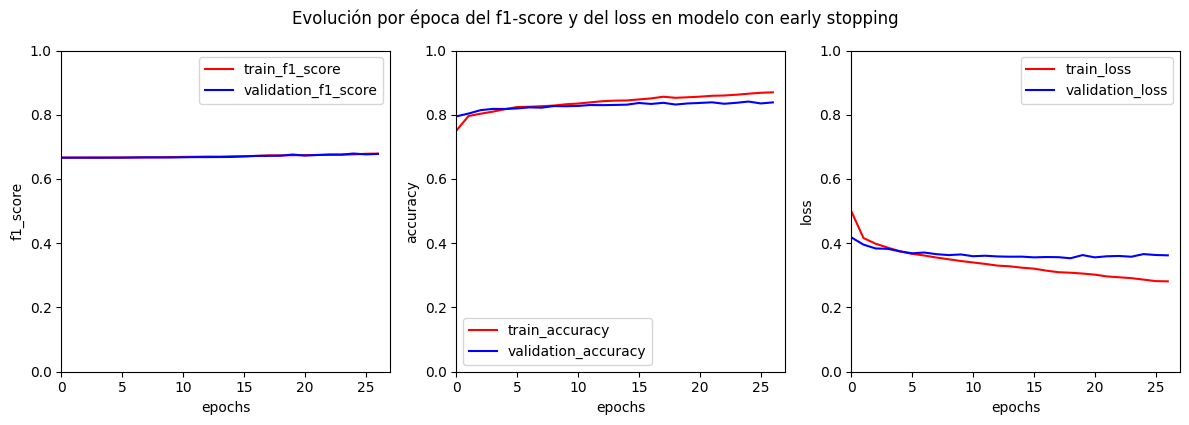

In [276]:
plotComparisonAlongEpochs(neuralNetworkTrainingHistory.history, 27, "con early stopping")

Ahora el ploteo de la evolución para el modelo entrenado en más epochs:

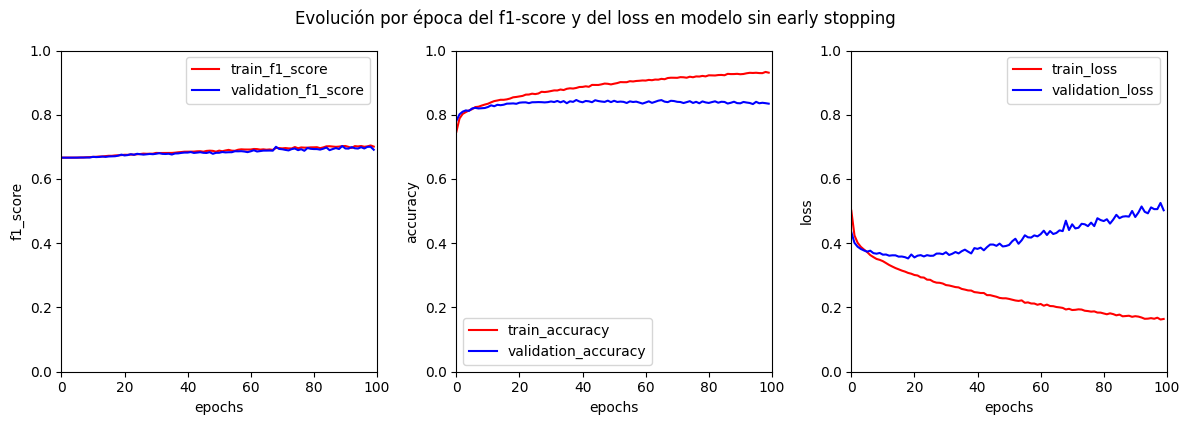

In [277]:
plotComparisonAlongEpochs(neuralNetworkOverfittedHistory.history, 100, "sin early stopping")

En este último se puede observar cómo el loss en validation fue aumentando luego del punto de inflexión, llevando al overfitting del modelo

Mostramos un resumen de la arquitectura de la red neuronal

In [254]:
neuralNetwork.summary()

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_656 (Dense)           (None, 189)               39690     
                                                                 
 leaky_re_lu_524 (LeakyReLU  (None, 189)               0         
 )                                                               
                                                                 
 dropout_524 (Dropout)       (None, 189)               0         
                                                                 
 dense_657 (Dense)           (None, 164)               31160     
                                                                 
 leaky_re_lu_525 (LeakyReLU  (None, 164)               0         
 )                                                               
                                                                 
 dropout_525 (Dropout)       (None, 164)            

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

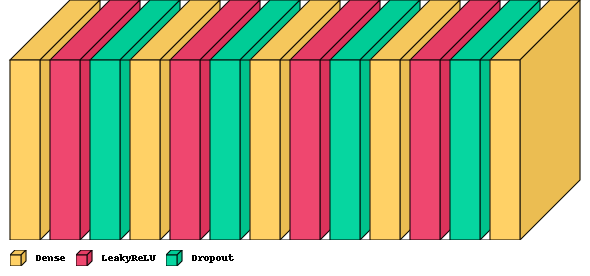

In [255]:
visualkeras.layered_view(neuralNetwork, min_xy=180, min_z=30, legend=True)

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

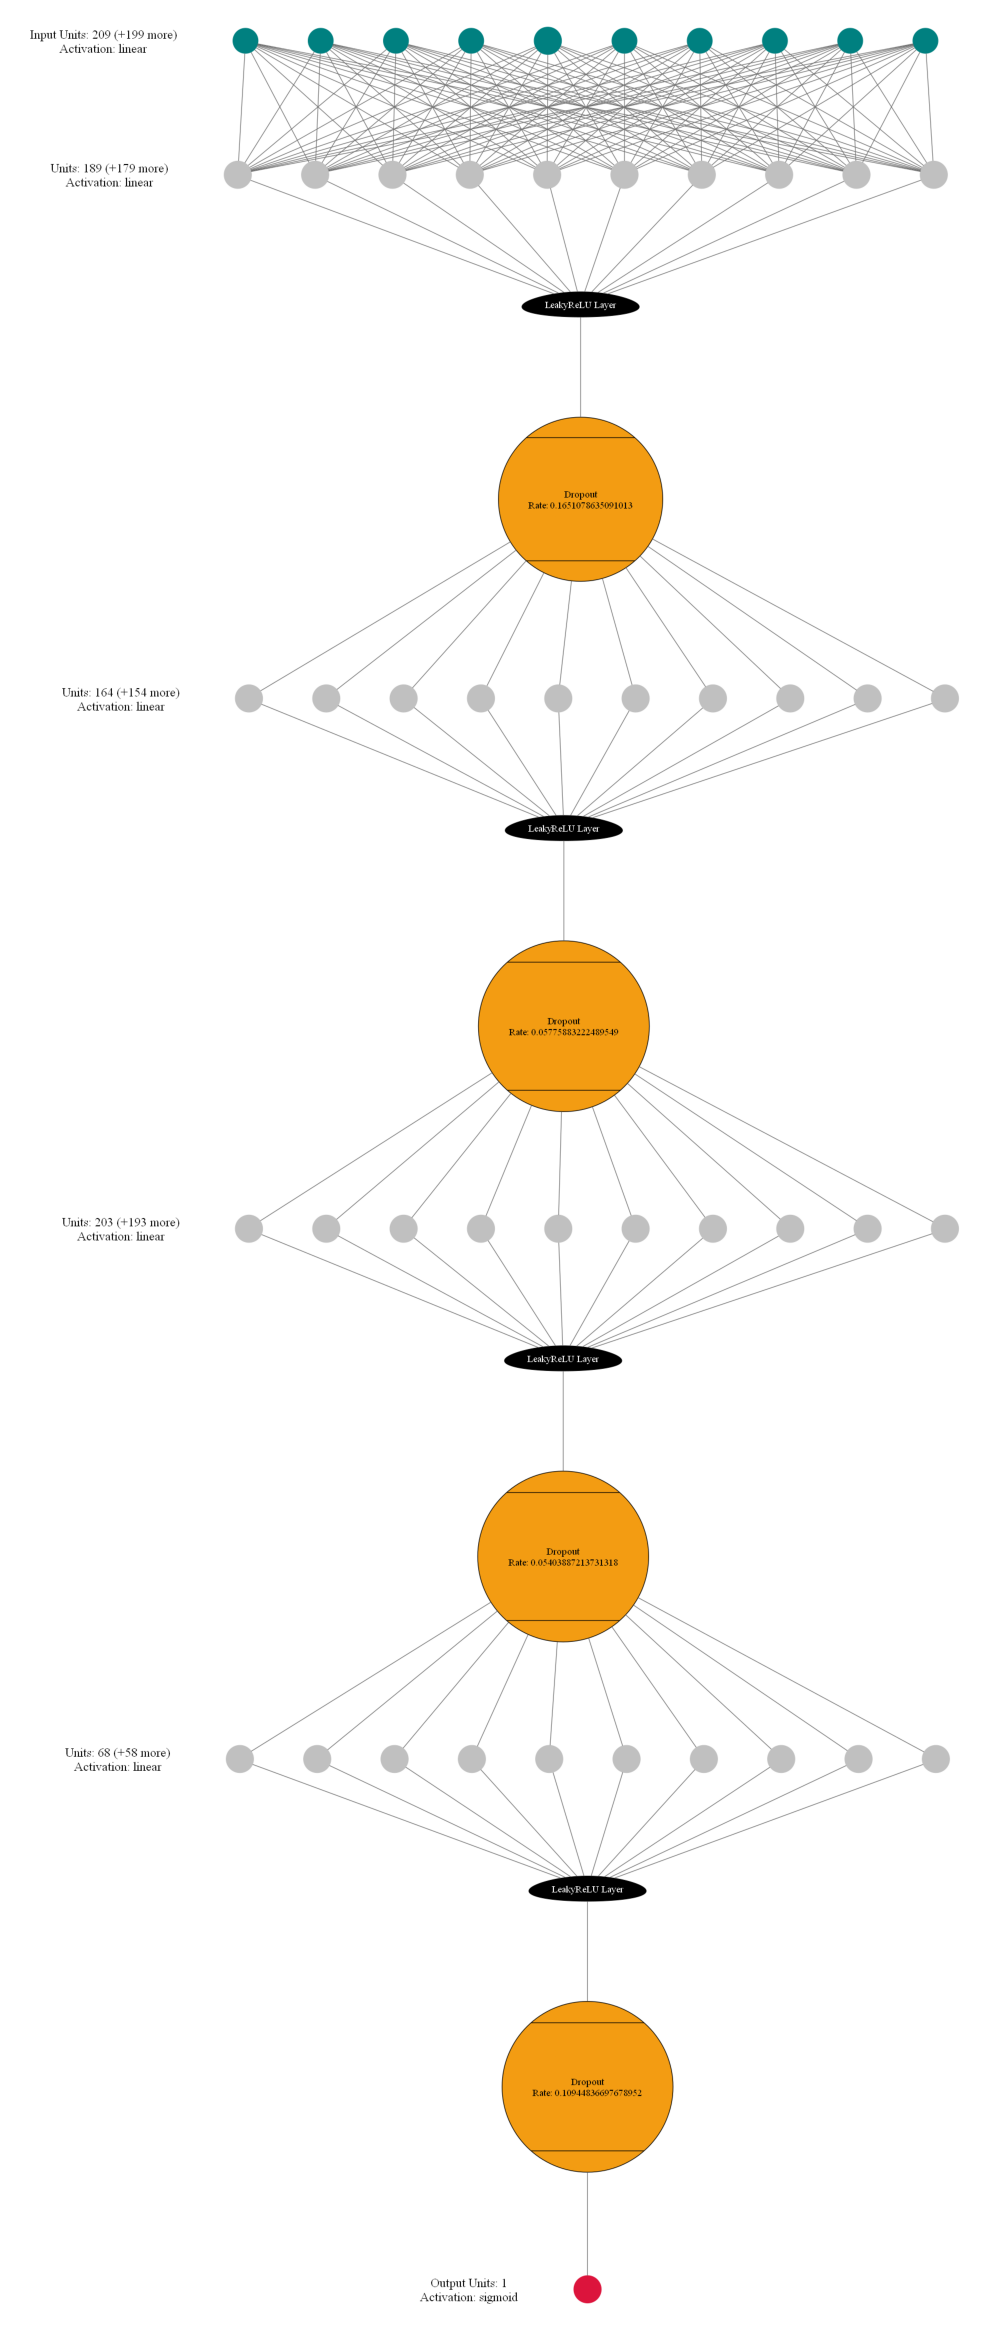

In [256]:
neuralNetworkImagePath = f"./imgs/{runNumber}_neural_network"
settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(neuralNetwork, view=False, file_name=neuralNetworkImagePath, file_format='png', settings=settings)

neuralNetworkImage = plt.imread(f"{neuralNetworkImagePath}.png")

plt.figure(figsize = (30,30))
plt.axis('off')
plt.imshow(neuralNetworkImage)

##### Métricas y predicciones para el modelo con early stopping

Ejecutamos la predicción de train con el dataset de train completo

In [257]:
y_pred = neuralNetwork.predict(x_train_scaled)
y_pred = convertProbasToClasses(y_pred)

1112/1112 [==============================] - 3s 3ms/step


Mostramos las métricas de train completo

In [258]:
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8847418566088643
Recall: 0.8917505482764438
Precision: 0.8793390262836863
f1 score: 0.8855012982661865


Realizamos ahora las predicciones del split de test

In [259]:
y_pred = neuralNetwork.predict(x_test_scaled)
y_pred = convertProbasToClasses(y_pred)

  1/245 [..............................] - ETA: 5s

245/245 [==============================] - 1s 3ms/step


Imprimimos la matriz de confusión

F1-Score: 0.8313784840459075


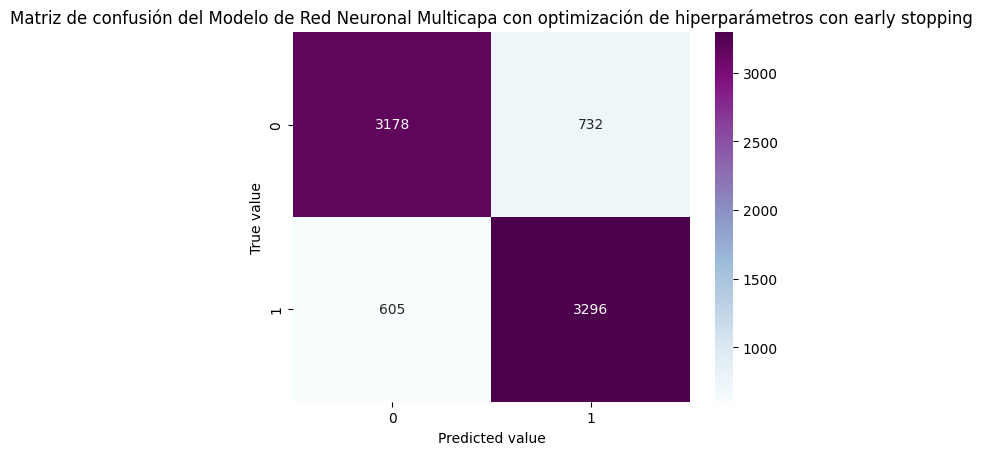

In [282]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_test,y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo de Red Neuronal Multicapa con optimización de hiperparámetros con early stopping")
plt.show()

Mostramos las distintas métricas

In [261]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8256305210600435
Recall: 0.8364521917457062
Precision: 0.81840983195385
f1 score: 0.8273326572008114


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [262]:
y_pred = neuralNetwork.predict(testDataScaled)
y_pred = convertProbasToClasses(y_pred)

  1/830 [..............................] - ETA: 20s

830/830 [==============================] - 3s 3ms/step


Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [263]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr,id,is_canceled
0,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,7,36.162958,2,100.0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,11,30.000000,2,101.0,aba9aac2-4495-4645-a60e-90328713c999,0


Para exportar a Kaggle hacemos lo siguiente

In [264]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [265]:
exportResult.head(2)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0


El `runNumber` es sólo un número que ponemos para no pisar los submits

In [266]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_neural_network.csv", index=False)

Guardamos una serialización del modelo elegido

In [267]:
filename = f'./neural_network_model_{runNumber}.joblib'
modelInfo = {'model': neuralNetwork}

joblib.dump(modelInfo, filename)

['./neural_network_model_39.joblib']

Y una del modelo sin early stopping

In [278]:
filename = f'./neural_network_model_overfitted_{runNumber}.joblib'
modelInfo = {'model': neuralNetwork}

joblib.dump(modelInfo, filename)

['./neural_network_model_overfitted_39.joblib']

##### Métricas y predicciones para el modelo sin early stopping

Ejecutamos la predicción de train con el dataset de train completo

In [283]:
y_pred = neuralNetworkOverfitted.predict(x_train_scaled)
y_pred = convertProbasToClasses(y_pred)

   1/1112 [..............................] - ETA: 28s

1112/1112 [==============================] - 3s 3ms/step


Mostramos las métricas de train completo

In [284]:
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.944689581518226
Recall: 0.9484338975425969
Precision: 0.9413406262209075
f1 score: 0.944873949579832


Se observan métricas con valores más altos, de manera esperada porque se ajustó mejor a ese conjunto de datos. Realizamos ahora las predicciones del split de test

In [288]:
y_pred = neuralNetworkOverfitted.predict(x_test_scaled)
y_pred = convertProbasToClasses(y_pred)

 20/245 [=>............................] - ETA: 0s

245/245 [==============================] - 1s 3ms/step


Imprimimos la matriz de confusión

F1-Score: 0.8313784840459075


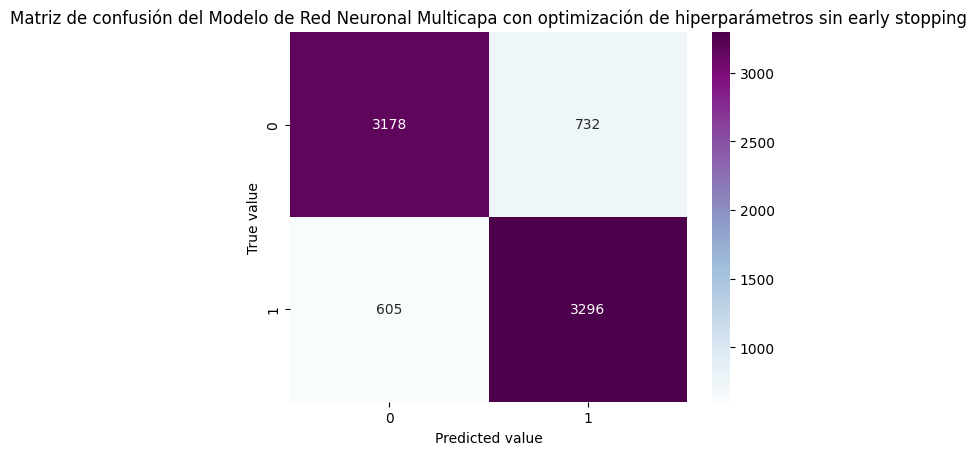

In [289]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_test,y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo de Red Neuronal Multicapa con optimización de hiperparámetros sin early stopping")
plt.show()

Mostramos las distintas métricas

In [290]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.828831135578031
Recall: 0.8449115611381697
Precision: 0.8182720953326713
f1 score: 0.8313784840459075


Vemos que a pesar de que hizo overfitting sobre el conjunto de datos de training, logró generalizar mejor que el modelo con early stopping

Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [291]:
y_pred = neuralNetworkOverfitted.predict(testDataScaled)
y_pred = convertProbasToClasses(y_pred)

 17/830 [..............................] - ETA: 2s 

830/830 [==============================] - 2s 3ms/step


Agrupamos en el dataframe el id que guardamos antes y los valores predichos

In [292]:
imputedAndFilteredTestEncoded["id"] = hotelsTestIds
imputedAndFilteredTestEncoded["is_canceled"] = y_pred

imputedAndFilteredTestEncoded.head(2)

,total_of_special_requests,stays_in_weekend_nights,stays_in_week_nights,reserved_room_type_P,reserved_room_type_H,reserved_room_type_G,reserved_room_type_F,reserved_room_type_E,reserved_room_type_D,reserved_room_type_C,...,arrival_date_month_January,arrival_date_month_February,arrival_date_month_December,arrival_date_month_August,arrival_date_day_of_month,agent,adults,adr,id,is_canceled
0,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,7,36.162958,2,100.0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,11,30.000000,2,101.0,aba9aac2-4495-4645-a60e-90328713c999,0


Para exportar a Kaggle hacemos lo siguiente

In [293]:
exportResult = imputedAndFilteredTestEncoded.get(["id", "is_canceled"])
exportResult.shape

(26535, 2)

In [294]:
exportResult.head(2)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0


El `runNumber` es sólo un número que ponemos para no pisar los submits

In [295]:
exportResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_neural_network_overfitted.csv", index=False)

Guardamos una serialización del modelo elegido

In [296]:
filename = f'./neural_network_model_{runNumber}.joblib'
modelInfo = {'model': neuralNetwork}

joblib.dump(modelInfo, filename)

['./neural_network_model_39.joblib']